In [10]:
# python env: modnenv_v2

import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path, PosixPath
import matplotlib.pyplot as plt
import json 
import pandas as pd
from copy import deepcopy
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from scipy.stats import spearmanr
from IPython.display import Image
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Plan

1. Give 1 featurized dataframe (X) with a target dataframe (Y) sharing the same index
2. Choose a subset of X and Y, such as Xt and Yt, to be used as a starting set
    - percentage?
    - via list of index?
3. Train a MODNet model (GA) with Xt and Yt
    - Benchmark it via a cross-validation first and save the results
4. Predict the rest of the data, Xp = X-Xt and Yp = Y-Yt
5. Rank those predictions based on an acquisition function
    - random
    - ... look up in re2fractive
6. Select the best candidates based on the ranking, Xn and Yn
    - fixed number?
    - percentage of training set?
7. Iterate from point 3 with Xt = Xt+Xn and Yt = Yt+Yn until a criterion is reached:
    - number of cycles?
    - a given set of instances is included in the training set?
    - the model has reached a given accuracy

# 1. Give a featurized dataframe (X) with a target dataframe (Y) sharing the same index

In [11]:
def load_feat_selec_df(md_feat_selec):
    assert type(md_feat_selec)==str or type(md_feat_selec)==PosixPath or type(md_feat_selec)==MODData

    if type(md_feat_selec)==str or type(md_feat_selec)==PosixPath:
        md = MODData.load(md_feat_selec)
    else:
        md = deepcopy(md_feat_selec)
    
    X = md.df_featurized
    Y = md.df_targets
    # Let's save the important information of the featurized MODData for easier reuse
    dct_md_info={
        'optimal_features':             md.optimal_features,
        'optimal_features_by_target':   md.optimal_features_by_target,
        'num_classes':                  md.num_classes
    }

    return X, Y, dct_md_info

In [12]:
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')

# Load the featurized MODData
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

2024-01-19 10:12:43,468 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f738350ae20> object, created with modnet version 0.4.1


In [13]:
# Verify that the instances of X and Y have the same number of instances with the same index
if X.shape[0] != Y.shape[0]:
    raise Exception(f'X and Y DO NOT have the same number of instances, although they should! X has {X.shape[0]} instances while Y has {Y.shape[0]} instances.')
else:
    print(f"    - Number of instances:  {X.shape[0]}")
    print(f"X:")
    print(f"    - Number of features:   {X.shape[1]}")
    print(f"Y:")
    print(f"    - Number of targets:    {Y.shape[1]}")
    if X.index.equals(Y.index):
        print(f"The respective instances of X and Y all have the same index.")
    else:
        raise Exception(f"The respective instances of X and Y DO NOT all have the same index although they should!")

# TODO: - allow for mismatched indexes between X and Y but reorder them with a warning
#       - allow for a different number of instances between X and Y
#           - issue a warning and continue with the common instances
#           - use the non-common instances as data pool for DFT or else

    - Number of instances:  4001
X:
    - Number of features:   3019
Y:
    - Number of targets:    1
The respective instances of X and Y all have the same index.


# 2. Choose a subset of X and Y, such as Xt and Yt, to be used as a starting set

In [14]:
def train_pool_random(X, Y, n=None, frac=0.1, state=None, axis=None):
    # Train dataset
    Xt = X.sample(n=n, frac=frac, random_state=state, axis=0)

    Yt = Y.filter(items=Xt.index.values, axis=0)

    # Pool dataset
    Xp = X.drop(Xt.index.values, axis=0)
    Yp = Y.drop(Yt.index.values, axis=0)

    return Xt, Yt, Xp, Yp

In [15]:
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

#   3. Train a MODNet model (GA) with Xt and Yt

In [16]:
def benchmk(
        X, Y, dct_md_info,
        model_type=FitGenetic, model_params=None,
        kf_k=5, kf_state=None, 
        bmk_dir_path='./benchmark',
        icycle=0
        ):

    assert type(bmk_dir_path)==str or type(bmk_dir_path)==PosixPath
    bmk_dir_path = Path(bmk_dir_path)


    if not os.path.isdir(bmk_dir_path):
        os.mkdir(bmk_dir_path)
    figs_dir_path = (bmk_dir_path / 'figs')
    if not os.path.isdir(figs_dir_path):
        os.mkdir(figs_dir_path)
    fig_path = (figs_dir_path / f'fig_{icycle:02}.png')
    models_dir_path = (bmk_dir_path / 'models')
    if not os.path.isdir(models_dir_path):
        os.mkdir(models_dir_path)
    scores_dir_path = (bmk_dir_path / 'scores')
    if not os.path.isdir(scores_dir_path):
        os.mkdir(scores_dir_path)
    scores_path = (scores_dir_path / f'scores_{icycle:02}.json')


    if fig_path.exists():
        fig = Image(filename=fig_path)
        display(fig)
        with open(scores_path) as f:
          scores = json.load(f)
        return scores
    else:

        # Create a new training MODData that will be split into k folds
        md_t = MODData(df_featurized=X)
        md_t.df_targets                 = Y
        md_t.optimal_features           = dct_md_info['optimal_features']
        md_t.optimal_features_by_target = dct_md_info['optimal_features_by_target']
        md_t.num_classes                = dct_md_info['num_classes']

        # Scores
        pred_mae  = []
        pred_rmse = []
        pred_spr  = []
        unc_mae   = []
        unc_rmse  = []

        # Figure
        plt.figure(figsize=(10,5))

        kf = KFold(kf_k, shuffle=True, random_state=kf_state)
        for ind, (train, test) in enumerate(
            kf.split(X=X, y=Y)
        ):
            # KFold
            train_moddata, test_moddata = md_t.split((train, test))

            model_path = (
                models_dir_path / f"model_{icycle:02}_{ind:02}.pkl"
            )
            if model_path.exists():
                model = EnsembleMODNetModel.load(model_path)
            else:
                ga = model_type(train_moddata)
                model = ga.run(
                    **model_params
                )
                model.save(model_path)

            predictions, uncertainties = model.predict(test_moddata, return_unc=True)

            # Scores
            pred_mae.append(mean_absolute_error(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                )
                )
            pred_rmse.append(mean_squared_error(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                )
                )
            pred_spr.append(spearmanr(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                ).statistic
                )

            unc_mae.append(mean_absolute_error(
                np.zeros(np.array(uncertainties[test_moddata.target_names[0]]).shape),
                np.array(uncertainties[test_moddata.target_names[0]])
                )
                )
            unc_rmse.append(mean_squared_error(
                np.zeros(np.array(uncertainties[test_moddata.target_names[0]]).shape),
                np.array(uncertainties[test_moddata.target_names[0]])
                )
                )
            

            # Plot
            plt.scatter(
                test_moddata.df_targets.values.ravel(),
                predictions.values.ravel(),
            )
            plt.errorbar(
                test_moddata.df_targets.values.ravel(),
                predictions.values.ravel(),
                yerr=uncertainties.values.ravel(),
                ls="none",
            )


        # Save scores
        scores = {
            'pred_mae': pred_mae,
            'pred_rmse': pred_rmse,
            'pred_spr': pred_spr,
            'unc_mae': unc_mae,
            'unc_rmse': unc_rmse,
        }
        with open(scores_path, 'w') as f:
          json.dump(scores, f)


        # Plot
        pred_mae = np.array(pred_mae)
        pred_rmse = np.array(pred_rmse)
        pred_spr = np.array(pred_spr)
        unc_mae = np.array(unc_mae)
        unc_rmse = np.array(unc_rmse)

        print("Benchmark complete.")
        txt_accuracy = ''
        txt_accuracy += f"MAE: {np.mean(pred_mae):.3f}±{np.std(pred_mae):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"MAE folds:        {np.array2string(pred_mae, precision=3)}"
        txt_accuracy += "\n"
        txt_accuracy += f"MAE unc folds: {np.array2string(unc_mae, precision=3)}"
        txt_accuracy += "\n\n"
        txt_accuracy += f"RMSE: {np.mean(pred_rmse):.3f}±{np.std(pred_rmse):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"RMSE folds:        {np.array2string(pred_rmse, precision=3)}"
        txt_accuracy += "\n"
        txt_accuracy += f"RMSE unc folds: {np.array2string(unc_rmse, precision=3)}"
        txt_accuracy += "\n\n"
        txt_accuracy += f"SPEARMAN: {np.mean(pred_spr):.3f}±{np.std(pred_spr):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"SPEARMAN folds: {np.array2string(pred_spr, precision=3)}"
        # print(txt_accuracy)

        plt.plot(
            np.linspace(
                np.min(md_t.df_targets.values)-0.5,
                np.max(md_t.df_targets.values)+0.5,
                3,
            ),
            np.linspace(
                np.min(md_t.df_targets.values)-0.5,
                np.max(md_t.df_targets.values)+0.5,
                3,
            ),
            color="black",
            ls="--",
        )

        plt.subplots_adjust(right=0.5)
        plt.ylabel("Predicted $n$")
        plt.xlabel("Computed $n$")
        plt.xlim((np.min(md_t.df_targets.values)-0.5,np.max(md_t.df_targets.values)+0.5))
        plt.ylim((np.min(md_t.df_targets.values)-0.5,np.max(md_t.df_targets.values)+0.5))
        # plt.title(f"MAE: {(scores):.3f}±{np.std(scores):.3f}")
        plt.text(np.max(md_t.df_targets.values)+0.6, 
                 (np.max(md_t.df_targets.values)-np.min(md_t.df_targets.values))/2 + np.min(md_t.df_targets.values),
                 verticalalignment='center',
                 s = txt_accuracy)

        plt.savefig(fig_path)
        
        
        return scores

2024-01-19 10:11:55,084 - modnet - INFO - Targets:
2024-01-19 10:11:55,085 - modnet - INFO - 1)refractive_index: regression
2024-01-19 10:11:55,147 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-19 10:11:55,150 - modnet - INFO - Generation number 0


  0%|          | 0/2 [00:00<?, ?it/s]2024-01-19 10:11:55.412377: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:11:55.413993: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:11:55.421685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:11:55.423420: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:11:55.437840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9

1/1 [==============================] - 0s 70ms/step


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]

1/1 [==============================] - 0s 43ms/step
2024-01-19 10:12:02,807 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.414 	
2024-01-19 10:12:02,808 - modnet - INFO - Generation number 1



 50%|█████     | 1/2 [00:03<00:03,  3.42s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

1/1 [==============================] - 0s 28ms/step
2024-01-19 10:12:07,180 - modnet - INFO - Loss per individual: ind 0: 0.264 	ind 1: 0.222 	
2024-01-19 10:12:07,181 - modnet - INFO - Early stopping: same best model for 2 consecutive generations
2024-01-19 10:12:07,181 - modnet - INFO - Early stopping at generation number 1


2024-01-19 10:12:08,232 - modnet - INFO - Refit...
2024-01-19 10:12:08,532 - modnet - INFO - Generating bootstrap data...


  0%|          | 0/5 [00:00<?, ?it/s]2024-01-19 10:12:09.222009: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:09.223668: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:09.231608: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:09.233232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:09.247066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9

2024-01-19 10:12:14,253 - modnet - INFO - Model #0	loss: 0.0608	mae: 0.0608	


 20%|██        | 1/5 [00:05<00:22,  5.64s/it]

2024-01-19 10:12:14,555 - modnet - INFO - Model #1	loss: 0.0696	mae: 0.0696	


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

2024-01-19 10:12:15,140 - modnet - INFO - Model #2	loss: 0.0824	mae: 0.0824	


 60%|██████    | 3/5 [00:06<00:03,  1.63s/it]

2024-01-19 10:12:15,824 - modnet - INFO - Model #3	loss: 0.0551	mae: 0.0551	


 80%|████████  | 4/5 [00:07<00:01,  1.25s/it]

2024-01-19 10:12:16,343 - modnet - INFO - Model #4	loss: 0.1242	mae: 0.1242	


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


2024-01-19 10:12:17,518 - modnet - INFO - Model successfully saved as benchmark/models/model_00_00.pkl!
4/4 [==============================] - 0s 1ms/step
2024-01-19 10:12:18,002 - modnet - INFO - Targets:
2024-01-19 10:12:18,003 - modnet - INFO - 1)refractive_index: regression
2024-01-19 10:12:18,027 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-19 10:12:18,029 - modnet - INFO - Generation number 0


  0%|          | 0/2 [00:00<?, ?it/s]2024-01-19 10:12:18.303902: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:18.305813: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:18.329401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 10:12:18.329434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 10:12:18.330117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to r

1/1 [==============================] - 0s 72ms/step


100%|██████████| 2/2 [00:08<00:00,  4.43s/it]

1/1 [==============================] - 0s 50ms/step
2024-01-19 10:12:26,910 - modnet - INFO - Loss per individual: ind 0: 0.230 	ind 1: 0.177 	
2024-01-19 10:12:26,910 - modnet - INFO - Generation number 1



 50%|█████     | 1/2 [00:03<00:03,  3.98s/it]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

1/1 [==============================] - 0s 30ms/step
2024-01-19 10:12:31,407 - modnet - INFO - Loss per individual: ind 0: 0.222 	ind 1: 0.282 	
2024-01-19 10:12:31,407 - modnet - INFO - Early stopping: same best model for 2 consecutive generations
2024-01-19 10:12:31,407 - modnet - INFO - Early stopping at generation number 1


2024-01-19 10:12:32,440 - modnet - INFO - Refit...
2024-01-19 10:12:32,591 - modnet - INFO - Generating bootstrap data...


  0%|          | 0/5 [00:00<?, ?it/s]2024-01-19 10:12:33.363603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:33.363603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:33.365786: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:33.365786: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:33.393779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9

2024-01-19 10:12:38,582 - modnet - INFO - Model #1	loss: 0.1074	mae: 0.1074	


 20%|██        | 1/5 [00:05<00:23,  5.92s/it]

2024-01-19 10:12:38,693 - modnet - INFO - Model #0	loss: 0.0563	mae: 0.0563	


 40%|████      | 2/5 [00:06<00:07,  2.50s/it]

2024-01-19 10:12:39,538 - modnet - INFO - Model #3	loss: 0.0844	mae: 0.0844	


 60%|██████    | 3/5 [00:06<00:03,  1.75s/it]

2024-01-19 10:12:39,574 - modnet - INFO - Model #2	loss: 0.0822	mae: 0.0822	
2024-01-19 10:12:40,153 - modnet - INFO - Model #4	loss: 0.0751	mae: 0.0751	


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


2024-01-19 10:12:41,198 - modnet - INFO - Model successfully saved as benchmark/models/model_00_01.pkl!
4/4 [==============================] - 0s 1ms/step
Benchmark complete.


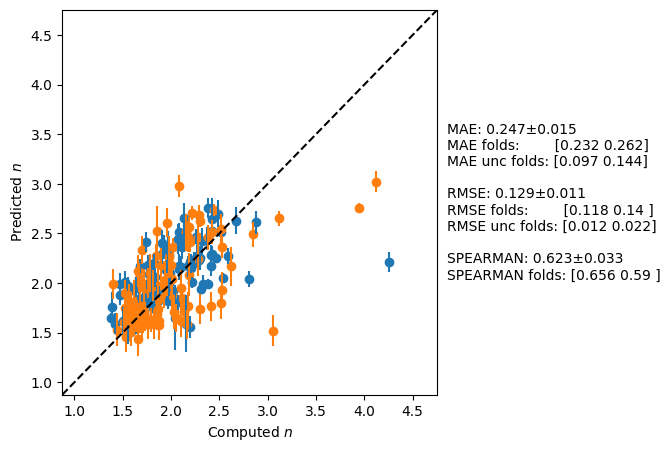

In [9]:
# Benchmark 

scores_test = benchmk(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params={
        'size_pop':2, # dflt 20
        'num_generations':2, # dflt 10
        'nested':0, # dflt = 5
        'n_jobs':2,
        'early_stopping':2, # dflt 4
        'refit':5, # dflt = 5
        'fast':False,
        },
    # model_dir_path=".", 
    kf_k=2, kf_state=42, 
    # fig_path=None,
    # scores_path=None,
    )

In [17]:
# Train
def train(
    X, Y, dct_md_info,
    model_type=FitGenetic, model_params=None, model_dir_path = (Path(".") / "production" / "models"),
    icycle=0
    ):

    # Create a new training MODData
    md_t = MODData(df_featurized=X)
    md_t.df_targets                 = Y
    md_t.optimal_features           = dct_md_info['optimal_features']
    md_t.optimal_features_by_target = dct_md_info['optimal_features_by_target']
    md_t.num_classes                = dct_md_info['num_classes']

    # Load or train and save
    if not os.path.isdir(model_dir_path):
        os.makedirs(model_dir_path)
    model_path = (
        model_dir_path / f"model_{icycle:02}.pkl"
    )
    if model_path.exists():
        print("Model already exists!")
        model = EnsembleMODNetModel.load(model_path)
    else:
        ga = model_type(md_t)
        model = ga.run(
            **model_params
        )
        model.save(model_path)

    return model

In [18]:
model_test = train(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params={
        'size_pop':2, # dflt 20
        'num_generations':2, # dflt 10
        'nested':0, # dflt = 5
        'n_jobs':2,
        'early_stopping':2, # dflt 4
        'refit':5, # dflt = 5
        'fast':False,
        },
    # model_dir_path=".", 
    )

2024-01-19 10:12:43,722 - modnet - INFO - Targets:
2024-01-19 10:12:43,722 - modnet - INFO - 1)refractive_index: regression
2024-01-19 10:12:43,766 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-19 10:12:43,768 - modnet - INFO - Generation number 0


  0%|          | 0/2 [00:00<?, ?it/s]2024-01-19 10:12:44.138219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:44.138219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:12:44.140140: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:44.140140: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:12:44.169285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9

1/1 [==============================] - 0s 71ms/step


100%|██████████| 2/2 [00:10<00:00,  5.19s/it]

1/1 [==============================] - 0s 45ms/step
2024-01-19 10:12:54,166 - modnet - INFO - Loss per individual: ind 0: 0.258 	ind 1: 0.233 	
2024-01-19 10:12:54,167 - modnet - INFO - Generation number 1



 50%|█████     | 1/2 [00:04<00:04,  4.35s/it]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

2024-01-19 10:12:58,708 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.264 	


2024-01-19 10:12:59,632 - modnet - INFO - Refit...
2024-01-19 10:12:59,735 - modnet - INFO - Generating bootstrap data...


  0%|          | 0/5 [00:00<?, ?it/s]2024-01-19 10:13:00.462237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 10:13:00.464054: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:13:00.489756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 10:13:00.489803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 10:13:00.490404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may

2024-01-19 10:13:05,532 - modnet - INFO - Model #0	loss: 0.1098	mae: 0.1098	


 20%|██        | 1/5 [00:05<00:22,  5.73s/it]

2024-01-19 10:13:05,623 - modnet - INFO - Model #1	loss: 0.0344	mae: 0.0344	
2024-01-19 10:13:06,479 - modnet - INFO - Model #2	loss: 0.0759	mae: 0.0759	


 60%|██████    | 3/5 [00:06<00:03,  1.84s/it]

2024-01-19 10:13:06,856 - modnet - INFO - Model #3	loss: 0.0614	mae: 0.0614	


 80%|████████  | 4/5 [00:07<00:01,  1.33s/it]

2024-01-19 10:13:07,423 - modnet - INFO - Model #4	loss: 0.0977	mae: 0.0977	


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


2024-01-19 10:13:08,539 - modnet - INFO - Model successfully saved as production/models/model_00.pkl!


#   4. Predict the rest of the data, Xp = X-Xt

In [19]:
def predict(
        X, model, results_dir_path = Path('./production/results'),
        icycle=0,
):
    # New MODData to predict
    md_p = MODData(
        materials       = [None]*X.shape[0],
        df_featurized   = X,
        structure_ids   = X.index.values.flatten(),
    )

    if not os.path.isdir(results_dir_path):
        os.makedirs(results_dir_path)
    results_path = (
        results_dir_path / f"results_{icycle:02}.pkl"
    )
    if results_path.exists():
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
    else:
        # Predict the filtered MP
        results = model.predict(md_p, return_unc=True)

        with open(results_path, 'wb') as f:
            pickle.dump(results, f)

    return results

In [20]:
results_test = predict(X=Xp, model=model_test
                    #    results_dir_path=
                       )
display(results_test[0])
display(results_test[1])

119/119 [==============================] - 0s 696us/step


,refractive_index
mp-755116,2.940135
mp-755478,2.344163
mp-17998,2.607859
mp-754065,2.161812
mp-553961,2.184426
...,...
mp-698480,1.940327
mp-23740,1.735826
mp-8333,1.693709
mp-643898,1.587222


,refractive_index
mp-755116,0.245386
mp-755478,0.054869
mp-17998,0.099493
mp-754065,0.082570
mp-553961,0.074290
...,...
mp-698480,0.071973
mp-23740,0.074341
mp-8333,0.043241
mp-643898,0.051407


#   5. Rank those predictions based on an acquisition function

In [21]:
# Exploration - highest uncertainties
def exploration(predictions, uncertainties):
    unc = uncertainties.copy()
    target = unc.columns.values
    unc['score'] = unc[target].rank(pct=True)
    return unc

#   6. Select the best candidates based on the ranking, Xn and Yn

In [28]:
def select(Xt, Yt, Xp, Yp, results, acquisition=None, frac=0.05, n=None, **acquisition_kwargs):
    # unpacking the results
    predictions, uncertainties = results
    if not acquisition:
        id_selected = predictions.sample(n=n, frac=frac, axis=0, **acquisition_kwargs).index.values
    else:
        scored = acquisition(predictions, uncertainties, **acquisition_kwargs)
        scored = scored.sort_values(by='score',ascending=False).dropna()
        if n:
            id_selected = scored.index.values[:n]
        else:
            id_selected = scored.index.values[:int(len(Xt)*frac)]
        
    
    Xs = Xp.filter(items=id_selected, axis=0)
    Ys = Yp.filter(items=id_selected, axis=0)
    return pd.concat([Xt, Xs], axis=0), pd.concat([Yt, Ys], axis=0), Xp.drop(Xs.index, axis=0), Yp.drop(Ys.index, axis=0)


In [29]:
Xtn, Ytn, Xpn, Ypn = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, results=results_test, acquisition=exploration)

#   7. Iterate from point 3 with Xt = Xt+Xn and Yt = Yt+Yn until a criterion is reached:

2024-01-13 18:00:56,564 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fcfd470e8b0> object, created with modnet version 0.4.1


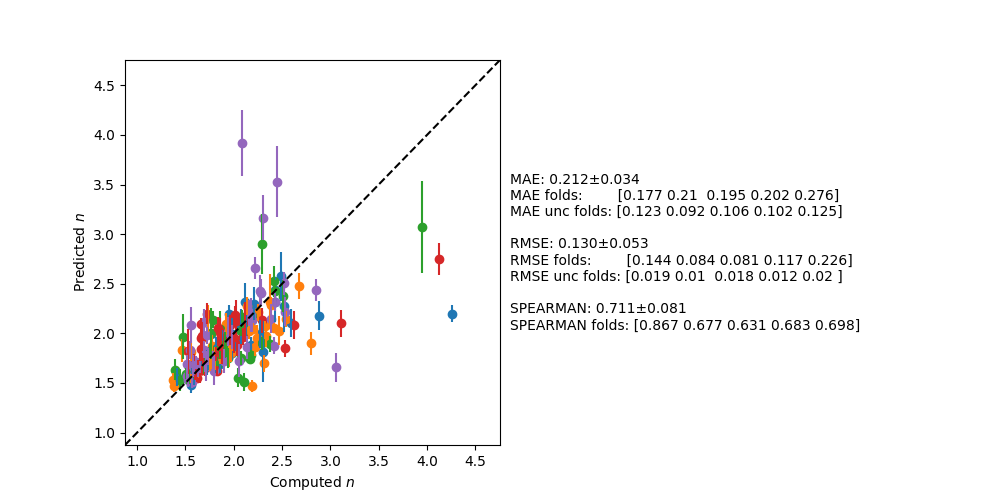

Model already exists!
2024-01-13 18:00:57,014 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fcf3b193550> object, created with modnet version 0.4.1


In [9]:
# 1 iteration
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')

# Load the data from a featurized MODData that underwent feature_selection
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

# Choose a subset of the data to start the learning iterations
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

# Choose the model you want to use
model_type=FitGenetic
model_params={
    'size_pop':2, # dflt 20
    'num_generations':2, # dflt 10
    'nested':0, # dflt = 5
    'n_jobs':2,
    'early_stopping':2, # dflt 4
    'refit':5, # dflt = 5
    'fast':False,
    }

# Benchmark 
scores_bk = benchmk(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params=model_params,
    kf_k=2, kf_state=42, 
    # bmk_dir_path=
    )

# Train
model = train(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params=model_params,
    # model_dir_path=".", 
    )

# Predict the pool data
results = predict(X=Xp, model=model
                    #    results_dir_path=
                  )

# Score, rank, and select the new data to be added to training
Xtn, Ytn, Xpn, Ypn = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, results=results, acquisition=exploration)

2024-01-15 21:49:39,937 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f55c06fcca0> object, created with modnet version 0.4.1
200


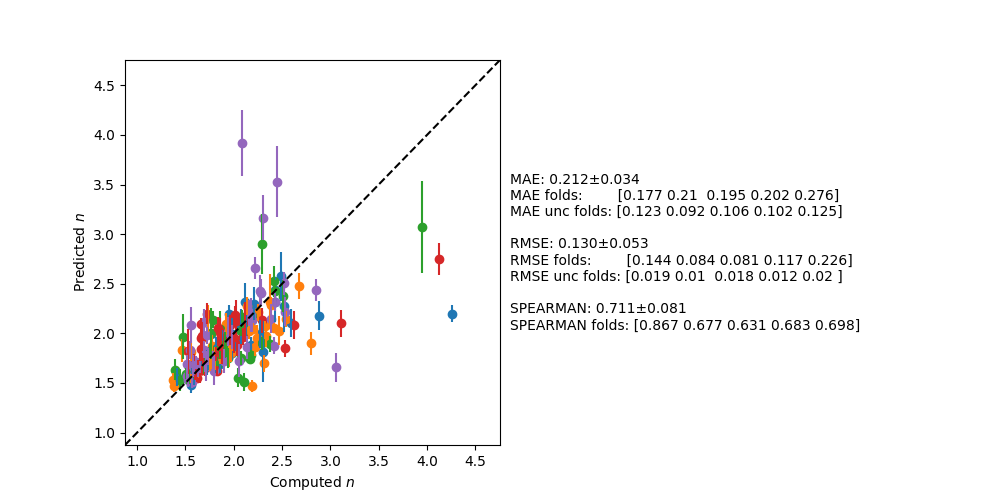

Model already exists!
2024-01-15 21:49:40,502 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55271d38e0> object, created with modnet version 0.4.1
300


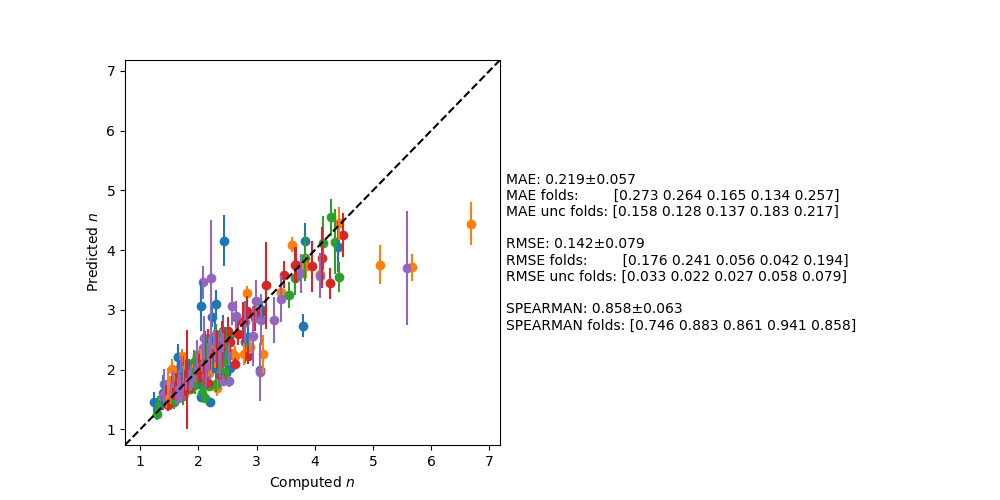

Model already exists!
2024-01-15 21:49:40,834 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55271d3100> object, created with modnet version 0.4.1
400


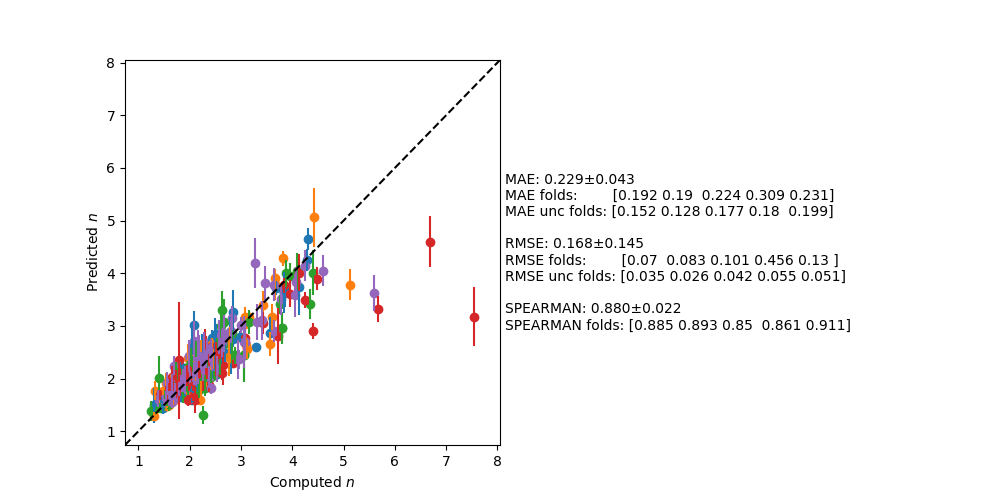

Model already exists!
2024-01-15 21:49:41,172 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f552728f9a0> object, created with modnet version 0.4.1
500


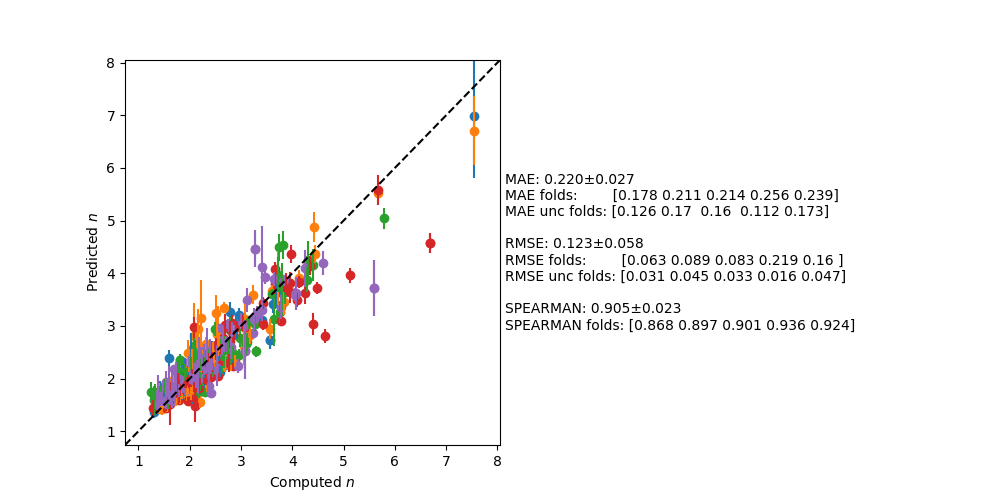

Model already exists!
2024-01-15 21:49:41,666 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f552722a250> object, created with modnet version 0.4.1
600


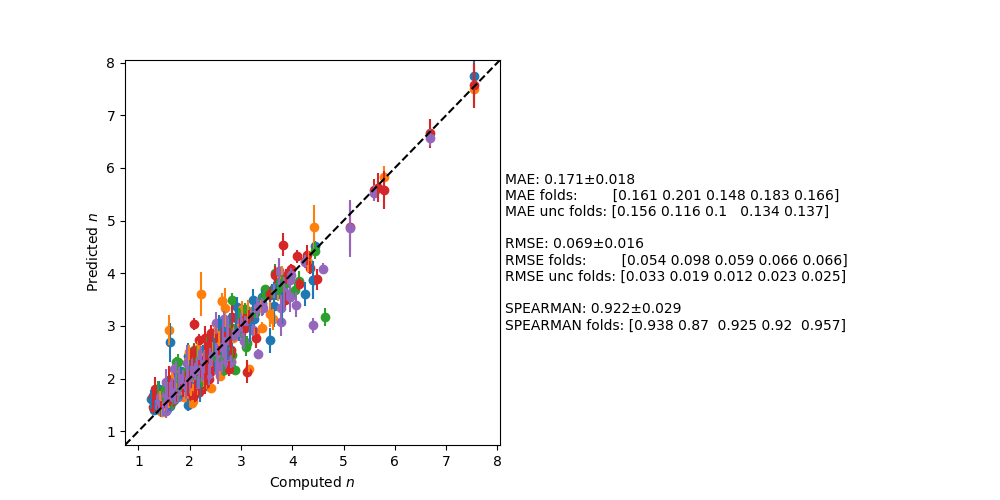

Model already exists!
2024-01-15 21:49:41,963 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553d91e2e0> object, created with modnet version 0.4.1
700


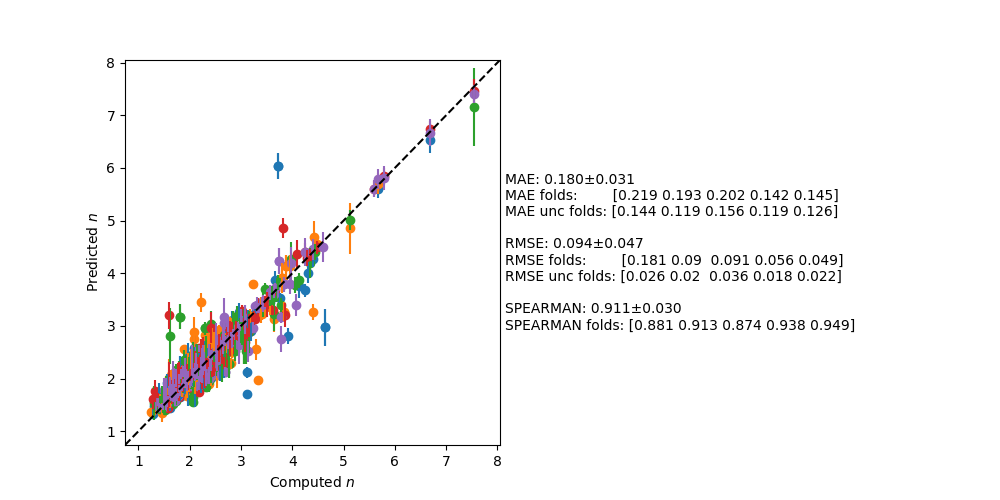

Model already exists!
2024-01-15 21:49:42,327 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55273d6e80> object, created with modnet version 0.4.1
800


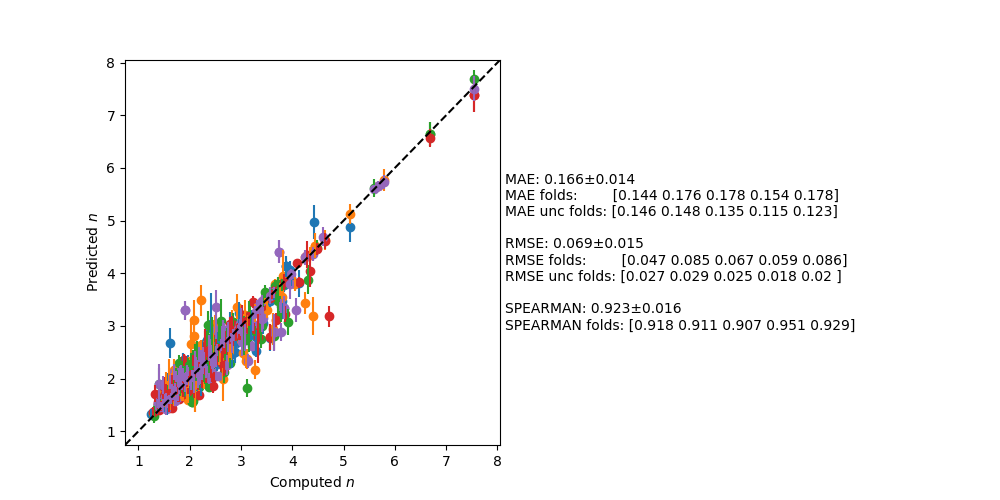

Model already exists!
2024-01-15 21:49:42,688 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f552745c8e0> object, created with modnet version 0.4.1
900


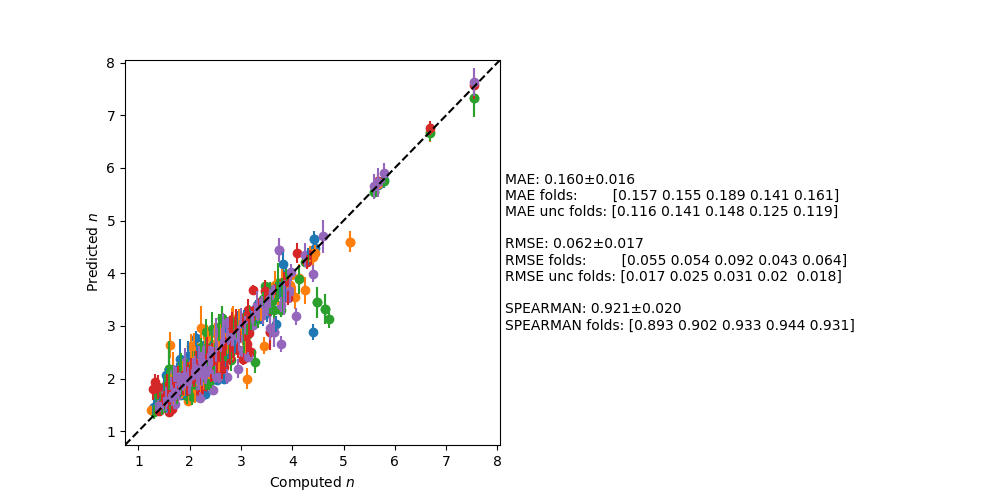

Model already exists!
2024-01-15 21:49:43,048 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f554b3ccb50> object, created with modnet version 0.4.1
1000


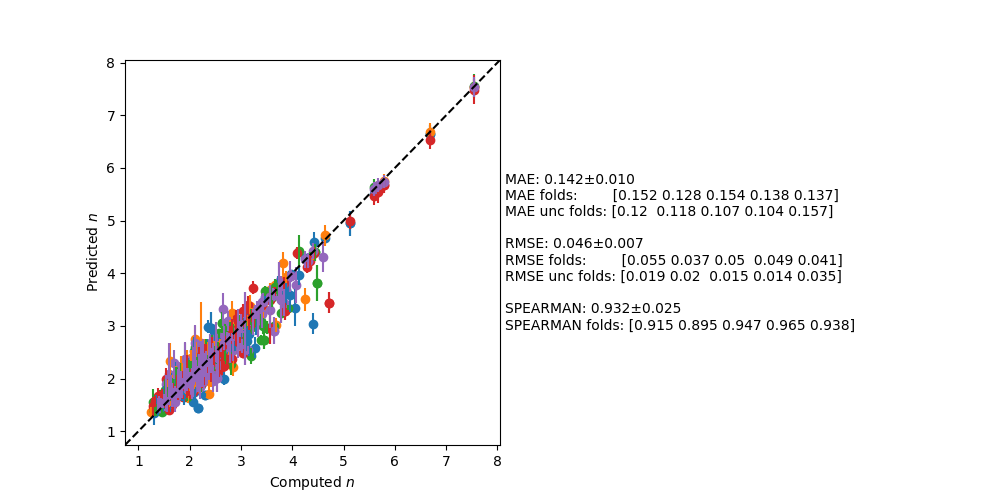

Model already exists!
2024-01-15 21:49:43,423 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55272e8820> object, created with modnet version 0.4.1
1100


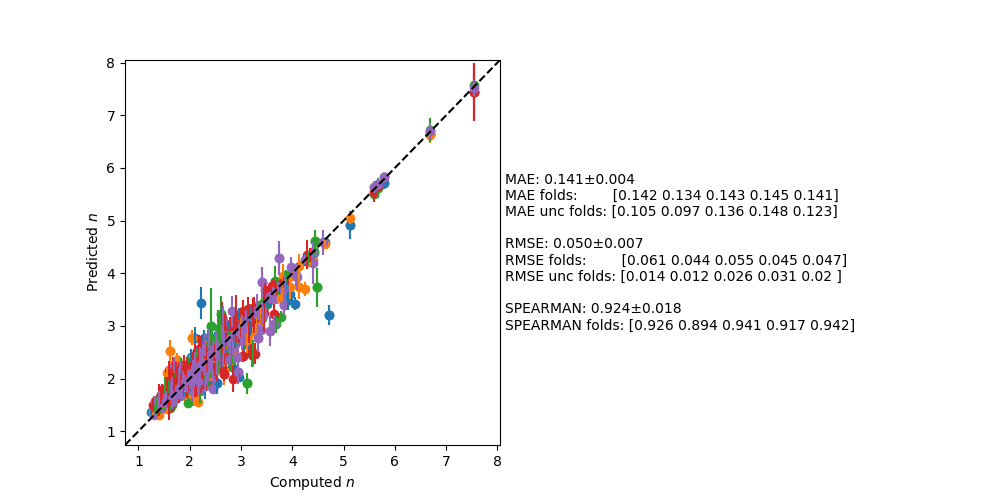

Model already exists!
2024-01-15 21:49:43,720 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55316e3760> object, created with modnet version 0.4.1
1200


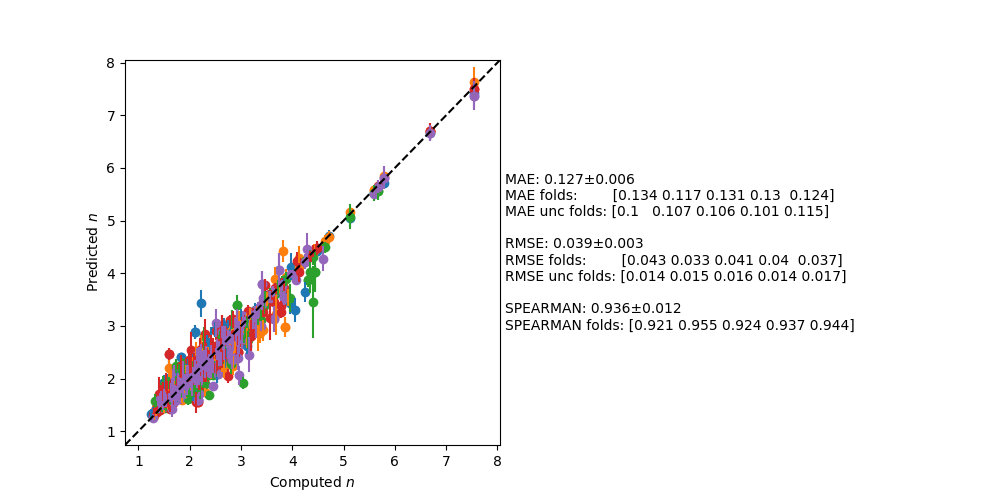

Model already exists!
2024-01-15 21:49:44,037 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5527350310> object, created with modnet version 0.4.1
1300


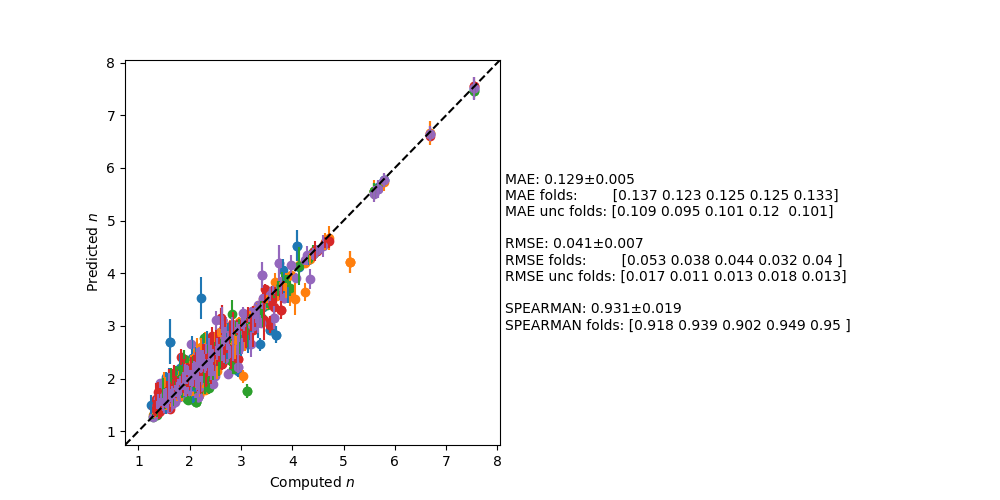

Model already exists!
2024-01-15 21:49:44,344 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55273bfca0> object, created with modnet version 0.4.1
1400


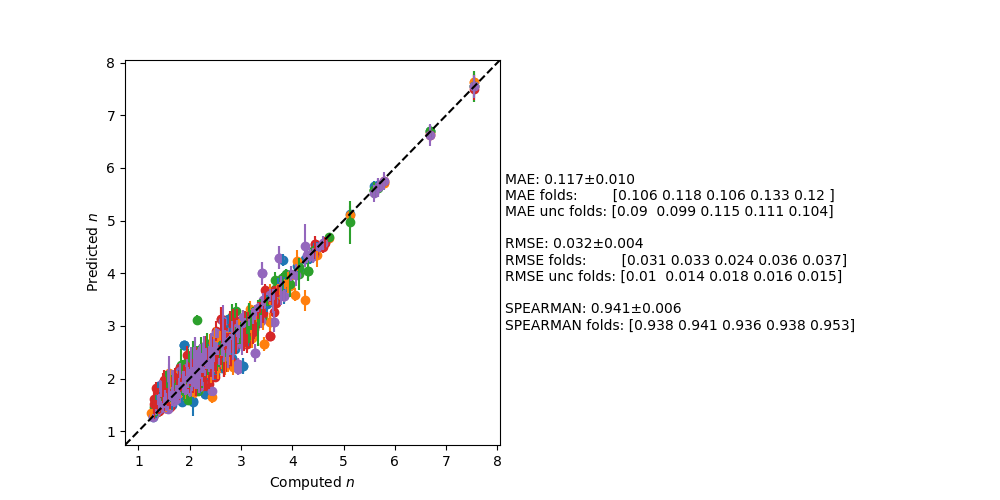

Model already exists!
2024-01-15 21:49:44,651 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55274804c0> object, created with modnet version 0.4.1
1500


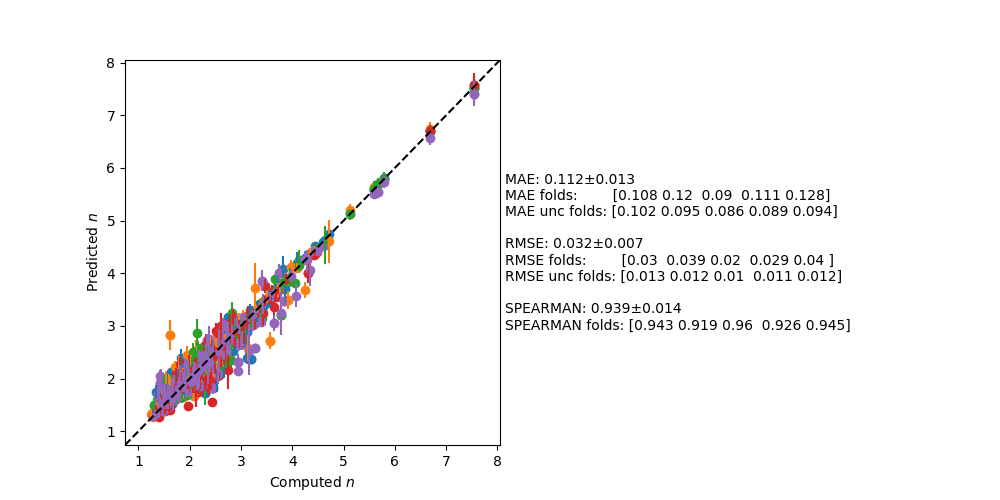

Model already exists!
2024-01-15 21:49:44,962 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5531922d30> object, created with modnet version 0.4.1
1600


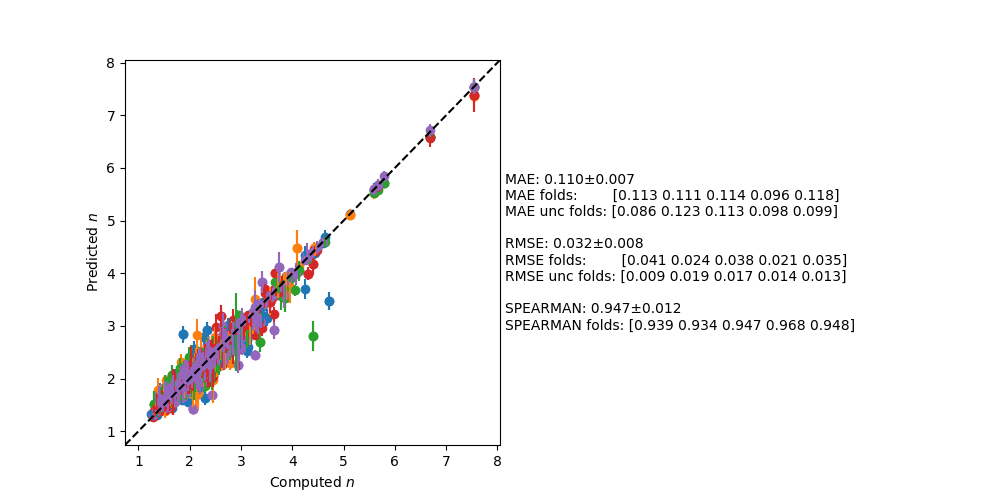

Model already exists!
2024-01-15 21:49:45,280 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5531773d90> object, created with modnet version 0.4.1
1700


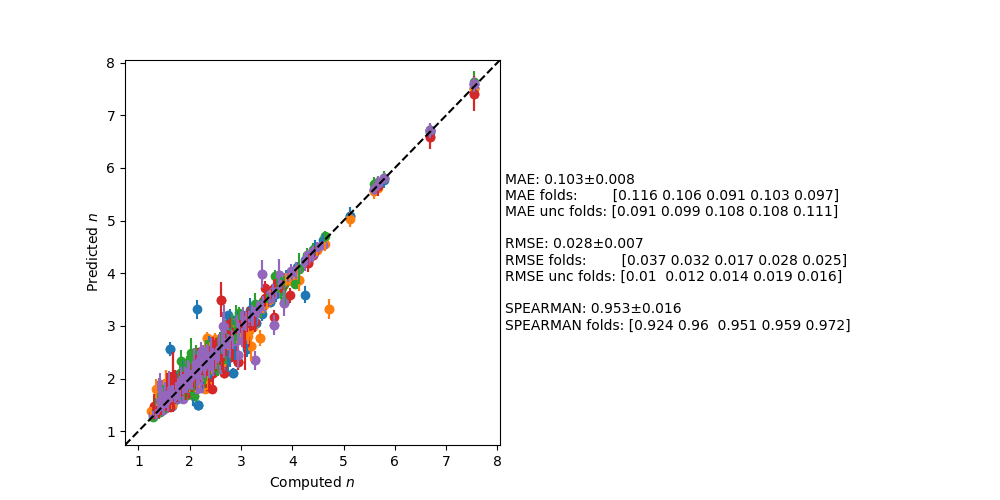

Model already exists!
2024-01-15 21:49:45,597 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55342f1940> object, created with modnet version 0.4.1
1800


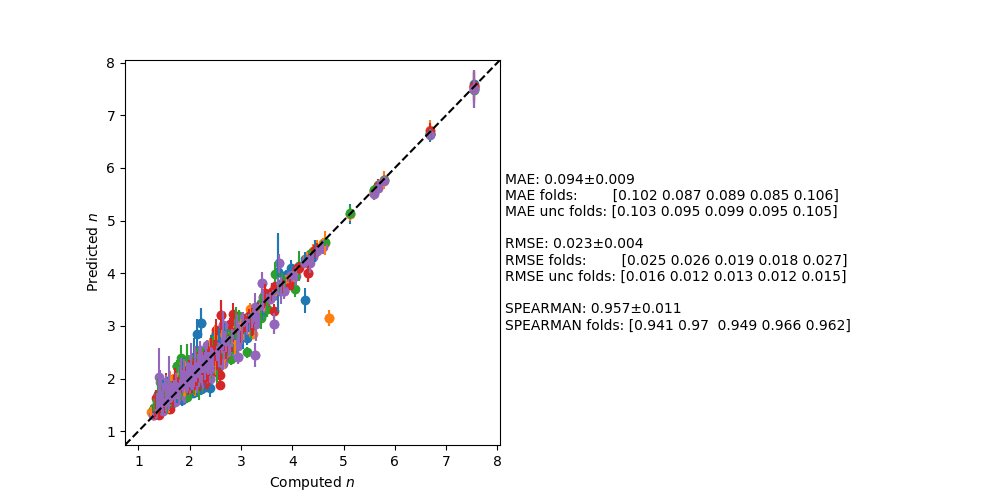

Model already exists!
2024-01-15 21:49:45,939 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55436aedc0> object, created with modnet version 0.4.1
1900


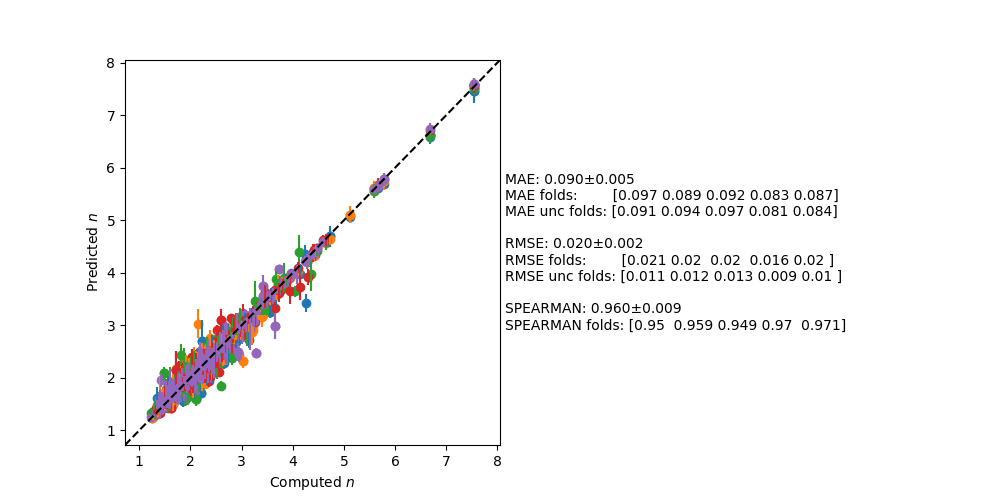

Model already exists!
2024-01-15 21:49:46,266 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5543568bb0> object, created with modnet version 0.4.1
2000


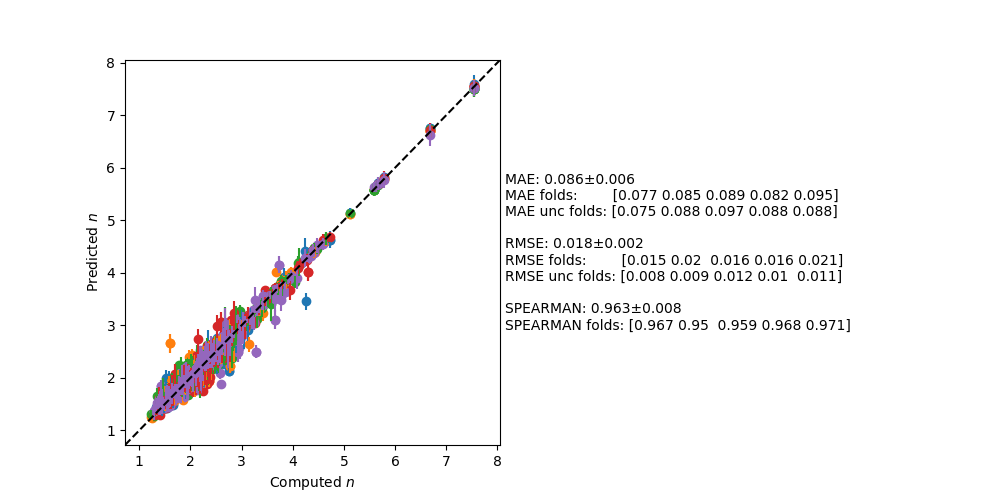

Model already exists!
2024-01-15 21:49:46,538 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f552738a250> object, created with modnet version 0.4.1
2100


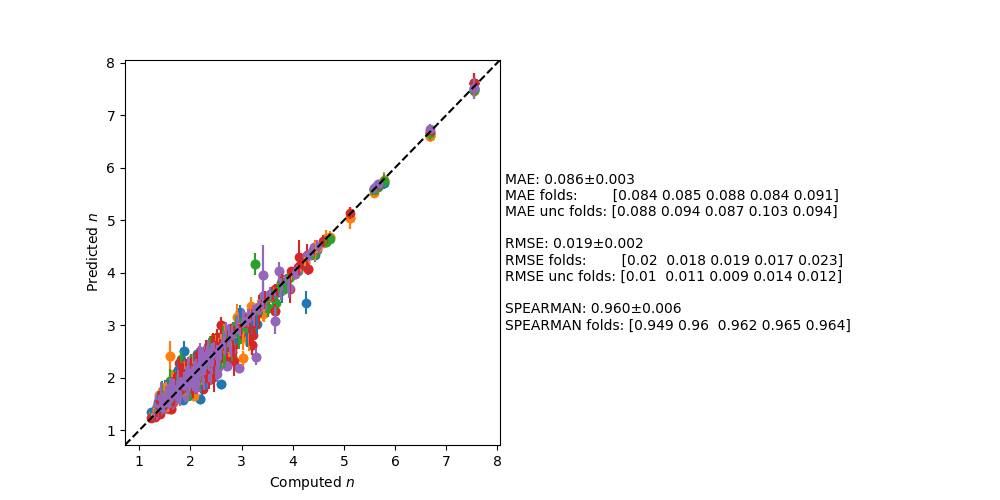

Model already exists!
2024-01-15 21:49:46,887 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55436dd6a0> object, created with modnet version 0.4.1
2200


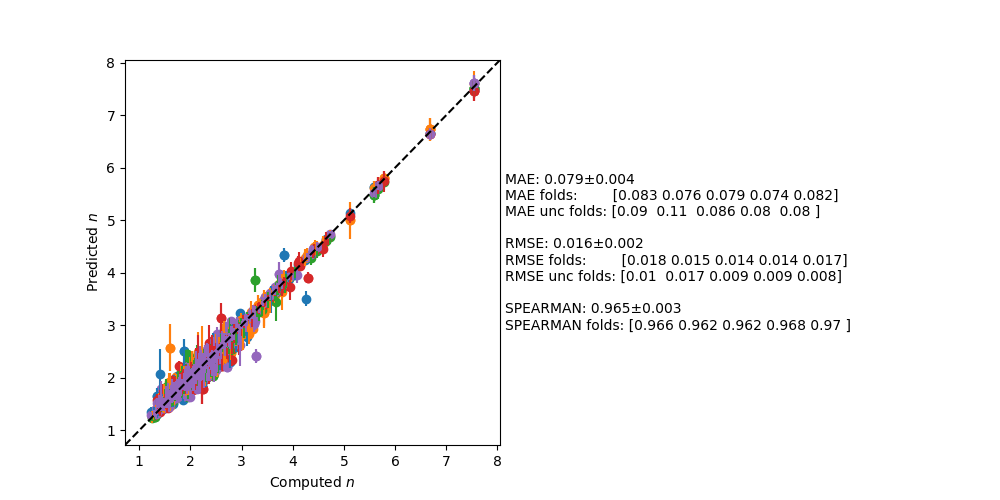

Model already exists!
2024-01-15 21:49:47,337 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553ccdc970> object, created with modnet version 0.4.1
2300


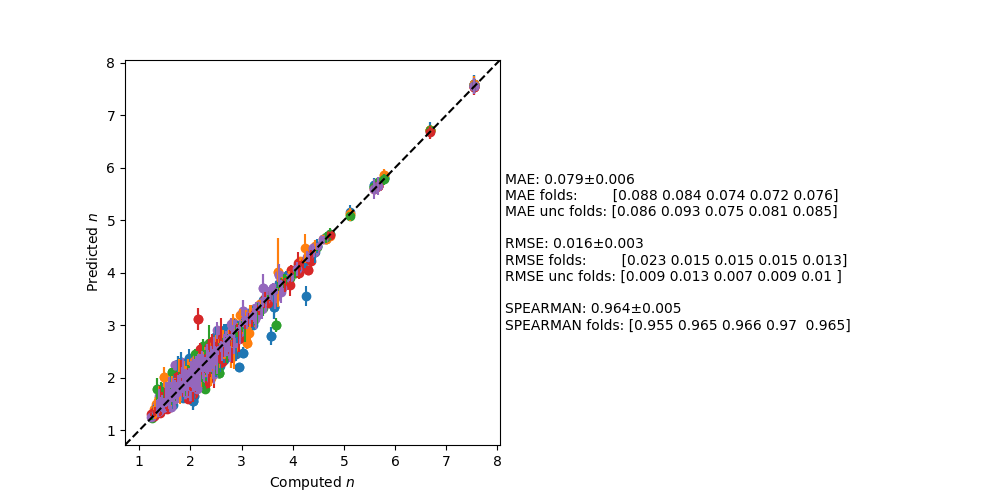

Model already exists!
2024-01-15 21:49:47,725 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5534321be0> object, created with modnet version 0.4.1
2400


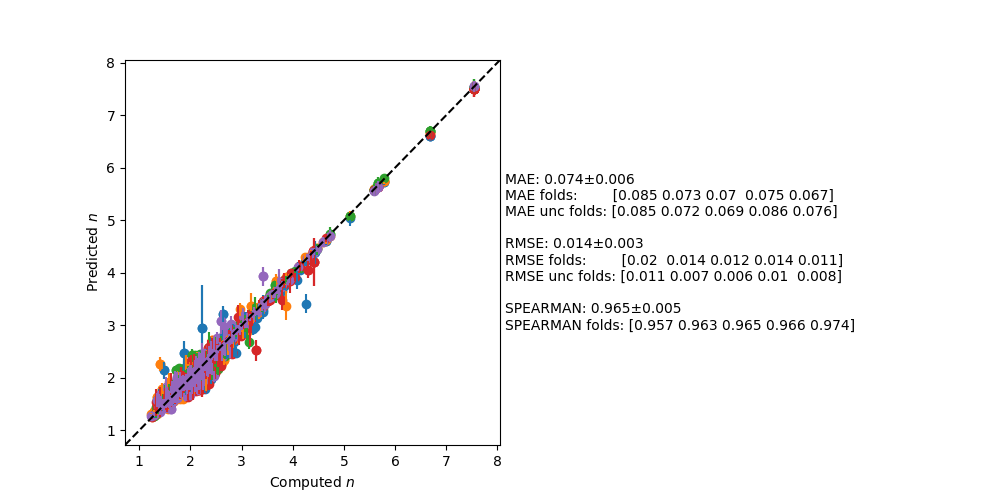

Model already exists!
2024-01-15 21:49:48,078 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55436dd6a0> object, created with modnet version 0.4.1
2500


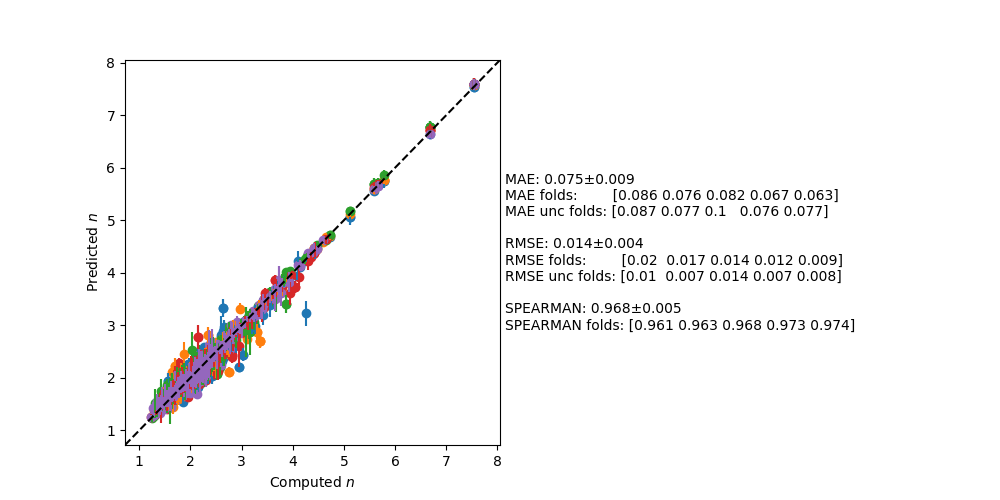

Model already exists!
2024-01-15 21:49:48,415 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f55316d9760> object, created with modnet version 0.4.1
2600


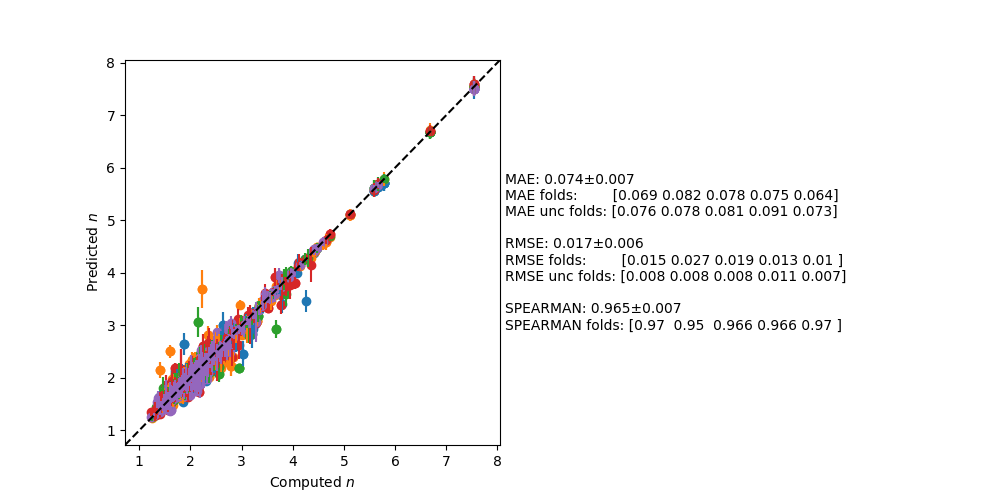

Model already exists!
2024-01-15 21:49:48,768 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f554357f7f0> object, created with modnet version 0.4.1
2700


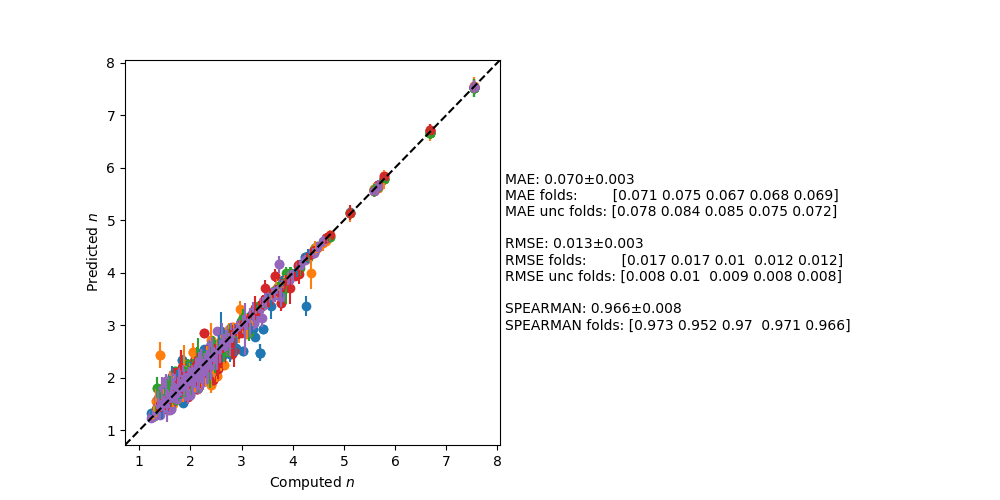

Model already exists!
2024-01-15 21:49:49,111 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553afa8940> object, created with modnet version 0.4.1
2800


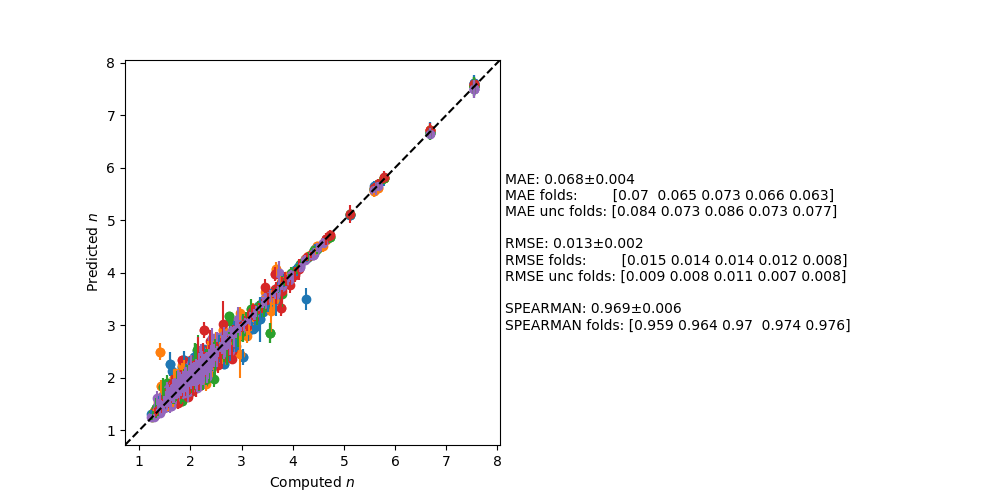

Model already exists!
2024-01-15 21:49:49,430 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553b37f760> object, created with modnet version 0.4.1
2900


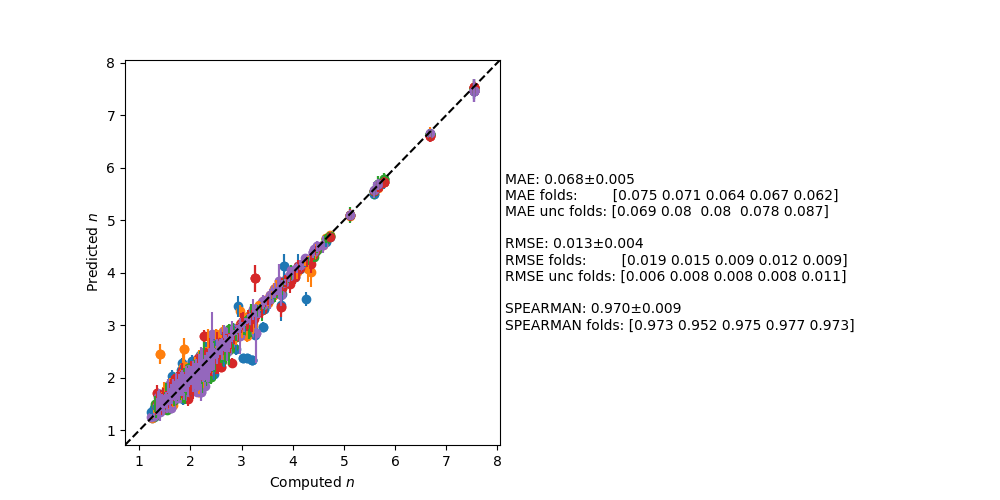

Model already exists!
2024-01-15 21:49:49,800 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553ce0bfa0> object, created with modnet version 0.4.1
3000


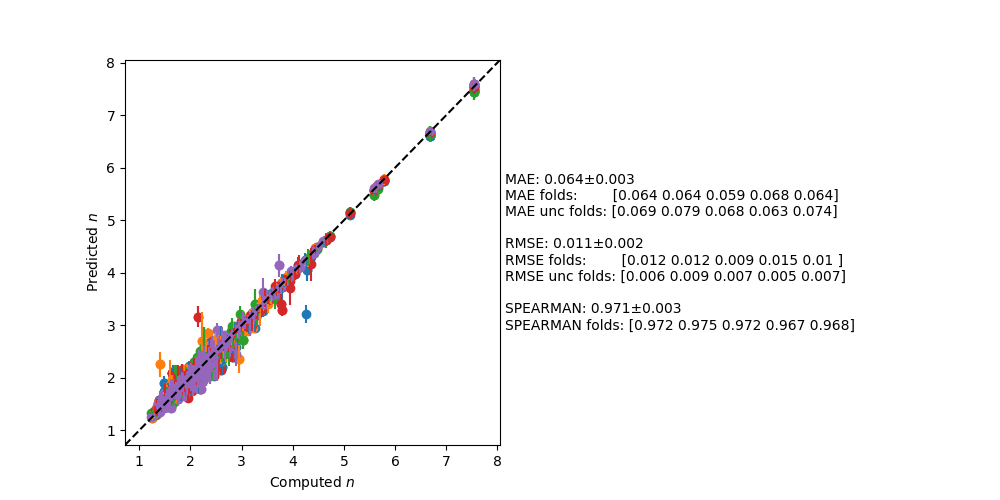

Model already exists!
2024-01-15 21:49:50,189 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f553af5a640> object, created with modnet version 0.4.1
3100
2024-01-15 21:49:50,347 - modnet - INFO - Targets:
2024-01-15 21:49:50,348 - modnet - INFO - 1)refractive_index: regression
2024-01-15 21:49:50,395 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 21:49:50,397 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 21:49:50.844032: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 21:49:50.845906: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 21:49:50.876577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 21:49:50.876640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [01:23<12:30, 41.69s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:33<07:41, 27.13s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:36<04:41, 17.60s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<02:54, 11.61s/it]

8/8 [==============================] - 0s 894us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:50<02:47, 11.94s/it]

8/8 [==============================] - 0s 915us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<02:01,  9.36s/it]

8/8 [==============================] - 0s 954us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:56<01:26,  7.18s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:05<01:23,  7.63s/it]

8/8 [==============================] - 0s 777us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:26<01:57, 11.78s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:32<01:28,  9.89s/it]

8/8 [==============================] - 0s 901us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<01:09,  8.75s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:51<01:11, 10.25s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:10<01:16, 12.82s/it]

8/8 [==============================] - 0s 963us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:13<00:49,  9.89s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:22<00:38,  9.66s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:27<00:24,  8.06s/it]

8/8 [==============================] - 0s 996us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:41<00:19,  9.86s/it]

8/8 [==============================] - 0s 891us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:53<00:10, 10.60s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:56<00:00, 11.84s/it]

8/8 [==============================] - 0s 657us/step
2024-01-15 21:53:47,345 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.105 	ind 2: 0.088 	ind 3: 0.155 	ind 4: 0.556 	ind 5: 0.151 	ind 6: 1.287 	ind 7: 0.288 	ind 8: 0.110 	ind 9: 0.157 	ind 10: 0.086 	ind 11: 0.495 	ind 12: 0.172 	ind 13: 0.087 	ind 14: 0.110 	ind 15: 0.141 	ind 16: 0.556 	ind 17: 0.531 	ind 18: 0.105 	ind 19: 0.143 	
2024-01-15 21:53:47,346 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:19<06:09, 19.45s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:10, 10.56s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:54<05:37, 19.84s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<05:10, 19.39s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<04:14, 16.95s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:37<03:30, 15.06s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:46<02:52, 13.26s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<02:10, 10.86s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:13<02:32, 13.84s/it]

8/8 [==============================] - 0s 982us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:38<02:54, 17.48s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:40<01:55, 12.80s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:35<03:24, 25.58s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:53<02:43, 23.37s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:04<01:57, 19.64s/it]

8/8 [==============================] - 0s 855us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:26<01:41, 20.23s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:01<01:38, 24.60s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:16<01:05, 21.79s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:26<00:36, 18.29s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:44<00:00, 17.21s/it]

8/8 [==============================] - 0s 867us/step
2024-01-15 21:59:31,561 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.099 	ind 2: 0.088 	ind 3: 0.099 	ind 4: 0.130 	ind 5: 0.226 	ind 6: 0.215 	ind 7: 0.201 	ind 8: 0.114 	ind 9: 0.113 	ind 10: 0.140 	ind 11: 0.112 	ind 12: 0.118 	ind 13: 0.109 	ind 14: 0.222 	ind 15: 0.081 	ind 16: 0.096 	ind 17: 0.138 	ind 18: 0.182 	ind 19: 0.142 	
2024-01-15 21:59:31,562 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:29<09:14, 29.19s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:51<07:36, 25.34s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:14<06:48, 24.02s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:14<03:56, 14.81s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:40<04:42, 18.85s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:58<04:17, 18.41s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:02<02:56, 13.55s/it]

8/8 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:11<02:27, 12.27s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:33<02:49, 15.37s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:56<02:56, 17.68s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:21<02:58, 19.80s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:51<03:03, 23.00s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:55<02:01, 17.31s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:22<02:00, 20.00s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:37<01:33, 18.68s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:53<01:10, 17.70s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:24<01:05, 21.80s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:36<00:37, 18.85s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:51<00:17, 17.63s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:18<00:00, 18.91s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 22:05:49,742 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.076 	ind 2: 0.092 	ind 3: 0.171 	ind 4: 0.093 	ind 5: 0.081 	ind 6: 0.108 	ind 7: 0.128 	ind 8: 0.100 	ind 9: 0.099 	ind 10: 0.145 	ind 11: 0.072 	ind 12: 0.696 	ind 13: 0.093 	ind 14: 0.111 	ind 15: 0.100 	ind 16: 0.116 	ind 17: 0.093 	ind 18: 0.093 	ind 19: 0.081 	
2024-01-15 22:05:49,744 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:46<14:39, 46.31s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:53<07:01, 23.40s/it]

8/8 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:05<05:08, 18.15s/it]

8/8 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:39<06:29, 24.32s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:40<03:59, 15.95s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:01<04:07, 17.67s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:03<02:42, 12.48s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:51<04:46, 23.90s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:57<03:20, 18.22s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:29<03:44, 22.41s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:30<02:24, 16.07s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:55<02:29, 18.66s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:11<02:04, 17.80s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:50<02:25, 24.19s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:14<02:01, 24.24s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:58<02:00, 30.16s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:00<01:04, 21.58s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:20<00:42, 21.09s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:37<00:20, 20.03s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:00<00:00, 21.03s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 22:12:50,449 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.085 	ind 2: 0.119 	ind 3: 0.090 	ind 4: 0.086 	ind 5: 0.100 	ind 6: 0.116 	ind 7: 0.090 	ind 8: 0.095 	ind 9: 0.092 	ind 10: 0.089 	ind 11: 0.093 	ind 12: 0.096 	ind 13: 0.079 	ind 14: 0.091 	ind 15: 0.078 	ind 16: 0.086 	ind 17: 0.099 	ind 18: 0.098 	ind 19: 0.083 	
2024-01-15 22:12:50,450 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:36<11:36, 36.66s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:04<09:30, 31.71s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:15<06:14, 22.01s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:57<07:57, 29.84s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:05<05:28, 21.91s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:36<05:50, 25.04s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:38<03:49, 17.68s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:59<03:45, 18.80s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:11<03:02, 16.56s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:32<03:00, 18.02s/it]

8/8 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:43<02:22, 15.84s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:07<02:24, 18.12s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:07<01:29, 12.78s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:45<02:02, 20.39s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:46<01:13, 14.67s/it]

8/8 [==============================] - 0s 963us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:06<01:04, 16.04s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:26<00:52, 17.36s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:36<00:30, 15.03s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:21<00:23, 23.97s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:31<00:00, 19.58s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 22:19:22,166 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.080 	ind 2: 0.097 	ind 3: 0.085 	ind 4: 0.092 	ind 5: 0.094 	ind 6: 0.092 	ind 7: 0.135 	ind 8: 0.107 	ind 9: 0.092 	ind 10: 0.104 	ind 11: 0.085 	ind 12: 0.111 	ind 13: 0.109 	ind 14: 0.089 	ind 15: 0.135 	ind 16: 0.080 	ind 17: 0.115 	ind 18: 0.080 	ind 19: 0.087 	
2024-01-15 22:19:22,167 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:46<14:43, 46.52s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [01:02<08:30, 28.38s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:24<07:14, 25.58s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:35<05:17, 19.84s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:18<07:04, 28.32s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:23<04:45, 20.43s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:49<04:45, 21.96s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:08<04:13, 21.09s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:29<03:53, 21.23s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:33<02:38, 15.82s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:49<02:22, 15.87s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:12<02:23, 17.97s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:15<01:34, 13.47s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:53<02:05, 20.90s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:54<01:14, 14.98s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:07<00:56, 14.21s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:27<00:47, 15.99s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:40<00:30, 15.06s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:59<00:16, 16.22s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:05<00:00, 18.30s/it]

8/8 [==============================] - 0s 862us/step
2024-01-15 22:25:28,194 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.086 	ind 2: 0.097 	ind 3: 0.093 	ind 4: 0.084 	ind 5: 0.084 	ind 6: 0.106 	ind 7: 0.091 	ind 8: 0.082 	ind 9: 0.105 	ind 10: 0.101 	ind 11: 0.122 	ind 12: 0.109 	ind 13: 0.118 	ind 14: 0.082 	ind 15: 0.162 	ind 16: 0.092 	ind 17: 0.109 	ind 18: 0.100 	ind 19: 0.109 	
2024-01-15 22:25:28,195 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 22:25:28,195 - modnet - INFO - Early stopping at generation number 5


2024-01-15 22:25:29,929 - modnet - INFO - Model successfully saved as benchmark/models/model_29_00.pkl!
20/20 [==============================] - 0s 1ms/step
2024-01-15 22:25:30,920 - modnet - INFO - Targets:
2024-01-15 22:25:30,920 - modnet - INFO - 1)refractive_index: regression
2024-01-15 22:25:30,948 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 22:25:30,949 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 22:25:31.294333: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 22:25:31.295837: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:25:31.320319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:25:31.320351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:22, 11.26s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:02,  7.21s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<01:47,  6.70s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:37,  6.50s/it]

8/8 [==============================] - 0s 820us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:32,  6.58s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:26,  6.67s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:01,  5.13s/it]

8/8 [==============================] - 0s 828us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<00:47,  4.34s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:13,  7.38s/it]

8/8 [==============================] - 0s 868us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<01:02,  6.91s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<01:05,  8.17s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<01:03,  9.04s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:42,  7.02s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:28,  5.77s/it]

8/8 [==============================] - 0s 834us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:22,  5.65s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:59<00:19,  6.44s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:09,  4.88s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:11, 11.95s/it]

8/8 [==============================] - 0s 941us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.50s/it]

8/8 [==============================] - 0s 933us/step
2024-01-15 22:28:01,031 - modnet - INFO - Loss per individual: ind 0: 0.251 	ind 1: 0.136 	ind 2: 0.399 	ind 3: 0.622 	ind 4: 0.109 	ind 5: 0.463 	ind 6: 0.171 	ind 7: 0.493 	ind 8: 0.079 	ind 9: 0.622 	ind 10: 0.097 	ind 11: 0.094 	ind 12: 0.141 	ind 13: 0.147 	ind 14: 0.619 	ind 15: 0.187 	ind 16: 0.638 	ind 17: 0.190 	ind 18: 0.118 	ind 19: 0.098 	
2024-01-15 22:28:01,032 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:47, 11.95s/it]

8/8 [==============================] - 0s 926us/step


 10%|██████████                                                                                          | 2/20 [00:32<05:09, 17.21s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<05:12, 18.38s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:12, 12.05s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:26, 13.78s/it]

8/8 [==============================] - 0s 896us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:24, 10.35s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:05,  9.64s/it]

8/8 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<01:49,  9.14s/it]

8/8 [==============================] - 0s 792us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:51<02:15, 12.31s/it]

8/8 [==============================] - 0s 943us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:07<02:16, 13.64s/it]

8/8 [==============================] - 0s 949us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:12<01:38, 10.97s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:18<01:14,  9.37s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:16, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:41<01:01, 10.17s/it]

8/8 [==============================] - 0s 769us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:49<00:48,  9.65s/it]

8/8 [==============================] - 0s 906us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:42, 10.56s/it]

8/8 [==============================] - 0s 963us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:07<00:26,  8.89s/it]

8/8 [==============================] - 0s 896us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:18<00:19,  9.63s/it]

8/8 [==============================] - 0s 924us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:38<00:12, 12.59s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.34s/it]

8/8 [==============================] - 0s 815us/step
2024-01-15 22:31:47,945 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.153 	ind 2: 0.075 	ind 3: 0.097 	ind 4: 0.110 	ind 5: 0.088 	ind 6: 0.089 	ind 7: 0.092 	ind 8: 0.107 	ind 9: 0.113 	ind 10: 0.088 	ind 11: 0.441 	ind 12: 0.124 	ind 13: 0.091 	ind 14: 0.084 	ind 15: 0.079 	ind 16: 0.090 	ind 17: 0.077 	ind 18: 0.106 	ind 19: 0.096 	
2024-01-15 22:31:47,946 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.27s/it]

8/8 [==============================] - 0s 739us/step


 10%|██████████                                                                                          | 2/20 [00:13<01:46,  5.94s/it]

8/8 [==============================] - 0s 768us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:18,  8.15s/it]

8/8 [==============================] - 0s 959us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:51,  6.96s/it]

8/8 [==============================] - 0s 993us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:03,  8.22s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:50,  7.91s/it]

8/8 [==============================] - 0s 930us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:55,  8.92s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:19,  6.65s/it]

8/8 [==============================] - 0s 797us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:40,  9.09s/it]

8/8 [==============================] - 0s 819us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:14,  7.46s/it]

8/8 [==============================] - 0s 875us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:43, 11.51s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<01:11,  8.94s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<01:09,  9.92s/it]

8/8 [==============================] - 0s 885us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:00<00:54,  9.02s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:08<00:42,  8.59s/it]

8/8 [==============================] - 0s 897us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:33,  8.49s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:26,  8.81s/it]

8/8 [==============================] - 0s 942us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:30<00:14,  7.32s/it]

8/8 [==============================] - 0s 1000us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:09,  9.30s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.01s/it]

8/8 [==============================] - 0s 672us/step
2024-01-15 22:34:48,158 - modnet - INFO - Loss per individual: ind 0: 0.089 	ind 1: 0.103 	ind 2: 0.095 	ind 3: 0.090 	ind 4: 0.077 	ind 5: 0.098 	ind 6: 0.076 	ind 7: 0.101 	ind 8: 0.086 	ind 9: 0.101 	ind 10: 0.082 	ind 11: 0.092 	ind 12: 0.084 	ind 13: 0.080 	ind 14: 0.086 	ind 15: 0.098 	ind 16: 0.097 	ind 17: 0.090 	ind 18: 0.086 	ind 19: 0.094 	
2024-01-15 22:34:48,159 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:33, 14.41s/it]

8/8 [==============================] - 0s 774us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:24,  8.01s/it]

8/8 [==============================] - 0s 984us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:49,  9.98s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:51,  6.97s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:58,  7.87s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:33,  6.68s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:34,  7.29s/it]

8/8 [==============================] - 0s 934us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:33,  7.78s/it]

8/8 [==============================] - 0s 937us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:35,  8.64s/it]

8/8 [==============================] - 0s 932us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:11,  7.18s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:17,  8.65s/it]

8/8 [==============================] - 0s 977us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:59,  7.39s/it]

8/8 [==============================] - 0s 865us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<00:58,  8.33s/it]

8/8 [==============================] - 0s 906us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:46,  7.75s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:44,  8.96s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:34,  8.53s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:23,  7.74s/it]

8/8 [==============================] - 0s 931us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:17,  8.87s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:41<00:10, 10.10s/it]

8/8 [==============================] - 0s 786us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.08s/it]

2024-01-15 22:37:29,730 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.090 	ind 2: 0.111 	ind 3: 0.101 	ind 4: 0.107 	ind 5: 0.089 	ind 6: 0.095 	ind 7: 0.098 	ind 8: 0.092 	ind 9: 0.096 	ind 10: 0.090 	ind 11: 0.082 	ind 12: 0.082 	ind 13: 0.090 	ind 14: 0.084 	ind 15: 0.086 	ind 16: 0.104 	ind 17: 0.084 	ind 18: 0.110 	ind 19: 0.089 	
2024-01-15 22:37:29,731 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:04, 16.04s/it]

8/8 [==============================] - 0s 863us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:30,  8.39s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:50, 10.01s/it]

8/8 [==============================] - 0s 941us/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:51,  6.94s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:20,  9.37s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:02,  8.76s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:52,  8.66s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:40,  8.38s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:21<01:40,  9.11s/it]

8/8 [==============================] - 0s 902us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:08,  6.83s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:24,  9.34s/it]

8/8 [==============================] - 0s 814us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:44<01:06,  8.37s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<01:07,  9.70s/it]

8/8 [==============================] - 0s 872us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:51,  8.52s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:45,  9.02s/it]

8/8 [==============================] - 0s 986us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:27,  6.87s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:34<00:32, 10.77s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:35<00:15,  7.78s/it]

8/8 [==============================] - 0s 820us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:47<00:09,  9.02s/it]

8/8 [==============================] - 0s 966us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:52<00:00,  8.64s/it]

8/8 [==============================] - 0s 650us/step
2024-01-15 22:40:22,640 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.105 	ind 2: 0.097 	ind 3: 0.099 	ind 4: 0.101 	ind 5: 0.092 	ind 6: 0.102 	ind 7: 0.106 	ind 8: 0.108 	ind 9: 0.122 	ind 10: 0.089 	ind 11: 0.102 	ind 12: 0.090 	ind 13: 0.108 	ind 14: 0.091 	ind 15: 0.104 	ind 16: 0.114 	ind 17: 0.089 	ind 18: 0.097 	ind 19: 0.104 	
2024-01-15 22:40:22,640 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 22:40:22,641 - modnet - INFO - Early stopping at generation number 4


2024-01-15 22:40:24,162 - modnet - INFO - Model successfully saved as benchmark/models/model_29_01.pkl!
20/20 [==============================] - 0s 733us/step
2024-01-15 22:40:24,999 - modnet - INFO - Targets:
2024-01-15 22:40:24,999 - modnet - INFO - 1)refractive_index: regression
2024-01-15 22:40:25,022 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 22:40:25,024 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 22:40:25.357019: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 22:40:25.358478: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:40:25.382398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:40:25.382430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:51,  9.53s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<01:56,  6.87s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:30,  5.63s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:14,  8.96s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<03:23, 14.55s/it]

8/8 [==============================] - 0s 982us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:11, 10.15s/it]

8/8 [==============================] - 0s 992us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:39,  8.26s/it]

8/8 [==============================] - 0s 833us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<02:00, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:51, 11.11s/it]

8/8 [==============================] - 0s 957us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:21,  9.06s/it]

8/8 [==============================] - 0s 833us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<00:52,  6.58s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:39,  5.68s/it]

8/8 [==============================] - 0s 896us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:24,  4.03s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:21,  4.36s/it]

8/8 [==============================] - 0s 934us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:15,  3.82s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:09,  3.29s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:13,  6.65s/it]

8/8 [==============================] - 0s 980us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:05,  5.02s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.27s/it]

8/8 [==============================] - 0s 857us/step
2024-01-15 22:42:50,592 - modnet - INFO - Loss per individual: ind 0: 0.209 	ind 1: 0.195 	ind 2: 0.195 	ind 3: 0.348 	ind 4: 0.122 	ind 5: 0.123 	ind 6: 0.102 	ind 7: 0.121 	ind 8: 0.619 	ind 9: 0.102 	ind 10: 0.153 	ind 11: 0.816 	ind 12: 0.553 	ind 13: 0.571 	ind 14: 0.576 	ind 15: 0.108 	ind 16: 0.571 	ind 17: 0.081 	ind 18: 0.142 	ind 19: 0.092 	
2024-01-15 22:42:50,593 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:47,  8.83s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:50,  9.47s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:49,  6.43s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:47,  6.70s/it]

8/8 [==============================] - 0s 792us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:31,  6.10s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:01,  4.40s/it]

8/8 [==============================] - 0s 855us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:33,  7.21s/it]

8/8 [==============================] - 0s 782us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:10,  5.89s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:40,  9.14s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:38,  9.90s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:05,  7.25s/it]

8/8 [==============================] - 0s 966us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:13,  9.25s/it]

8/8 [==============================] - 0s 952us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:47,  6.79s/it]

8/8 [==============================] - 0s 946us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<01:06, 11.02s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:38,  7.77s/it]

8/8 [==============================] - 0s 988us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:34,  8.58s/it]

8/8 [==============================] - 0s 884us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:20,  6.81s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:16,  8.10s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:06,  6.14s/it]

8/8 [==============================] - 0s 786us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.72s/it]

8/8 [==============================] - 0s 998us/step
2024-01-15 22:45:24,975 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.085 	ind 2: 0.123 	ind 3: 0.114 	ind 4: 0.104 	ind 5: 0.131 	ind 6: 0.085 	ind 7: 0.099 	ind 8: 0.112 	ind 9: 0.148 	ind 10: 0.197 	ind 11: 0.110 	ind 12: 0.329 	ind 13: 0.156 	ind 14: 0.095 	ind 15: 0.095 	ind 16: 0.109 	ind 17: 0.199 	ind 18: 0.115 	ind 19: 0.114 	
2024-01-15 22:45:24,976 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:50, 12.13s/it]

8/8 [==============================] - 0s 758us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:56,  9.80s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:13,  7.87s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:54,  7.17s/it]

8/8 [==============================] - 0s 772us/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:14,  8.94s/it]

8/8 [==============================] - 0s 892us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:43,  7.41s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<02:05,  9.65s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:30,  7.51s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:47,  9.79s/it]

8/8 [==============================] - 0s 812us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:13,  7.31s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:37<01:26,  9.62s/it]

8/8 [==============================] - 0s 803us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:19, 10.00s/it]

8/8 [==============================] - 0s 843us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:52,  8.81s/it]

8/8 [==============================] - 0s 944us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:35,  7.17s/it]

8/8 [==============================] - 0s 939us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:19<00:36,  9.21s/it]

8/8 [==============================] - 0s 777us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:34<00:32, 10.88s/it]

8/8 [==============================] - 0s 828us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:44<00:21, 10.86s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:51<00:09,  9.62s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:57<00:00,  8.87s/it]

8/8 [==============================] - 0s 862us/step
2024-01-15 22:48:22,455 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.104 	ind 2: 0.087 	ind 3: 0.087 	ind 4: 0.147 	ind 5: 0.090 	ind 6: 0.144 	ind 7: 0.105 	ind 8: 0.086 	ind 9: 0.113 	ind 10: 0.087 	ind 11: 0.101 	ind 12: 0.097 	ind 13: 0.093 	ind 14: 0.109 	ind 15: 0.095 	ind 16: 0.091 	ind 17: 0.089 	ind 18: 0.101 	ind 19: 0.089 	
2024-01-15 22:48:22,456 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.29s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:53,  6.28s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:28,  8.73s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:45,  6.57s/it]

8/8 [==============================] - 0s 862us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:45, 11.02s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:33, 10.93s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:47,  8.26s/it]

8/8 [==============================] - 0s 698us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:52,  9.39s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:16,  7.00s/it]

8/8 [==============================] - 0s 949us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:17,  7.75s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<00:57,  6.41s/it]

8/8 [==============================] - 0s 935us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:11,  8.96s/it]

8/8 [==============================] - 0s 876us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:46,  6.63s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:52,  8.73s/it]

8/8 [==============================] - 0s 856us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:41,  8.23s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:35,  9.00s/it]

8/8 [==============================] - 0s 873us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:23<00:12,  6.06s/it]

8/8 [==============================] - 0s 958us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:08,  8.41s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.08s/it]

8/8 [==============================] - 0s 952us/step
2024-01-15 22:51:04,187 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.128 	ind 2: 0.122 	ind 3: 0.128 	ind 4: 0.106 	ind 5: 0.172 	ind 6: 0.145 	ind 7: 0.133 	ind 8: 0.129 	ind 9: 0.135 	ind 10: 0.131 	ind 11: 0.144 	ind 12: 0.141 	ind 13: 0.119 	ind 14: 0.267 	ind 15: 0.144 	ind 16: 0.111 	ind 17: 0.156 	ind 18: 0.148 	ind 19: 0.133 	
2024-01-15 22:51:04,188 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 22:51:04,189 - modnet - INFO - Early stopping at generation number 3


2024-01-15 22:51:05,681 - modnet - INFO - Model successfully saved as benchmark/models/model_29_02.pkl!
20/20 [==============================] - 0s 925us/step
2024-01-15 22:51:06,528 - modnet - INFO - Targets:
2024-01-15 22:51:06,529 - modnet - INFO - 1)refractive_index: regression
2024-01-15 22:51:06,553 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 22:51:06,555 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 22:51:06.891295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 22:51:06.892875: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:51:06.916694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:51:06.916726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 926us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:14, 10.83s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:21,  8.30s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:42,  6.39s/it]

8/8 [==============================] - 0s 933us/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:18,  9.27s/it]

8/8 [==============================] - 0s 839us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:04,  8.90s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:09, 10.00s/it]

8/8 [==============================] - 0s 815us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:40,  8.34s/it]

8/8 [==============================] - 0s 930us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<02:08, 11.66s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:46, 10.61s/it]

8/8 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:27,  9.71s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:55<01:13,  9.16s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<01:05,  9.39s/it]

8/8 [==============================] - 0s 905us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:03, 10.62s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:21<00:40,  8.10s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:23,  5.77s/it]

8/8 [==============================] - 0s 861us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:15,  5.28s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:41<00:16,  8.41s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:54<00:09,  9.77s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:57<00:00,  8.88s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 22:54:04,289 - modnet - INFO - Loss per individual: ind 0: 0.510 	ind 1: 0.105 	ind 2: 0.536 	ind 3: 0.330 	ind 4: 0.230 	ind 5: 0.094 	ind 6: 0.315 	ind 7: 0.132 	ind 8: 0.187 	ind 9: 0.150 	ind 10: 0.098 	ind 11: 0.108 	ind 12: 0.232 	ind 13: 0.076 	ind 14: 0.191 	ind 15: 0.509 	ind 16: 0.510 	ind 17: 0.100 	ind 18: 0.115 	ind 19: 0.525 	
2024-01-15 22:54:04,289 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<04:46, 15.06s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<05:30, 18.37s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:54, 13.80s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<03:51, 14.47s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:23,  9.58s/it]

8/8 [==============================] - 0s 748us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:39, 11.42s/it]

8/8 [==============================] - 0s 909us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<01:54,  8.84s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:13, 11.11s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<01:56, 10.58s/it]

8/8 [==============================] - 0s 657us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<02:06, 12.65s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:02<01:20,  8.99s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:25<01:47, 13.41s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:26<01:06,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:46<01:16, 12.74s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<01:05, 13.14s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:42, 14.02s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:19,  9.90s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:42<00:11, 11.77s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.88s/it]

8/8 [==============================] - 0s 574us/step
2024-01-15 22:58:01,886 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.091 	ind 2: 0.095 	ind 3: 0.118 	ind 4: 0.107 	ind 5: 0.104 	ind 6: 0.102 	ind 7: 0.216 	ind 8: 0.120 	ind 9: 0.088 	ind 10: 0.114 	ind 11: 0.094 	ind 12: 0.108 	ind 13: 0.104 	ind 14: 0.095 	ind 15: 0.109 	ind 16: 0.093 	ind 17: 0.099 	ind 18: 0.220 	ind 19: 0.117 	
2024-01-15 22:58:01,887 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:19<06:04, 19.17s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:11, 13.98s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:15, 15.06s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:05<04:32, 17.04s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:13<03:26, 13.75s/it]

8/8 [==============================] - 0s 803us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<03:26, 14.72s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:53<03:47, 17.47s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:01<02:51, 14.31s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:11<02:22, 12.99s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:40<03:01, 18.16s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:42<01:58, 13.19s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:57<01:48, 13.56s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:01<01:15, 10.81s/it]

8/8 [==============================] - 0s 987us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:07<00:55,  9.27s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:24<00:57, 11.49s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:28<00:37,  9.47s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:42<00:32, 10.84s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:57<00:23, 11.86s/it]

8/8 [==============================] - 0s 941us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:09,  9.60s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:12<00:00, 12.62s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:02:14,283 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.109 	ind 2: 0.121 	ind 3: 0.105 	ind 4: 0.135 	ind 5: 0.096 	ind 6: 0.096 	ind 7: 0.096 	ind 8: 0.101 	ind 9: 0.093 	ind 10: 0.131 	ind 11: 0.103 	ind 12: 0.099 	ind 13: 0.125 	ind 14: 0.095 	ind 15: 0.111 	ind 16: 0.098 	ind 17: 0.140 	ind 18: 0.114 	ind 19: 0.119 	
2024-01-15 23:02:14,283 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:13, 19.67s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:51,  9.51s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:34, 12.63s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:13,  8.33s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:26,  9.75s/it]

8/8 [==============================] - 0s 843us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:13,  9.56s/it]

8/8 [==============================] - 0s 831us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:25, 11.20s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:36, 13.00s/it]

8/8 [==============================] - 0s 832us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:39,  9.07s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<02:13, 13.31s/it]

8/8 [==============================] - 0s 989us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:37, 10.88s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:47, 13.47s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:13, 10.47s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:44<01:19, 13.26s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:47<00:51, 10.21s/it]

8/8 [==============================] - 0s 953us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:18<01:06, 16.54s/it]

8/8 [==============================] - 0s 791us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:22<00:37, 12.58s/it]

8/8 [==============================] - 0s 977us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:31, 15.72s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:45<00:11, 11.12s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.40s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:06:22,330 - modnet - INFO - Loss per individual: ind 0: 0.091 	ind 1: 0.089 	ind 2: 0.102 	ind 3: 0.110 	ind 4: 0.090 	ind 5: 0.123 	ind 6: 0.097 	ind 7: 0.086 	ind 8: 0.102 	ind 9: 0.087 	ind 10: 0.106 	ind 11: 0.084 	ind 12: 0.088 	ind 13: 0.094 	ind 14: 0.101 	ind 15: 0.097 	ind 16: 0.088 	ind 17: 0.086 	ind 18: 0.105 	ind 19: 0.099 	
2024-01-15 23:06:22,331 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 23:06:22,331 - modnet - INFO - Early stopping at generation number 3


2024-01-15 23:06:23,825 - modnet - INFO - Model successfully saved as benchmark/models/model_29_03.pkl!
20/20 [==============================] - 0s 824us/step
2024-01-15 23:06:24,679 - modnet - INFO - Targets:
2024-01-15 23:06:24,680 - modnet - INFO - 1)refractive_index: regression
2024-01-15 23:06:24,704 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 23:06:24,706 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 23:06:25.039300: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 23:06:25.041316: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 23:06:25.065868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 23:06:25.065900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 986us/step


 10%|██████████                                                                                          | 2/20 [00:20<03:00, 10.01s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:17,  8.06s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:21,  5.07s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:36,  6.44s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:12,  5.19s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:45,  8.11s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<02:21, 11.78s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:31,  8.36s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:07,  6.70s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:54,  6.06s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:45,  5.71s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:52,  7.56s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:56,  9.39s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:38,  7.65s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:41, 10.40s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:24,  8.03s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:13,  6.90s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:05,  5.40s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.12s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:09:07,089 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.122 	ind 2: 0.124 	ind 3: 0.398 	ind 4: 0.134 	ind 5: 0.113 	ind 6: 0.093 	ind 7: 0.112 	ind 8: 0.089 	ind 9: 0.513 	ind 10: 0.125 	ind 11: 0.271 	ind 12: 0.079 	ind 13: 0.159 	ind 14: 0.097 	ind 15: 0.134 	ind 16: 0.106 	ind 17: 0.098 	ind 18: 0.514 	ind 19: 0.067 	
2024-01-15 23:09:07,089 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:27<08:42, 27.48s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<03:32, 11.79s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:56, 13.89s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<03:42, 13.92s/it]

8/8 [==============================] - 0s 837us/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:17, 13.16s/it]

8/8 [==============================] - 0s 913us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:20<02:47, 11.95s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<03:17, 15.23s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<02:44, 13.69s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:05<02:28, 13.48s/it]

8/8 [==============================] - 0s 992us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:14, 13.41s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:27<01:46, 11.86s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:42<01:42, 12.87s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:53<01:26, 12.33s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:12<01:26, 14.38s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<00:58, 11.75s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<00:47, 11.98s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:36<00:30, 10.17s/it]

8/8 [==============================] - 0s 976us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:46<00:20, 10.21s/it]

8/8 [==============================] - 0s 837us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:12, 12.54s/it]

8/8 [==============================] - 0s 886us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:19<00:00, 12.96s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:13:26,351 - modnet - INFO - Loss per individual: ind 0: 0.083 	ind 1: 0.094 	ind 2: 0.088 	ind 3: 0.116 	ind 4: 0.123 	ind 5: 0.092 	ind 6: 0.094 	ind 7: 0.091 	ind 8: 0.084 	ind 9: 0.199 	ind 10: 0.082 	ind 11: 0.159 	ind 12: 0.122 	ind 13: 0.081 	ind 14: 0.086 	ind 15: 0.090 	ind 16: 0.128 	ind 17: 0.103 	ind 18: 0.078 	ind 19: 0.077 	
2024-01-15 23:13:26,352 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:18<05:53, 18.61s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<05:25, 18.09s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:54<05:05, 17.97s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:14<05:01, 18.85s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:29<04:22, 17.53s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:53<03:22, 15.56s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:07<03:00, 15.08s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:23<02:50, 15.48s/it]

8/8 [==============================] - 0s 987us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:26<01:56, 11.66s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:53<02:27, 16.37s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:06<02:02, 15.33s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:10<01:23, 11.86s/it]

8/8 [==============================] - 0s 930us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:29<01:24, 14.04s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:39<01:02, 12.58s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:46<00:44, 11.15s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:09<00:43, 14.47s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:15<00:24, 12.12s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:34<00:14, 14.09s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:49<00:00, 14.46s/it]

8/8 [==============================] - 0s 856us/step
2024-01-15 23:18:15,701 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.087 	ind 2: 0.107 	ind 3: 0.098 	ind 4: 0.089 	ind 5: 0.088 	ind 6: 0.074 	ind 7: 0.088 	ind 8: 0.079 	ind 9: 0.202 	ind 10: 0.096 	ind 11: 0.077 	ind 12: 0.118 	ind 13: 0.085 	ind 14: 0.088 	ind 15: 0.105 	ind 16: 0.066 	ind 17: 0.087 	ind 18: 0.090 	ind 19: 0.080 	
2024-01-15 23:18:15,701 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:28<09:00, 28.43s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:43<06:09, 20.53s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:05<06:03, 21.39s/it]

8/8 [==============================] - 0s 924us/step


 20%|████████████████████                                                                                | 4/20 [01:26<05:36, 21.01s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<04:23, 17.60s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:51<03:46, 16.15s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:09<03:40, 16.98s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:25<03:19, 16.64s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:49<03:27, 18.85s/it]

8/8 [==============================] - 0s 865us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:01<02:48, 16.86s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:09<02:06, 14.08s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:22<01:50, 13.84s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:31<01:26, 12.31s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:48<01:22, 13.72s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:13<01:25, 17.17s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:24<01:00, 15.16s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:35<00:41, 13.89s/it]

8/8 [==============================] - 0s 890us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:08<00:39, 19.68s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:24<00:18, 18.51s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:54<00:00, 17.73s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:24:10,461 - modnet - INFO - Loss per individual: ind 0: 0.080 	ind 1: 0.083 	ind 2: 0.112 	ind 3: 0.079 	ind 4: 0.098 	ind 5: 0.133 	ind 6: 0.090 	ind 7: 0.109 	ind 8: 0.118 	ind 9: 0.097 	ind 10: 0.094 	ind 11: 0.094 	ind 12: 0.106 	ind 13: 0.085 	ind 14: 0.128 	ind 15: 0.086 	ind 16: 0.099 	ind 17: 0.080 	ind 18: 0.078 	ind 19: 0.080 	
2024-01-15 23:24:10,461 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:17<05:41, 17.99s/it]

8/8 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:28<04:00, 13.34s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<02:58, 10.50s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:05, 11.59s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:23,  9.54s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:57, 12.65s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:31<03:09, 14.55s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<03:32, 17.69s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:10<03:03, 16.68s/it]

8/8 [==============================] - 0s 817us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:46<03:48, 22.81s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:49<02:30, 16.69s/it]

8/8 [==============================] - 0s 811us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:15<02:34, 19.35s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:28<02:01, 17.38s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:54<02:00, 20.00s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:58<01:16, 15.21s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:10<00:57, 14.47s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:12<00:32, 10.68s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:36<00:29, 14.56s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:51<00:14, 14.77s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:05<00:00, 15.26s/it]

8/8 [==============================] - 0s 988us/step
2024-01-15 23:29:15,818 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.090 	ind 2: 0.233 	ind 3: 0.109 	ind 4: 0.129 	ind 5: 0.075 	ind 6: 0.066 	ind 7: 0.080 	ind 8: 0.083 	ind 9: 0.069 	ind 10: 0.086 	ind 11: 0.078 	ind 12: 0.071 	ind 13: 0.093 	ind 14: 0.095 	ind 15: 0.097 	ind 16: 0.113 	ind 17: 0.079 	ind 18: 0.080 	ind 19: 0.081 	
2024-01-15 23:29:15,819 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:15<04:58, 15.71s/it]

8/8 [==============================] - 0s 933us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:40, 15.57s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:17, 15.18s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<03:55, 14.71s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<04:03, 16.22s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<02:49, 12.12s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<03:30, 16.22s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:56<02:46, 13.89s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:12<02:40, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:45<03:22, 20.23s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:17<03:33, 23.74s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:36<02:58, 22.36s/it]

8/8 [==============================] - 0s 994us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:51<02:21, 20.28s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:02<01:43, 17.22s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:26<01:36, 19.31s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:28<00:56, 14.05s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:17<01:14, 24.70s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:19<00:35, 17.81s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:42<00:19, 19.55s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:50<00:00, 17.54s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:35:06,659 - modnet - INFO - Loss per individual: ind 0: 0.076 	ind 1: 0.109 	ind 2: 0.076 	ind 3: 0.127 	ind 4: 0.077 	ind 5: 0.098 	ind 6: 0.083 	ind 7: 0.102 	ind 8: 0.096 	ind 9: 0.074 	ind 10: 0.075 	ind 11: 0.063 	ind 12: 0.080 	ind 13: 0.105 	ind 14: 0.090 	ind 15: 0.091 	ind 16: 0.077 	ind 17: 0.079 	ind 18: 0.089 	ind 19: 0.081 	
2024-01-15 23:35:06,660 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:20<06:34, 20.76s/it]

8/8 [==============================] - 0s 905us/step


 10%|██████████                                                                                          | 2/20 [00:32<04:37, 15.40s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:07, 11.03s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:15<05:44, 21.53s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:31, 14.09s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:48<04:43, 20.25s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:50<03:05, 14.25s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:23<03:59, 19.96s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:25<02:38, 14.39s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:44<02:40, 16.06s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:51<01:58, 13.19s/it]

8/8 [==============================] - 0s 979us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:16<02:13, 16.69s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:31<01:54, 16.34s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:43<01:28, 14.79s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:01<01:19, 15.97s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:11<00:56, 14.16s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:24<00:40, 13.65s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:47<00:33, 16.53s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:58<00:14, 14.96s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:10<00:00, 15.53s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:40:17,353 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.135 	ind 2: 0.106 	ind 3: 0.094 	ind 4: 0.093 	ind 5: 0.084 	ind 6: 0.092 	ind 7: 0.093 	ind 8: 0.086 	ind 9: 0.096 	ind 10: 0.098 	ind 11: 0.098 	ind 12: 0.094 	ind 13: 0.096 	ind 14: 0.090 	ind 15: 0.124 	ind 16: 0.104 	ind 17: 0.094 	ind 18: 0.086 	ind 19: 0.086 	
2024-01-15 23:40:17,354 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:21, 16.91s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:42<06:37, 22.06s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:04<06:11, 21.85s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:15<04:44, 17.76s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:34<04:34, 18.31s/it]

8/8 [==============================] - 0s 939us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<03:11, 13.71s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<03:02, 14.02s/it]

8/8 [==============================] - 0s 881us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:20<03:35, 17.94s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:22<02:21, 12.87s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:44<02:37, 15.74s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:17<03:08, 20.92s/it]

8/8 [==============================] - 0s 982us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:21<02:07, 15.93s/it]

8/8 [==============================] - 0s 982us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:39<01:54, 16.43s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:47<01:22, 13.79s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<01:02, 12.46s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:15<00:58, 14.50s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:31<00:44, 14.94s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:36<00:23, 11.88s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:07<00:17, 17.56s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:14<00:00, 15.74s/it]

8/8 [==============================] - 0s 832us/step
2024-01-15 23:45:32,261 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.330 	ind 2: 0.091 	ind 3: 0.095 	ind 4: 0.088 	ind 5: 0.104 	ind 6: 0.107 	ind 7: 0.090 	ind 8: 0.135 	ind 9: 0.117 	ind 10: 0.113 	ind 11: 0.091 	ind 12: 0.091 	ind 13: 0.098 	ind 14: 0.106 	ind 15: 0.102 	ind 16: 0.096 	ind 17: 0.123 	ind 18: 0.089 	ind 19: 0.085 	
2024-01-15 23:45:32,262 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:21<06:50, 21.59s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:39<05:47, 19.32s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:16, 15.08s/it]

8/8 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:08<04:27, 16.70s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:17<03:29, 13.96s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<03:51, 16.53s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:21<03:47, 18.93s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:39<03:25, 18.65s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:51<02:46, 16.63s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:09<02:34, 17.22s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:25<02:14, 16.78s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:26<01:24, 12.02s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:43<01:20, 13.37s/it]

8/8 [==============================] - 0s 895us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:58<01:09, 13.97s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:06<00:48, 12.17s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:46<01:01, 20.48s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:59<00:36, 18.29s/it]

8/8 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:05<00:14, 14.65s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:17<00:00, 15.88s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 23:50:49,996 - modnet - INFO - Loss per individual: ind 0: 0.085 	ind 1: 0.090 	ind 2: 0.091 	ind 3: 0.139 	ind 4: 0.093 	ind 5: 0.093 	ind 6: 0.097 	ind 7: 0.094 	ind 8: 0.082 	ind 9: 0.111 	ind 10: 0.089 	ind 11: 0.146 	ind 12: 0.098 	ind 13: 0.093 	ind 14: 0.108 	ind 15: 0.091 	ind 16: 0.092 	ind 17: 0.087 	ind 18: 0.124 	ind 19: 0.125 	
2024-01-15 23:50:49,997 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 23:50:49,997 - modnet - INFO - Early stopping at generation number 8


2024-01-15 23:50:51,982 - modnet - INFO - Model successfully saved as benchmark/models/model_29_04.pkl!
20/20 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-15 23:50:53,015 - modnet - INFO - Targets:
2024-01-15 23:50:53,016 - modnet - INFO - 1)refractive_index: regression
2024-01-15 23:50:53,042 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 23:50:53,044 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 23:50:53.410657: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 23:50:53.412123: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 23:50:53.437070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 23:50:53.437102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

10/10 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:12, 14.05s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:11, 11.29s/it]

10/10 [==============================] - 0s 794us/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:37, 13.61s/it]

10/10 [==============================] - 0s 917us/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:37, 14.47s/it]

10/10 [==============================] - 0s 882us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<03:33, 15.26s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:43<03:17, 15.23s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:08, 10.67s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<01:35,  8.67s/it]

10/10 [==============================] - 0s 941us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<01:25,  8.60s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<00:54,  6.10s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:17,  9.63s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:23<01:04,  9.22s/it]

10/10 [==============================] - 0s 729us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:01, 10.30s/it]

10/10 [==============================] - 0s 914us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<00:39,  7.90s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:28,  7.16s/it]

10/10 [==============================] - 0s 865us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:28,  9.51s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:22, 11.23s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:15<00:08,  8.13s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:56<00:00, 11.82s/it]

10/10 [==============================] - 0s 931us/step
2024-01-15 23:54:49,441 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.078 	ind 2: 0.237 	ind 3: 0.107 	ind 4: 0.092 	ind 5: 0.108 	ind 6: 0.081 	ind 7: 0.086 	ind 8: 0.393 	ind 9: 0.238 	ind 10: 0.131 	ind 11: 0.232 	ind 12: 0.122 	ind 13: 0.144 	ind 14: 0.159 	ind 15: 0.134 	ind 16: 0.107 	ind 17: 0.078 	ind 18: 0.127 	ind 19: 0.117 	
2024-01-15 23:54:49,442 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:44, 11.82s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:44, 12.48s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:15, 11.47s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:44, 10.28s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:13,  8.89s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:39,  7.13s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<03:14, 14.96s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:17, 11.47s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:18, 12.55s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:38,  9.84s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:28,  9.81s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:28, 11.12s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:31, 13.05s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:08, 11.50s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<01:05, 13.01s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:42, 10.65s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:32, 10.68s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:18,  9.23s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:26<00:10, 10.02s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.67s/it]

10/10 [==============================] - 0s 927us/step
2024-01-15 23:59:03,000 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.107 	ind 2: 0.125 	ind 3: 0.095 	ind 4: 0.105 	ind 5: 0.358 	ind 6: 0.137 	ind 7: 0.099 	ind 8: 0.082 	ind 9: 0.087 	ind 10: 0.083 	ind 11: 0.094 	ind 12: 0.087 	ind 13: 0.085 	ind 14: 0.074 	ind 15: 0.075 	ind 16: 0.127 	ind 17: 0.106 	ind 18: 0.122 	ind 19: 0.127 	
2024-01-15 23:59:03,001 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:24<07:47, 24.58s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<03:51, 12.84s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:19, 15.26s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<02:42, 10.14s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:48, 11.20s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:28, 10.57s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<01:38,  7.54s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<02:07, 10.60s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:24,  7.66s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:29,  8.95s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<00:56,  6.28s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:06<01:31, 11.40s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<00:56,  8.11s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<01:12, 12.10s/it]

10/10 [==============================] - 0s 915us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<01:06, 13.36s/it]

10/10 [==============================] - 0s 981us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:57, 14.47s/it]

10/10 [==============================] - 0s 899us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:06<00:34, 11.48s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:24, 12.47s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:11, 11.09s/it]

10/10 [==============================] - 0s 972us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.85s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-16 00:02:40,103 - modnet - INFO - Loss per individual: ind 0: 0.080 	ind 1: 0.086 	ind 2: 0.088 	ind 3: 0.082 	ind 4: 0.327 	ind 5: 0.081 	ind 6: 0.145 	ind 7: 0.075 	ind 8: 0.173 	ind 9: 0.084 	ind 10: 0.131 	ind 11: 0.078 	ind 12: 0.074 	ind 13: 0.098 	ind 14: 0.118 	ind 15: 0.080 	ind 16: 0.087 	ind 17: 0.133 	ind 18: 0.100 	ind 19: 0.088 	
2024-01-16 00:02:40,104 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:48, 18.33s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:12, 10.69s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:30, 12.36s/it]

10/10 [==============================] - 0s 923us/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:44, 10.28s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:44, 10.98s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:00,  8.60s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:39, 12.25s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:47,  8.97s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:43,  9.37s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:07,  6.79s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<00:59,  6.56s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:27, 10.98s/it]

10/10 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:56,  9.35s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:42,  8.53s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:31,  7.81s/it]

10/10 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:34, 11.42s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:19,  9.80s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:12, 12.71s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.87s/it]

10/10 [==============================] - 0s 921us/step
2024-01-16 00:05:57,525 - modnet - INFO - Loss per individual: ind 0: 0.082 	ind 1: 0.081 	ind 2: 0.104 	ind 3: 0.112 	ind 4: 0.169 	ind 5: 0.088 	ind 6: 0.074 	ind 7: 0.103 	ind 8: 0.099 	ind 9: 0.181 	ind 10: 0.156 	ind 11: 0.152 	ind 12: 0.075 	ind 13: 0.073 	ind 14: 0.089 	ind 15: 0.157 	ind 16: 0.075 	ind 17: 0.087 	ind 18: 0.070 	ind 19: 0.085 	
2024-01-16 00:05:57,526 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:32<10:20, 32.65s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:04, 13.58s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:12, 14.83s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<02:44, 10.28s/it]

10/10 [==============================] - 0s 918us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:39, 10.65s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<01:54,  8.15s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<02:18, 10.64s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<01:42,  8.57s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:07, 11.56s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:34,  9.50s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:54, 12.69s/it]

10/10 [==============================] - 0s 829us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:14,  9.35s/it]

10/10 [==============================] - 0s 875us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:26, 12.37s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:34<00:57,  9.63s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<00:54, 10.87s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:34,  8.64s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:07<00:32, 10.94s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:19,  9.71s/it]

10/10 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:45<00:15, 15.93s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.59s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-16 00:09:49,351 - modnet - INFO - Loss per individual: ind 0: 0.089 	ind 1: 0.088 	ind 2: 0.091 	ind 3: 0.085 	ind 4: 0.112 	ind 5: 0.115 	ind 6: 0.069 	ind 7: 0.092 	ind 8: 0.080 	ind 9: 0.092 	ind 10: 0.072 	ind 11: 0.090 	ind 12: 0.087 	ind 13: 0.071 	ind 14: 0.079 	ind 15: 0.082 	ind 16: 0.077 	ind 17: 0.065 	ind 18: 0.065 	ind 19: 0.056 	
2024-01-16 00:09:49,352 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<06:00, 18.95s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:23, 11.29s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:43, 13.13s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:46, 10.39s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:44, 10.98s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:10,  9.32s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<02:02,  9.44s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:39,  8.32s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<02:04, 11.35s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:56, 11.68s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<02:04, 13.84s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:18<01:39, 12.43s/it]

10/10 [==============================] - 0s 818us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:34<01:33, 13.38s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<01:02, 10.35s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<01:02, 12.59s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:01<00:43, 10.79s/it]

10/10 [==============================] - 0s 888us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:32, 10.85s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:15<00:16,  8.36s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:34<00:11, 11.66s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:41<00:00, 11.06s/it]

10/10 [==============================] - 0s 941us/step
2024-01-16 00:13:30,562 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.124 	ind 2: 0.083 	ind 3: 0.070 	ind 4: 0.078 	ind 5: 0.093 	ind 6: 0.089 	ind 7: 0.124 	ind 8: 0.095 	ind 9: 0.080 	ind 10: 0.079 	ind 11: 0.075 	ind 12: 0.088 	ind 13: 0.070 	ind 14: 0.079 	ind 15: 0.158 	ind 16: 0.079 	ind 17: 0.190 	ind 18: 0.084 	ind 19: 0.088 	
2024-01-16 00:13:30,562 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:16<05:17, 16.70s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:20, 11.15s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:42,  9.53s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:14, 12.16s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:46, 11.10s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<03:26, 14.76s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:29, 11.49s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:37<02:26, 12.22s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<01:50, 10.02s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:06<02:22, 14.24s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:52, 12.54s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:24<01:33, 11.67s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:09,  9.97s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:27, 14.64s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:58<00:54, 10.96s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<00:53, 13.36s/it]

10/10 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:28<00:38, 12.77s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:31, 15.89s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:52<00:11, 11.21s/it]

10/10 [==============================] - 0s 814us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:14<00:00, 12.70s/it]

10/10 [==============================] - 0s 747us/step
2024-01-16 00:17:44,686 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.082 	ind 2: 0.095 	ind 3: 0.089 	ind 4: 0.097 	ind 5: 0.107 	ind 6: 0.091 	ind 7: 0.100 	ind 8: 0.094 	ind 9: 0.070 	ind 10: 0.097 	ind 11: 0.080 	ind 12: 0.098 	ind 13: 0.073 	ind 14: 0.084 	ind 15: 0.074 	ind 16: 0.066 	ind 17: 0.079 	ind 18: 0.096 	ind 19: 0.086 	
2024-01-16 00:17:44,687 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:22<07:08, 22.57s/it]

10/10 [==============================] - 0s 994us/step


 10%|██████████                                                                                          | 2/20 [00:41<06:02, 20.15s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:14, 15.00s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:57<03:15, 12.19s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:22<04:08, 16.54s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<02:50, 12.18s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<02:45, 12.69s/it]

10/10 [==============================] - 0s 998us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<03:01, 15.11s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<01:58, 10.73s/it]

10/10 [==============================] - 0s 967us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:17, 13.72s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:31<01:53, 12.62s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:41<01:35, 11.97s/it]

10/10 [==============================] - 0s 958us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:49<01:14, 10.63s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:08<01:19, 13.24s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<00:54, 10.92s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<00:59, 14.99s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:40<00:32, 10.91s/it]

10/10 [==============================] - 0s 984us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:22, 11.21s/it]

10/10 [==============================] - 0s 946us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:22<00:16, 16.99s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:31<00:00, 13.56s/it]

10/10 [==============================] - 0s 842us/step
2024-01-16 00:22:16,015 - modnet - INFO - Loss per individual: ind 0: 0.079 	ind 1: 0.094 	ind 2: 0.112 	ind 3: 0.100 	ind 4: 0.078 	ind 5: 0.150 	ind 6: 0.099 	ind 7: 0.085 	ind 8: 0.104 	ind 9: 0.157 	ind 10: 0.082 	ind 11: 0.090 	ind 12: 0.097 	ind 13: 0.096 	ind 14: 0.093 	ind 15: 0.087 	ind 16: 0.125 	ind 17: 0.093 	ind 18: 0.075 	ind 19: 0.081 	
2024-01-16 00:22:16,016 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 00:22:16,016 - modnet - INFO - Early stopping at generation number 7


2024-01-16 00:22:17,898 - modnet - INFO - Model successfully saved as production/models/model_29.pkl!
119/119 [==============================] - 0s 871us/step
3200
2024-01-16 00:22:20,851 - modnet - INFO - Targets:
2024-01-16 00:22:20,851 - modnet - INFO - 1)refractive_index: regression
2024-01-16 00:22:20,880 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 00:22:20,882 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 00:22:21.224918: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 00:22:21.226456: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 00:22:21.250800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 00:22:21.250834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 932us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:42, 15.72s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:09, 11.17s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:39, 13.73s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:51, 11.47s/it]

8/8 [==============================] - 0s 949us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<01:59,  8.55s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<01:49,  8.46s/it]

8/8 [==============================] - 0s 967us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:32,  7.75s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:29,  8.10s/it]

8/8 [==============================] - 0s 809us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:20,  8.03s/it]

8/8 [==============================] - 0s 965us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:42<01:07,  7.48s/it]

8/8 [==============================] - 0s 931us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<00:52,  6.54s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<00:45,  6.55s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:32,  5.48s/it]

8/8 [==============================] - 0s 887us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:25,  5.03s/it]

8/8 [==============================] - 0s 806us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:16,  4.01s/it]

8/8 [==============================] - 0s 932us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:18,  6.23s/it]

8/8 [==============================] - 0s 997us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:24<00:15,  7.59s/it]

8/8 [==============================] - 0s 891us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:07,  7.15s/it]

8/8 [==============================] - 0s 995us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.82s/it]

8/8 [==============================] - 0s 748us/step
2024-01-16 00:24:57,442 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.144 	ind 2: 0.112 	ind 3: 0.757 	ind 4: 0.181 	ind 5: 0.141 	ind 6: 0.088 	ind 7: 0.465 	ind 8: 0.102 	ind 9: 0.090 	ind 10: 0.184 	ind 11: 0.113 	ind 12: 0.469 	ind 13: 0.315 	ind 14: 0.201 	ind 15: 0.467 	ind 16: 0.098 	ind 17: 0.153 	ind 18: 0.107 	ind 19: 0.516 	
2024-01-16 00:24:57,443 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:16<05:08, 16.21s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:15, 10.85s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:22,  8.39s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:19,  8.74s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:02,  8.14s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:40,  7.18s/it]

8/8 [==============================] - 0s 818us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:44,  8.01s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:44,  8.70s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:29,  8.18s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:35,  9.51s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:37<01:20,  8.97s/it]

8/8 [==============================] - 0s 994us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:04,  8.06s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:56,  8.02s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:03<00:55,  9.18s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:46,  9.31s/it]

8/8 [==============================] - 0s 991us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:19<00:33,  8.35s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:25,  8.35s/it]

8/8 [==============================] - 0s 988us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:30<00:13,  6.65s/it]

8/8 [==============================] - 0s 958us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:49<00:10, 10.42s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.68s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 00:27:51,039 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.092 	ind 2: 0.136 	ind 3: 0.156 	ind 4: 0.098 	ind 5: 0.135 	ind 6: 0.091 	ind 7: 0.074 	ind 8: 0.112 	ind 9: 0.103 	ind 10: 0.088 	ind 11: 0.120 	ind 12: 0.103 	ind 13: 0.167 	ind 14: 0.077 	ind 15: 0.101 	ind 16: 0.096 	ind 17: 0.103 	ind 18: 0.112 	ind 19: 0.087 	
2024-01-16 00:27:51,040 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:42, 14.86s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:21,  7.87s/it]

8/8 [==============================] - 0s 718us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:39, 12.92s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:18,  8.65s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:28,  9.91s/it]

8/8 [==============================] - 0s 930us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:37,  6.99s/it]

8/8 [==============================] - 0s 998us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:47,  8.28s/it]

8/8 [==============================] - 0s 920us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:11,  5.95s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:22,  7.54s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:25,  8.57s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:27,  9.67s/it]

8/8 [==============================] - 0s 931us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:40<00:58,  7.35s/it]

8/8 [==============================] - 0s 832us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:41,  5.94s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<01:09, 11.54s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:12<00:47,  9.50s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:37,  9.41s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:27,  9.12s/it]

8/8 [==============================] - 0s 762us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:45<00:21, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:08,  8.06s/it]

8/8 [==============================] - 0s 904us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:57<00:00,  8.86s/it]

8/8 [==============================] - 0s 741us/step
2024-01-16 00:30:48,364 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.110 	ind 2: 0.094 	ind 3: 0.119 	ind 4: 0.114 	ind 5: 0.110 	ind 6: 0.122 	ind 7: 0.101 	ind 8: 0.093 	ind 9: 0.132 	ind 10: 0.113 	ind 11: 0.130 	ind 12: 0.275 	ind 13: 0.086 	ind 14: 0.104 	ind 15: 0.101 	ind 16: 0.127 	ind 17: 0.094 	ind 18: 0.119 	ind 19: 0.115 	
2024-01-16 00:30:48,366 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:20, 10.55s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.12s/it]

8/8 [==============================] - 0s 846us/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:33, 12.57s/it]

8/8 [==============================] - 0s 930us/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:39,  9.99s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<03:06, 12.43s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:07,  9.79s/it]

8/8 [==============================] - 0s 919us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:35,  7.95s/it]

8/8 [==============================] - 0s 924us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:46,  9.64s/it]

8/8 [==============================] - 0s 928us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:33<01:25,  8.57s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:34, 10.46s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:05,  8.23s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:38,  6.42s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:21<00:51, 10.31s/it]

8/8 [==============================] - 0s 817us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:47, 11.89s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:50<00:36, 12.14s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:21, 10.70s/it]

8/8 [==============================] - 0s 783us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:09,  9.99s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.82s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 00:34:04,780 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.246 	ind 2: 0.092 	ind 3: 0.071 	ind 4: 0.093 	ind 5: 0.145 	ind 6: 0.101 	ind 7: 0.136 	ind 8: 0.077 	ind 9: 0.105 	ind 10: 0.094 	ind 11: 0.094 	ind 12: 0.146 	ind 13: 0.146 	ind 14: 0.107 	ind 15: 0.080 	ind 16: 0.078 	ind 17: 0.099 	ind 18: 0.110 	ind 19: 0.085 	
2024-01-16 00:34:04,781 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:23<07:28, 23.59s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:14, 14.12s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<04:08, 14.64s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:07, 11.69s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:42, 10.83s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:04,  8.92s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:17, 10.55s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<02:03, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<02:16, 12.39s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:31,  9.15s/it]

8/8 [==============================] - 0s 853us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:04<01:36, 10.69s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:20, 10.02s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:25<00:44,  7.41s/it]

8/8 [==============================] - 0s 807us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:41<00:50, 10.14s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:31,  7.86s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:30, 10.10s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:07<00:18,  9.48s/it]

8/8 [==============================] - 0s 866us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:21<00:10, 10.77s/it]

8/8 [==============================] - 0s 803us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:22<00:00, 10.11s/it]

8/8 [==============================] - 0s 770us/step
2024-01-16 00:37:27,133 - modnet - INFO - Loss per individual: ind 0: 0.091 	ind 1: 0.091 	ind 2: 0.088 	ind 3: 0.101 	ind 4: 0.083 	ind 5: 0.072 	ind 6: 0.085 	ind 7: 0.073 	ind 8: 0.069 	ind 9: 0.106 	ind 10: 0.085 	ind 11: 0.081 	ind 12: 0.087 	ind 13: 0.103 	ind 14: 0.132 	ind 15: 0.095 	ind 16: 0.084 	ind 17: 0.080 	ind 18: 0.104 	ind 19: 0.093 	
2024-01-16 00:37:27,134 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:21<06:47, 21.46s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:17, 10.97s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:23, 11.99s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:26,  9.19s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:09,  8.66s/it]

8/8 [==============================] - 0s 915us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:55,  8.23s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<02:07,  9.80s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:22,  6.90s/it]

8/8 [==============================] - 0s 838us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<01:56, 10.62s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:52, 11.24s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<02:04, 13.84s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:49, 13.70s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:38<01:18, 13.07s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:42<00:50, 10.17s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:55<00:44, 11.06s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:26,  8.93s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:17<00:23, 11.75s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:11, 11.97s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.03s/it]

8/8 [==============================] - 0s 876us/step
2024-01-16 00:41:07,802 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.104 	ind 2: 0.085 	ind 3: 0.092 	ind 4: 0.097 	ind 5: 0.120 	ind 6: 0.088 	ind 7: 0.108 	ind 8: 0.095 	ind 9: 0.094 	ind 10: 0.086 	ind 11: 0.086 	ind 12: 0.100 	ind 13: 0.074 	ind 14: 0.141 	ind 15: 0.093 	ind 16: 0.100 	ind 17: 0.090 	ind 18: 0.097 	ind 19: 0.078 	
2024-01-16 00:41:07,803 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:33<10:42, 33.82s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:39<05:13, 17.41s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<04:18, 15.19s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<02:55, 10.99s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:13<03:15, 13.00s/it]

8/8 [==============================] - 0s 911us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<02:07,  9.11s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:28<02:18, 10.63s/it]

8/8 [==============================] - 0s 959us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<01:45,  8.75s/it]

8/8 [==============================] - 0s 987us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:49<02:01, 11.06s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:28,  8.86s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:11<01:44, 11.63s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:11,  8.88s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:15, 10.85s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<00:46,  7.81s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<00:50, 10.10s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:35,  8.82s/it]

8/8 [==============================] - 0s 973us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:02<00:28,  9.56s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:20, 10.09s/it]

8/8 [==============================] - 0s 855us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:23<00:10, 10.02s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.47s/it]

8/8 [==============================] - 0s 590us/step
2024-01-16 00:44:37,292 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.079 	ind 2: 0.085 	ind 3: 0.085 	ind 4: 0.120 	ind 5: 0.103 	ind 6: 0.101 	ind 7: 0.094 	ind 8: 0.092 	ind 9: 0.076 	ind 10: 0.087 	ind 11: 0.102 	ind 12: 0.086 	ind 13: 0.094 	ind 14: 0.100 	ind 15: 0.080 	ind 16: 0.099 	ind 17: 0.096 	ind 18: 0.089 	ind 19: 0.133 	
2024-01-16 00:44:37,293 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:18<05:51, 18.50s/it]

8/8 [==============================] - 0s 997us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:22,  7.90s/it]

8/8 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:54, 13.79s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:21,  8.84s/it]

8/8 [==============================] - 0s 992us/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:29,  9.98s/it]

8/8 [==============================] - 0s 813us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<01:47,  7.70s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:38,  7.58s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:17,  6.46s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<01:30,  8.23s/it]

8/8 [==============================] - 0s 829us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:43, 10.37s/it]

8/8 [==============================] - 0s 884us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:37<01:12,  8.03s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:09,  8.72s/it]

8/8 [==============================] - 0s 913us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:55<00:59,  8.43s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:14<01:09, 11.60s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:57, 11.44s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:46, 11.74s/it]

8/8 [==============================] - 0s 974us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:48<00:34, 11.43s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:17,  8.71s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:12<00:12, 12.54s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.94s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 00:47:56,140 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.095 	ind 2: 0.102 	ind 3: 0.083 	ind 4: 0.106 	ind 5: 0.105 	ind 6: 0.293 	ind 7: 0.116 	ind 8: 0.127 	ind 9: 0.138 	ind 10: 0.098 	ind 11: 0.116 	ind 12: 0.108 	ind 13: 0.079 	ind 14: 0.096 	ind 15: 0.118 	ind 16: 0.094 	ind 17: 0.132 	ind 18: 0.085 	ind 19: 0.086 	
2024-01-16 00:47:56,141 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 00:47:56,141 - modnet - INFO - Early stopping at generation number 7


2024-01-16 00:47:57,961 - modnet - INFO - Model successfully saved as benchmark/models/model_30_00.pkl!
20/20 [==============================] - 0s 733us/step
2024-01-16 00:47:58,821 - modnet - INFO - Targets:
2024-01-16 00:47:58,822 - modnet - INFO - 1)refractive_index: regression
2024-01-16 00:47:58,853 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 00:47:58,855 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 00:47:59.201038: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 00:47:59.202564: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 00:47:59.226515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 00:47:59.226548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 821us/step


 10%|██████████                                                                                          | 2/20 [00:36<04:56, 16.49s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:09, 11.12s/it]

8/8 [==============================] - 0s 753us/step


 20%|████████████████████                                                                                | 4/20 [00:42<01:52,  7.02s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:33,  6.21s/it]

8/8 [==============================] - 0s 983us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:12,  5.15s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<00:48,  3.74s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:15,  6.31s/it]

8/8 [==============================] - 0s 943us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<00:53,  4.83s/it]

8/8 [==============================] - 0s 647us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<00:54,  5.41s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<00:46,  5.17s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:29,  3.75s/it]

8/8 [==============================] - 0s 947us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:59,  8.49s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:36,  6.11s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:35,  7.07s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:42, 10.59s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:10<00:27,  9.30s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:16,  8.34s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:09,  9.33s/it]

8/8 [==============================] - 0s 928us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.42s/it]

8/8 [==============================] - 0s 963us/step
2024-01-16 00:50:27,362 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.170 	ind 2: 0.140 	ind 3: 0.524 	ind 4: 0.524 	ind 5: 0.244 	ind 6: 0.371 	ind 7: 0.148 	ind 8: 0.255 	ind 9: 0.195 	ind 10: 0.133 	ind 11: 0.507 	ind 12: 0.117 	ind 13: 0.101 	ind 14: 0.228 	ind 15: 0.129 	ind 16: 0.155 	ind 17: 0.117 	ind 18: 0.617 	ind 19: 0.256 	
2024-01-16 00:50:27,363 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:18<05:57, 18.83s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:37<05:40, 18.91s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:25, 15.63s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<02:44, 10.29s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:21, 13.44s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:36, 11.18s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:18, 10.66s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:42<02:27, 12.27s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<01:41,  9.26s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<01:49, 10.95s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:09,  7.69s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:17,  9.71s/it]

8/8 [==============================] - 0s 974us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:22<01:04,  9.21s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<00:49,  8.19s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<00:57, 11.59s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:52<00:37,  9.42s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:31, 10.41s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:11<00:18,  9.18s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:16<00:07,  7.85s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.39s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 00:53:55,142 - modnet - INFO - Loss per individual: ind 0: 0.094 	ind 1: 0.084 	ind 2: 0.149 	ind 3: 0.105 	ind 4: 0.106 	ind 5: 0.086 	ind 6: 0.121 	ind 7: 0.108 	ind 8: 0.095 	ind 9: 0.106 	ind 10: 0.094 	ind 11: 0.109 	ind 12: 0.136 	ind 13: 0.162 	ind 14: 0.120 	ind 15: 0.204 	ind 16: 0.083 	ind 17: 0.527 	ind 18: 0.151 	ind 19: 0.220 	
2024-01-16 00:53:55,143 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:12, 13.26s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:26, 11.45s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:54,  6.72s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:52,  7.03s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:28,  9.90s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<02:15,  9.68s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:47,  8.30s/it]

8/8 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:58,  9.84s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:26,  7.88s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:17,  7.76s/it]

8/8 [==============================] - 0s 889us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:12,  8.06s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<00:51,  6.46s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:40,  5.84s/it]

8/8 [==============================] - 0s 955us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:51,  8.61s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:41,  8.30s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:17<00:39,  9.87s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:27,  9.32s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:18,  9.19s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:41<00:08,  8.32s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.50s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 00:56:45,172 - modnet - INFO - Loss per individual: ind 0: 0.137 	ind 1: 0.102 	ind 2: 0.201 	ind 3: 0.089 	ind 4: 0.313 	ind 5: 0.120 	ind 6: 0.136 	ind 7: 0.113 	ind 8: 0.219 	ind 9: 0.107 	ind 10: 0.100 	ind 11: 0.124 	ind 12: 0.518 	ind 13: 0.516 	ind 14: 0.099 	ind 15: 0.088 	ind 16: 0.160 	ind 17: 0.099 	ind 18: 0.158 	ind 19: 0.148 	
2024-01-16 00:56:45,173 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:16<05:06, 16.12s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:18, 11.01s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:35,  9.14s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:23,  8.94s/it]

8/8 [==============================] - 0s 990us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:59,  7.97s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:48, 12.02s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:51,  8.58s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:58,  9.91s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:52, 11.25s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:12,  8.06s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:27, 10.89s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:00<00:56,  8.00s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:15<01:01, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:24<00:48,  9.66s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:33<00:37,  9.46s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:42<00:28,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:55<00:21, 10.53s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:01<00:09,  9.09s/it]

8/8 [==============================] - 0s 939us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.68s/it]

8/8 [==============================] - 0s 819us/step
2024-01-16 00:59:58,795 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.173 	ind 2: 0.104 	ind 3: 0.121 	ind 4: 0.133 	ind 5: 0.098 	ind 6: 0.098 	ind 7: 0.109 	ind 8: 0.122 	ind 9: 0.107 	ind 10: 0.108 	ind 11: 0.099 	ind 12: 0.101 	ind 13: 0.099 	ind 14: 0.119 	ind 15: 0.115 	ind 16: 0.103 	ind 17: 0.099 	ind 18: 0.110 	ind 19: 0.124 	
2024-01-16 00:59:58,796 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:33, 14.42s/it]

8/8 [==============================] - 0s 929us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:28,  8.25s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:43, 13.17s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:09,  8.08s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:10,  8.73s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:44, 11.76s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<01:59,  9.20s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<02:05, 10.50s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:29,  8.17s/it]

8/8 [==============================] - 0s 866us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:41, 10.17s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:18,  8.72s/it]

8/8 [==============================] - 0s 873us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:28, 11.01s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<00:56,  8.12s/it]

8/8 [==============================] - 0s 974us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:58,  9.74s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:55, 11.13s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:33<00:34,  8.64s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:29,  9.91s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:16,  8.31s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:09,  9.37s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.82s/it]

8/8 [==============================] - 0s 975us/step
2024-01-16 01:03:15,273 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.111 	ind 2: 0.103 	ind 3: 0.090 	ind 4: 0.280 	ind 5: 0.083 	ind 6: 0.094 	ind 7: 0.077 	ind 8: 0.107 	ind 9: 0.104 	ind 10: 0.103 	ind 11: 0.115 	ind 12: 0.153 	ind 13: 0.081 	ind 14: 0.102 	ind 15: 0.151 	ind 16: 0.092 	ind 17: 0.081 	ind 18: 0.087 	ind 19: 0.087 	
2024-01-16 01:03:15,274 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:55, 18.70s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:42,  9.03s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:45, 13.27s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:23,  8.98s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:53, 11.58s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<01:55,  8.26s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<01:55,  8.91s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:42,  8.50s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:30,  8.21s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:17,  7.70s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:16,  8.45s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:24, 10.58s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<01:03,  9.01s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:07, 11.31s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:20<00:41,  8.39s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:46, 11.54s/it]

8/8 [==============================] - 0s 956us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:28,  9.34s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:22, 11.01s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:10<00:11, 11.04s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.61s/it]

8/8 [==============================] - 0s 925us/step
2024-01-16 01:06:27,540 - modnet - INFO - Loss per individual: ind 0: 0.084 	ind 1: 0.089 	ind 2: 0.109 	ind 3: 0.095 	ind 4: 0.098 	ind 5: 0.114 	ind 6: 0.081 	ind 7: 0.153 	ind 8: 0.098 	ind 9: 0.090 	ind 10: 0.091 	ind 11: 0.089 	ind 12: 0.084 	ind 13: 0.077 	ind 14: 0.087 	ind 15: 0.081 	ind 16: 0.079 	ind 17: 0.085 	ind 18: 0.156 	ind 19: 0.088 	
2024-01-16 01:06:27,541 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:04, 12.86s/it]

8/8 [==============================] - 0s 936us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:04,  6.92s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:10, 11.20s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:03,  7.72s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<03:02, 12.17s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:20<03:54, 16.78s/it]

8/8 [==============================] - 0s 993us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:52, 13.27s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:47, 13.97s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<02:09, 11.79s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:55<01:44, 10.40s/it]

8/8 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:42, 11.43s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:17,  9.65s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:07,  9.62s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<00:56,  9.40s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:47<00:54, 10.82s/it]

8/8 [==============================] - 0s 939us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:48<00:30,  7.67s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:35, 11.92s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:23<00:09,  9.90s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.24s/it]

8/8 [==============================] - 0s 837us/step
2024-01-16 01:09:52,373 - modnet - INFO - Loss per individual: ind 0: 0.213 	ind 1: 0.142 	ind 2: 0.101 	ind 3: 0.118 	ind 4: 0.084 	ind 5: 0.135 	ind 6: 0.158 	ind 7: 0.118 	ind 8: 0.138 	ind 9: 0.111 	ind 10: 0.122 	ind 11: 0.112 	ind 12: 0.118 	ind 13: 0.096 	ind 14: 0.095 	ind 15: 0.136 	ind 16: 0.102 	ind 17: 0.115 	ind 18: 0.090 	ind 19: 0.125 	
2024-01-16 01:09:52,374 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:18<05:52, 18.55s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:36,  8.69s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:49,  9.95s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:51, 14.46s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<04:18, 17.23s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:41, 11.51s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:32<02:53, 13.37s/it]

8/8 [==============================] - 0s 993us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:14, 11.18s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<02:13, 12.18s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:37,  9.77s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:33, 10.37s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:25<01:35, 11.96s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:33<01:16, 10.88s/it]

8/8 [==============================] - 0s 990us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:40<00:58,  9.67s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:54<00:54, 10.96s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:09<00:48, 12.18s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:14<00:30, 10.01s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:25<00:20, 10.16s/it]

8/8 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:08,  8.83s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.02s/it]

8/8 [==============================] - 0s 959us/step
2024-01-16 01:13:32,791 - modnet - INFO - Loss per individual: ind 0: 0.094 	ind 1: 0.098 	ind 2: 0.078 	ind 3: 0.173 	ind 4: 0.111 	ind 5: 0.122 	ind 6: 0.107 	ind 7: 0.093 	ind 8: 0.085 	ind 9: 0.190 	ind 10: 0.113 	ind 11: 0.102 	ind 12: 0.097 	ind 13: 0.101 	ind 14: 0.099 	ind 15: 0.224 	ind 16: 0.103 	ind 17: 0.117 	ind 18: 0.112 	ind 19: 0.114 	
2024-01-16 01:13:32,792 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:16<05:21, 16.91s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:52,  9.60s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:59, 10.55s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:28, 13.03s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:34, 10.29s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:40, 11.44s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:24, 11.10s/it]

8/8 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:32, 12.69s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:45,  9.63s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:54<01:57, 11.71s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:44, 11.66s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:40, 12.54s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:27<01:15, 10.74s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:05, 11.00s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<00:44,  8.90s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:39,  9.78s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:20<00:43, 14.59s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:20, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:40<00:13, 13.02s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:54<00:00, 11.75s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 01:17:27,829 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.083 	ind 2: 0.110 	ind 3: 0.224 	ind 4: 0.114 	ind 5: 0.098 	ind 6: 0.101 	ind 7: 0.099 	ind 8: 0.100 	ind 9: 0.086 	ind 10: 0.087 	ind 11: 0.087 	ind 12: 0.088 	ind 13: 0.093 	ind 14: 0.117 	ind 15: 0.098 	ind 16: 0.079 	ind 17: 0.125 	ind 18: 0.103 	ind 19: 0.105 	
2024-01-16 01:17:27,830 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 01:17:27,831 - modnet - INFO - Early stopping at generation number 8


2024-01-16 01:17:29,824 - modnet - INFO - Model successfully saved as benchmark/models/model_30_01.pkl!
20/20 [==============================] - 0s 955us/step
2024-01-16 01:17:30,735 - modnet - INFO - Targets:
2024-01-16 01:17:30,735 - modnet - INFO - 1)refractive_index: regression
2024-01-16 01:17:30,767 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 01:17:30,768 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 01:17:31.110071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 01:17:31.111727: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 01:17:31.136295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 01:17:31.136326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 931us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:37, 12.11s/it]

8/8 [==============================] - 0s 972us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:09,  7.65s/it]

8/8 [==============================] - 0s 994us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:26,  5.40s/it]

8/8 [==============================] - 0s 916us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:01,  8.10s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:39,  7.08s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:47,  8.26s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:15,  6.32s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:09,  6.29s/it]

8/8 [==============================] - 0s 976us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:34,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:21,  9.06s/it]

8/8 [==============================] - 0s 904us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:43, 12.88s/it]

8/8 [==============================] - 0s 987us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<01:05,  9.40s/it]

8/8 [==============================] - 0s 986us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:45,  7.62s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:49,  9.81s/it]

8/8 [==============================] - 0s 892us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:20<00:38,  9.71s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:23<00:22,  7.44s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:32<00:15,  7.92s/it]

8/8 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:47<00:10, 10.23s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:52<00:00,  8.64s/it]

8/8 [==============================] - 0s 794us/step
2024-01-16 01:20:23,620 - modnet - INFO - Loss per individual: ind 0: 0.439 	ind 1: 0.130 	ind 2: 0.136 	ind 3: 0.479 	ind 4: 0.205 	ind 5: 0.127 	ind 6: 0.244 	ind 7: 0.478 	ind 8: 0.399 	ind 9: 0.090 	ind 10: 0.102 	ind 11: 0.084 	ind 12: 0.110 	ind 13: 0.577 	ind 14: 0.105 	ind 15: 0.097 	ind 16: 0.477 	ind 17: 0.184 	ind 18: 0.116 	ind 19: 0.169 	
2024-01-16 01:20:23,621 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:20<06:28, 20.45s/it]

8/8 [==============================] - 0s 915us/step


 10%|██████████                                                                                          | 2/20 [00:25<03:21, 11.19s/it]

8/8 [==============================] - 0s 952us/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:12, 14.83s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:36, 13.54s/it]

8/8 [==============================] - 0s 851us/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<02:56, 11.76s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:21<03:10, 13.59s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<03:28, 16.06s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<03:36, 18.02s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:08<02:29, 13.59s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:25<02:26, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<01:42, 11.38s/it]

8/8 [==============================] - 0s 668us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:49<01:50, 13.77s/it]

8/8 [==============================] - 0s 940us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:52<01:14, 10.62s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:21<01:36, 16.05s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:26<01:04, 12.96s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<00:49, 12.45s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:33, 11.12s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:18,  9.17s/it]

8/8 [==============================] - 0s 828us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:05<00:10, 10.88s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.57s/it]

8/8 [==============================] - 0s 762us/step
2024-01-16 01:24:34,999 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.086 	ind 2: 0.132 	ind 3: 0.100 	ind 4: 0.108 	ind 5: 0.099 	ind 6: 0.068 	ind 7: 0.096 	ind 8: 0.182 	ind 9: 0.097 	ind 10: 0.107 	ind 11: 0.104 	ind 12: 0.105 	ind 13: 0.080 	ind 14: 0.093 	ind 15: 0.098 	ind 16: 0.110 	ind 17: 0.109 	ind 18: 0.134 	ind 19: 0.119 	
2024-01-16 01:24:35,000 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:27, 17.26s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:34, 11.92s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:47, 13.39s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:20,  8.76s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<03:10, 12.70s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<02:00,  8.61s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:48, 12.98s/it]

8/8 [==============================] - 0s 709us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:42<02:53, 14.48s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:04<03:05, 16.89s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:05<02:01, 12.11s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<02:06, 14.02s/it]

8/8 [==============================] - 0s 937us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<02:08, 16.03s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:53<01:36, 13.81s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:16<01:39, 16.65s/it]

8/8 [==============================] - 0s 892us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:35<01:26, 17.34s/it]

8/8 [==============================] - 0s 794us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:52<01:08, 17.13s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:56<00:39, 13.11s/it]

8/8 [==============================] - 0s 830us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:07<00:25, 12.68s/it]

8/8 [==============================] - 0s 884us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.35s/it]

8/8 [==============================] - 0s 695us/step
2024-01-16 01:29:02,020 - modnet - INFO - Loss per individual: ind 0: 0.079 	ind 1: 0.113 	ind 2: 0.078 	ind 3: 0.091 	ind 4: 0.083 	ind 5: 0.111 	ind 6: 0.065 	ind 7: 0.095 	ind 8: 0.078 	ind 9: 0.090 	ind 10: 0.065 	ind 11: 0.105 	ind 12: 0.081 	ind 13: 0.065 	ind 14: 0.080 	ind 15: 0.079 	ind 16: 0.091 	ind 17: 0.150 	ind 18: 0.125 	ind 19: 0.089 	
2024-01-16 01:29:02,021 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:21<06:57, 21.95s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:04, 13.56s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:04<06:36, 23.33s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:08<04:07, 15.49s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:26<02:31, 10.85s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<03:04, 14.21s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<02:29, 12.46s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:02<01:57, 10.70s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:29<02:35, 15.59s/it]

8/8 [==============================] - 0s 926us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:47<02:28, 16.48s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:52<01:42, 12.86s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:07<01:34, 13.54s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:20<01:20, 13.47s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:33<01:06, 13.30s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:46<00:51, 13.00s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:59<00:39, 13.23s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:00<00:18,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:17<00:11, 11.66s/it]

8/8 [==============================] - 0s 913us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.22s/it]

8/8 [==============================] - 0s 839us/step
2024-01-16 01:33:26,404 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.096 	ind 2: 0.102 	ind 3: 0.090 	ind 4: 0.095 	ind 5: 0.099 	ind 6: 0.100 	ind 7: 0.110 	ind 8: 0.148 	ind 9: 0.101 	ind 10: 0.102 	ind 11: 0.096 	ind 12: 0.088 	ind 13: 0.103 	ind 14: 0.105 	ind 15: 0.120 	ind 16: 0.085 	ind 17: 0.123 	ind 18: 0.097 	ind 19: 0.134 	
2024-01-16 01:33:26,405 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:15, 16.63s/it]

8/8 [==============================] - 0s 979us/step


 10%|██████████                                                                                          | 2/20 [00:46<07:16, 24.23s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:01, 14.23s/it]

8/8 [==============================] - 0s 956us/step


 20%|████████████████████                                                                                | 4/20 [01:19<05:36, 21.01s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<04:54, 19.64s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:51<04:11, 17.93s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:06<03:38, 16.78s/it]

8/8 [==============================] - 0s 815us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:07<02:23, 12.00s/it]

8/8 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:45<03:40, 20.03s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:57<02:56, 17.62s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:19<02:51, 19.01s/it]

8/8 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:30<02:12, 16.53s/it]

8/8 [==============================] - 0s 942us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:45<01:52, 16.02s/it]

8/8 [==============================] - 0s 950us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:05<01:43, 17.30s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:08<01:04, 12.91s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:35<01:08, 17.11s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:37<00:37, 12.64s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:52<00:26, 13.37s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:02<00:12, 12.26s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:14<00:00, 15.73s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 01:38:40,975 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.151 	ind 2: 0.130 	ind 3: 0.072 	ind 4: 0.084 	ind 5: 0.112 	ind 6: 0.082 	ind 7: 0.123 	ind 8: 1.098 	ind 9: 0.097 	ind 10: 0.109 	ind 11: 0.084 	ind 12: 0.101 	ind 13: 0.086 	ind 14: 0.105 	ind 15: 0.092 	ind 16: 0.091 	ind 17: 0.091 	ind 18: 0.105 	ind 19: 0.090 	
2024-01-16 01:38:40,976 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.57s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:35, 15.33s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:30,  8.85s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:51, 10.71s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:04,  8.29s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:10,  9.31s/it]

8/8 [==============================] - 0s 881us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:45, 12.72s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:04, 10.35s/it]

8/8 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<02:10, 11.84s/it]

8/8 [==============================] - 0s 807us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:43, 10.32s/it]

8/8 [==============================] - 0s 922us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:45, 11.75s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:38, 12.37s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<01:05,  9.42s/it]

8/8 [==============================] - 0s 855us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<01:23, 13.87s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<00:50, 10.01s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:05<00:54, 13.67s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:20<00:42, 14.14s/it]

8/8 [==============================] - 0s 940us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:23, 11.73s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:32<00:10, 10.10s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.53s/it]

8/8 [==============================] - 0s 808us/step
2024-01-16 01:42:31,692 - modnet - INFO - Loss per individual: ind 0: 0.091 	ind 1: 0.152 	ind 2: 0.096 	ind 3: 0.091 	ind 4: 0.110 	ind 5: 0.108 	ind 6: 0.082 	ind 7: 0.097 	ind 8: 0.095 	ind 9: 0.099 	ind 10: 0.085 	ind 11: 0.091 	ind 12: 0.103 	ind 13: 0.104 	ind 14: 0.090 	ind 15: 0.089 	ind 16: 0.087 	ind 17: 0.111 	ind 18: 0.152 	ind 19: 0.089 	
2024-01-16 01:42:31,693 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 01:42:31,693 - modnet - INFO - Early stopping at generation number 5


2024-01-16 01:42:33,359 - modnet - INFO - Model successfully saved as benchmark/models/model_30_02.pkl!
20/20 [==============================] - 0s 755us/step
2024-01-16 01:42:34,180 - modnet - INFO - Targets:
2024-01-16 01:42:34,181 - modnet - INFO - 1)refractive_index: regression
2024-01-16 01:42:34,213 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 01:42:34,216 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 01:42:34.557778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 01:42:34.559271: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 01:42:34.586168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 01:42:34.586206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 760us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:49,  9.40s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:33,  9.00s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:40, 10.01s/it]

8/8 [==============================] - 0s 841us/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:06,  8.41s/it]

8/8 [==============================] - 0s 825us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:38,  7.02s/it]

8/8 [==============================] - 0s 912us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:36,  7.39s/it]

8/8 [==============================] - 0s 918us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:24,  7.06s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:02,  5.67s/it]

8/8 [==============================] - 0s 781us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:39,  9.99s/it]

8/8 [==============================] - 0s 902us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:14,  8.31s/it]

8/8 [==============================] - 0s 859us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:58,  7.37s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:37,  5.36s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:56,  9.43s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:37,  7.45s/it]

8/8 [==============================] - 0s 965us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:37,  9.35s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:12<00:20,  6.85s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:22<00:15,  7.91s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:07,  7.84s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.62s/it]

8/8 [==============================] - 0s 925us/step
2024-01-16 01:45:06,760 - modnet - INFO - Loss per individual: ind 0: 0.452 	ind 1: 0.121 	ind 2: 0.108 	ind 3: 0.095 	ind 4: 0.132 	ind 5: 0.132 	ind 6: 0.095 	ind 7: 0.276 	ind 8: 0.164 	ind 9: 0.488 	ind 10: 0.207 	ind 11: 0.496 	ind 12: 0.502 	ind 13: 0.099 	ind 14: 0.162 	ind 15: 0.485 	ind 16: 0.105 	ind 17: 0.091 	ind 18: 0.347 	ind 19: 1.440 	
2024-01-16 01:45:06,761 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:14<04:41, 14.81s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<04:12, 14.05s/it]

8/8 [==============================] - 0s 944us/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:34, 12.61s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:07, 11.75s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:08<03:34, 14.32s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:57, 12.66s/it]

8/8 [==============================] - 0s 803us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<03:14, 15.00s/it]

8/8 [==============================] - 0s 815us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:45<02:32, 12.71s/it]

8/8 [==============================] - 0s 994us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:25, 13.19s/it]

8/8 [==============================] - 0s 867us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<02:14, 13.41s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:28<02:05, 13.96s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:32<01:25, 10.65s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:54<01:40, 14.34s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:12, 12.13s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:09<00:53, 10.71s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:22<00:45, 11.36s/it]

8/8 [==============================] - 0s 936us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:29<00:30, 10.23s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:33<00:16,  8.39s/it]

8/8 [==============================] - 0s 958us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:44<00:09,  9.00s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.69s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 01:49:00,590 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.099 	ind 2: 0.158 	ind 3: 0.109 	ind 4: 0.144 	ind 5: 0.137 	ind 6: 0.101 	ind 7: 0.126 	ind 8: 0.145 	ind 9: 0.091 	ind 10: 0.105 	ind 11: 0.136 	ind 12: 0.085 	ind 13: 0.103 	ind 14: 0.476 	ind 15: 0.114 	ind 16: 0.128 	ind 17: 0.106 	ind 18: 0.125 	ind 19: 0.248 	
2024-01-16 01:49:00,591 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:55, 12.40s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:07, 13.74s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:16, 11.58s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:18, 12.42s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:55, 11.71s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<03:19, 14.28s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:25, 11.19s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:13, 11.13s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<01:40,  9.17s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:07<02:27, 14.76s/it]

8/8 [==============================] - 0s 943us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<02:34, 17.19s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:36, 12.06s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:03<02:08, 18.35s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:28<02:01, 20.31s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:33<01:18, 15.67s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:45<00:58, 14.62s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:59<00:43, 14.41s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:08<00:25, 12.96s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:13, 13.65s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.47s/it]

8/8 [==============================] - 0s 757us/step
2024-01-16 01:53:30,143 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.159 	ind 2: 0.101 	ind 3: 0.112 	ind 4: 0.150 	ind 5: 0.106 	ind 6: 0.140 	ind 7: 0.146 	ind 8: 0.098 	ind 9: 0.370 	ind 10: 0.108 	ind 11: 0.099 	ind 12: 0.086 	ind 13: 0.107 	ind 14: 0.096 	ind 15: 0.138 	ind 16: 0.096 	ind 17: 0.109 	ind 18: 0.089 	ind 19: 0.095 	
2024-01-16 01:53:30,144 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:23<07:29, 23.68s/it]

8/8 [==============================] - 0s 984us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:29, 11.64s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:18, 11.70s/it]

8/8 [==============================] - 0s 726us/step


 20%|████████████████████                                                                                | 4/20 [00:59<04:05, 15.36s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:31, 10.09s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<04:07, 17.69s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<02:54, 13.43s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:47<02:27, 12.31s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:57<02:07, 11.64s/it]

8/8 [==============================] - 0s 953us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:16<02:17, 13.76s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:27<01:58, 13.19s/it]

8/8 [==============================] - 0s 978us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:20, 10.02s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:02<01:56, 16.65s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:10<01:23, 13.99s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:34<01:24, 16.92s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:41<00:56, 14.11s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:10<00:55, 18.52s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:15<00:29, 14.53s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:12, 12.70s/it]

8/8 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:33<00:00, 13.69s/it]

8/8 [==============================] - 0s 925us/step
2024-01-16 01:58:04,040 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.103 	ind 2: 0.100 	ind 3: 0.103 	ind 4: 0.091 	ind 5: 0.089 	ind 6: 0.094 	ind 7: 0.104 	ind 8: 0.136 	ind 9: 0.085 	ind 10: 0.095 	ind 11: 0.105 	ind 12: 0.084 	ind 13: 0.110 	ind 14: 0.083 	ind 15: 0.086 	ind 16: 0.086 	ind 17: 0.144 	ind 18: 0.185 	ind 19: 0.175 	
2024-01-16 01:58:04,041 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:26, 14.02s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:41,  8.97s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<04:24, 15.58s/it]

8/8 [==============================] - 0s 986us/step


 20%|████████████████████                                                                                | 4/20 [00:59<04:13, 15.85s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<04:06, 16.44s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:37<04:10, 17.87s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<03:11, 14.74s/it]

8/8 [==============================] - 0s 767us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<03:05, 15.50s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:22<03:05, 16.90s/it]

8/8 [==============================] - 0s 980us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:27<02:11, 13.13s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:39<01:56, 12.96s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:45<01:25, 10.74s/it]

8/8 [==============================] - 0s 873us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:56<01:15, 10.72s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:17<01:23, 13.87s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:25<01:00, 12.11s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<00:31, 10.52s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:00<00:22, 11.40s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:31<00:17, 17.16s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:46<00:00, 14.34s/it]

8/8 [==============================] - 0s 792us/step
2024-01-16 02:02:50,899 - modnet - INFO - Loss per individual: ind 0: 0.205 	ind 1: 0.111 	ind 2: 0.102 	ind 3: 0.089 	ind 4: 0.130 	ind 5: 0.094 	ind 6: 0.106 	ind 7: 0.102 	ind 8: 0.094 	ind 9: 0.096 	ind 10: 0.143 	ind 11: 0.124 	ind 12: 0.118 	ind 13: 0.089 	ind 14: 0.117 	ind 15: 0.106 	ind 16: 0.118 	ind 17: 0.099 	ind 18: 0.110 	ind 19: 0.104 	
2024-01-16 02:02:50,900 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:16<05:07, 16.18s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:46<07:22, 24.56s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:19<07:58, 28.18s/it]

8/8 [==============================] - 0s 852us/step


 20%|████████████████████                                                                                | 4/20 [01:26<05:17, 19.86s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:39<04:23, 17.58s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:42<02:55, 12.54s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:24<04:48, 22.15s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:30<03:23, 16.97s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:34<02:23, 13.07s/it]

8/8 [==============================] - 0s 951us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:57<02:41, 16.14s/it]

8/8 [==============================] - 0s 947us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:07<02:07, 14.20s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:29<02:11, 16.46s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:49<02:02, 17.51s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:50<01:15, 12.56s/it]

8/8 [==============================] - 0s 879us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:17<01:25, 17.00s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:21<00:52, 13.10s/it]

8/8 [==============================] - 0s 957us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:33<00:38, 12.71s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:36<00:19,  9.88s/it]

8/8 [==============================] - 0s 887us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:12<00:17, 17.75s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.91s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 02:08:09,218 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.079 	ind 2: 0.076 	ind 3: 0.113 	ind 4: 0.099 	ind 5: 0.090 	ind 6: 0.078 	ind 7: 0.131 	ind 8: 0.109 	ind 9: 0.085 	ind 10: 0.115 	ind 11: 0.089 	ind 12: 0.078 	ind 13: 0.113 	ind 14: 0.114 	ind 15: 0.204 	ind 16: 0.101 	ind 17: 0.146 	ind 18: 0.094 	ind 19: 0.083 	
2024-01-16 02:08:09,219 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:33, 17.57s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:48<07:38, 25.50s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:00<05:31, 19.51s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<04:20, 16.28s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<04:14, 16.96s/it]

8/8 [==============================] - 0s 872us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<02:46, 11.88s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<02:38, 12.22s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:51<02:01, 10.15s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:13<02:32, 13.83s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:34<02:40, 16.06s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:42<02:04, 13.78s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:58<01:55, 14.40s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:16<01:48, 15.55s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:29, 14.93s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:58<01:35, 19.05s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:17<01:16, 19.04s/it]

8/8 [==============================] - 0s 967us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:21<00:42, 14.27s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:45<00:34, 17.42s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:12<00:20, 20.12s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:16<00:00, 15.81s/it]

8/8 [==============================] - 0s 849us/step
2024-01-16 02:13:25,519 - modnet - INFO - Loss per individual: ind 0: 0.079 	ind 1: 0.096 	ind 2: 0.079 	ind 3: 0.110 	ind 4: 0.086 	ind 5: 0.116 	ind 6: 0.080 	ind 7: 0.112 	ind 8: 0.097 	ind 9: 0.105 	ind 10: 0.086 	ind 11: 0.276 	ind 12: 0.093 	ind 13: 0.089 	ind 14: 0.077 	ind 15: 0.088 	ind 16: 0.102 	ind 17: 0.081 	ind 18: 0.121 	ind 19: 0.094 	
2024-01-16 02:13:25,520 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:20, 16.87s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:29,  8.32s/it]

8/8 [==============================] - 0s 821us/step


 15%|███████████████                                                                                     | 3/20 [01:00<06:38, 23.47s/it]

8/8 [==============================] - 0s 696us/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:58, 18.63s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:23<04:01, 16.12s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:35<03:24, 14.63s/it]

8/8 [==============================] - 0s 949us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:58<03:46, 17.46s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:25, 12.11s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:28<03:10, 17.35s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:31<02:10, 13.06s/it]

8/8 [==============================] - 0s 982us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:50<02:14, 14.95s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:13<02:18, 17.37s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:31<02:02, 17.48s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:49<01:45, 17.63s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:51<01:05, 13.06s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:09<00:57, 14.39s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:18<00:38, 12.75s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:25<00:22, 11.22s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:11<00:21, 21.62s/it]

8/8 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.91s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 02:18:43,769 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.142 	ind 2: 0.084 	ind 3: 0.098 	ind 4: 0.092 	ind 5: 0.097 	ind 6: 0.149 	ind 7: 0.091 	ind 8: 0.085 	ind 9: 0.089 	ind 10: 0.096 	ind 11: 0.088 	ind 12: 0.082 	ind 13: 0.090 	ind 14: 0.103 	ind 15: 0.088 	ind 16: 0.096 	ind 17: 0.113 	ind 18: 0.085 	ind 19: 0.081 	
2024-01-16 02:18:43,770 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:25<08:05, 25.54s/it]

8/8 [==============================] - 0s 946us/step


 10%|██████████                                                                                          | 2/20 [00:34<04:45, 15.88s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:55<05:06, 18.03s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<03:34, 13.40s/it]

8/8 [==============================] - 0s 845us/step


 25%|█████████████████████████                                                                           | 5/20 [01:33<05:00, 20.06s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:52<04:37, 19.85s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:12<04:16, 19.71s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:18<03:05, 15.48s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:35<02:55, 15.95s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:10<03:37, 21.71s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:32<03:16, 21.86s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:04<03:20, 25.08s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:26<02:48, 24.02s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:53<02:29, 24.84s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:04<01:43, 20.68s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:35<01:35, 23.90s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:40<00:54, 18.29s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:12<00:44, 22.30s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:17<00:16, 17.00s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:34<00:00, 19.70s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 02:25:17,933 - modnet - INFO - Loss per individual: ind 0: 0.089 	ind 1: 0.077 	ind 2: 0.118 	ind 3: 0.115 	ind 4: 0.082 	ind 5: 0.074 	ind 6: 0.084 	ind 7: 0.106 	ind 8: 0.096 	ind 9: 0.071 	ind 10: 0.111 	ind 11: 0.077 	ind 12: 0.081 	ind 13: 0.076 	ind 14: 0.096 	ind 15: 0.081 	ind 16: 0.101 	ind 17: 0.085 	ind 18: 0.096 	ind 19: 0.080 	
2024-01-16 02:25:17,934 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:17<05:28, 17.29s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:45<07:02, 23.46s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:03<06:00, 21.21s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:30<06:15, 23.45s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:32<03:53, 15.55s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:15<05:51, 25.11s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:35<05:04, 23.39s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:42<03:38, 18.17s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:26<04:47, 26.16s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:32<03:19, 19.92s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:48<02:48, 18.76s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:50<01:49, 13.72s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:09<01:46, 15.23s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:31<01:43, 17.27s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:48<01:25, 17.14s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:57<00:59, 14.81s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:39<01:09, 23.10s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:40<00:32, 16.43s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:37<00:28, 28.58s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:39<00:00, 19.97s/it]

8/8 [==============================] - 0s 966us/step
2024-01-16 02:31:57,469 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.083 	ind 2: 0.096 	ind 3: 0.091 	ind 4: 0.107 	ind 5: 0.082 	ind 6: 0.074 	ind 7: 0.093 	ind 8: 0.074 	ind 9: 0.086 	ind 10: 0.112 	ind 11: 0.099 	ind 12: 0.104 	ind 13: 0.083 	ind 14: 0.100 	ind 15: 0.084 	ind 16: 0.077 	ind 17: 0.097 	ind 18: 0.075 	ind 19: 0.097 	


2024-01-16 02:31:59,447 - modnet - INFO - Model successfully saved as benchmark/models/model_30_03.pkl!
20/20 [==============================] - 0s 982us/step
2024-01-16 02:32:00,329 - modnet - INFO - Targets:
2024-01-16 02:32:00,329 - modnet - INFO - 1)refractive_index: regression
2024-01-16 02:32:00,365 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 02:32:00,367 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 02:32:00.717504: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 02:32:00.718963: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 02:32:00.743201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 02:32:00.743235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:28,  8.25s/it]

8/8 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:03, 10.78s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:07,  7.96s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:19,  5.29s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:07,  9.14s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:13, 10.27s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<02:05, 10.45s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:59, 10.87s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:22,  8.21s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:02,  6.92s/it]

8/8 [==============================] - 0s 956us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<00:51,  6.46s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:01<01:14, 10.64s/it]

8/8 [==============================] - 0s 828us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:13<01:06, 11.03s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:16<00:42,  8.54s/it]

8/8 [==============================] - 0s 946us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:36,  9.08s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:35, 11.79s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:21, 10.83s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:54<00:08,  8.05s/it]

8/8 [==============================] - 0s 850us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.97s/it]

8/8 [==============================] - 0s 915us/step
2024-01-16 02:34:59,942 - modnet - INFO - Loss per individual: ind 0: 0.249 	ind 1: 0.401 	ind 2: 0.112 	ind 3: 0.117 	ind 4: 0.671 	ind 5: 0.108 	ind 6: 0.675 	ind 7: 0.091 	ind 8: 0.223 	ind 9: 0.343 	ind 10: 0.165 	ind 11: 0.169 	ind 12: 3.278 	ind 13: 0.153 	ind 14: 0.187 	ind 15: 0.097 	ind 16: 0.671 	ind 17: 0.096 	ind 18: 0.238 	ind 19: 0.155 	
2024-01-16 02:34:59,943 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:31<09:50, 31.09s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:31<03:53, 12.98s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:56<05:16, 18.59s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<04:40, 17.52s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:21<03:37, 14.53s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:33<03:11, 13.68s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:09<03:01, 15.16s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:30<03:03, 16.72s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:30<01:56, 11.70s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:45<01:52, 12.53s/it]

8/8 [==============================] - 0s 945us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:49<01:20, 10.11s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:16<01:46, 15.27s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:20<01:09, 11.66s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:12, 14.48s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:00<01:04, 16.11s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:14<00:45, 15.20s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:42<00:38, 19.25s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:59<00:18, 18.43s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.60s/it]

8/8 [==============================] - 0s 659us/step
2024-01-16 02:40:11,978 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.089 	ind 2: 0.093 	ind 3: 0.085 	ind 4: 0.083 	ind 5: 0.102 	ind 6: 0.090 	ind 7: 0.071 	ind 8: 0.106 	ind 9: 0.087 	ind 10: 0.116 	ind 11: 0.100 	ind 12: 0.094 	ind 13: 0.083 	ind 14: 0.107 	ind 15: 0.126 	ind 16: 0.087 	ind 17: 0.079 	ind 18: 0.091 	ind 19: 0.087 	
2024-01-16 02:40:11,978 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:40, 21.07s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:05, 10.32s/it]

8/8 [==============================] - 0s 833us/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:34, 12.63s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:39, 13.71s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<04:08, 16.59s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:41<04:33, 19.54s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<03:16, 15.11s/it]

8/8 [==============================] - 0s 975us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:00<02:53, 14.47s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:01<01:52, 10.19s/it]

8/8 [==============================] - 0s 961us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:30<02:40, 16.05s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:48<02:29, 16.58s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:06<02:16, 17.08s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:42, 14.59s/it]

8/8 [==============================] - 0s 863us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:29, 14.84s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:08<01:47, 21.59s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:12<01:05, 16.48s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:34<00:54, 18.03s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:35<00:26, 13.04s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:01<00:16, 16.72s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:06<00:00, 15.31s/it]

8/8 [==============================] - 0s 966us/step
2024-01-16 02:45:18,252 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.081 	ind 2: 0.102 	ind 3: 0.081 	ind 4: 0.079 	ind 5: 0.096 	ind 6: 0.084 	ind 7: 0.113 	ind 8: 0.106 	ind 9: 0.083 	ind 10: 0.091 	ind 11: 0.087 	ind 12: 0.092 	ind 13: 0.117 	ind 14: 0.073 	ind 15: 0.178 	ind 16: 0.080 	ind 17: 0.107 	ind 18: 0.102 	ind 19: 0.092 	
2024-01-16 02:45:18,253 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:07, 19.33s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:49, 12.73s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:45, 13.26s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:09<05:07, 19.22s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:40, 14.70s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:31<03:26, 14.74s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:05<04:32, 20.98s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:24<04:06, 20.52s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:35<03:11, 17.38s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:59<03:16, 19.68s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:21<03:02, 20.24s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:54<03:12, 24.08s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:03<02:16, 19.46s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:13<01:40, 16.81s/it]

8/8 [==============================] - 0s 991us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:38<01:36, 19.35s/it]

8/8 [==============================] - 0s 981us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:50<01:08, 17.08s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:01<00:45, 15.29s/it]

8/8 [==============================] - 0s 869us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:31<00:38, 19.46s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:36<00:15, 15.31s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:58<00:00, 17.92s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 02:51:16,666 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.088 	ind 2: 0.099 	ind 3: 0.104 	ind 4: 0.087 	ind 5: 0.080 	ind 6: 0.086 	ind 7: 0.068 	ind 8: 0.096 	ind 9: 0.081 	ind 10: 0.107 	ind 11: 0.078 	ind 12: 0.087 	ind 13: 0.096 	ind 14: 0.071 	ind 15: 0.099 	ind 16: 0.105 	ind 17: 0.079 	ind 18: 0.093 	ind 19: 0.089 	
2024-01-16 02:51:16,667 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [01:09<21:52, 69.08s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:11<08:54, 29.67s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:28<06:48, 24.02s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:37<04:49, 18.08s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:48<03:53, 15.56s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:03<03:37, 15.52s/it]

8/8 [==============================] - 0s 997us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:21<03:29, 16.09s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:50<04:05, 20.42s/it]

8/8 [==============================] - 0s 919us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:56<02:53, 15.73s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:22<03:09, 18.95s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:46<03:04, 20.51s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:50<02:03, 15.43s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:05<01:47, 15.41s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:52<02:29, 24.99s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:37<02:33, 30.78s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:09<02:05, 31.40s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:23<01:17, 25.93s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:47<00:51, 25.54s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:59<00:21, 21.54s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:11<00:00, 21.59s/it]

8/8 [==============================] - 0s 862us/step
2024-01-16 02:58:28,455 - modnet - INFO - Loss per individual: ind 0: 0.075 	ind 1: 0.075 	ind 2: 0.080 	ind 3: 0.097 	ind 4: 0.098 	ind 5: 0.090 	ind 6: 0.135 	ind 7: 0.081 	ind 8: 0.138 	ind 9: 0.073 	ind 10: 0.095 	ind 11: 0.089 	ind 12: 0.082 	ind 13: 0.075 	ind 14: 0.078 	ind 15: 0.094 	ind 16: 0.084 	ind 17: 0.080 	ind 18: 0.079 	ind 19: 0.083 	
2024-01-16 02:58:28,456 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:20<06:26, 20.35s/it]

8/8 [==============================] - 0s 845us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:38, 12.16s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:50<05:00, 17.66s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<03:56, 14.76s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<04:32, 18.14s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:36<03:38, 15.64s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:08<04:34, 21.10s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:12<03:07, 15.67s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:38<03:25, 18.73s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:41<02:20, 14.07s/it]

8/8 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:11<02:50, 18.98s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:39<02:53, 21.66s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:02<02:33, 21.98s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:16<01:57, 19.64s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:35<01:37, 19.49s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:50<01:12, 18.22s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:01<00:48, 16.01s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:32<00:40, 20.43s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:42<00:17, 17.14s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:10<00:00, 18.55s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 03:04:39,453 - modnet - INFO - Loss per individual: ind 0: 0.075 	ind 1: 0.082 	ind 2: 0.075 	ind 3: 0.073 	ind 4: 0.076 	ind 5: 0.084 	ind 6: 0.070 	ind 7: 0.082 	ind 8: 0.084 	ind 9: 0.093 	ind 10: 0.092 	ind 11: 0.092 	ind 12: 0.082 	ind 13: 0.092 	ind 14: 0.073 	ind 15: 0.072 	ind 16: 0.090 	ind 17: 0.073 	ind 18: 0.077 	ind 19: 0.087 	
2024-01-16 03:04:39,454 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:28<09:01, 28.51s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<04:38, 15.49s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:51<04:35, 16.23s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:38, 17.43s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:13<02:59, 11.98s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:04<05:52, 25.17s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:07<03:51, 17.83s/it]

8/8 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:02<05:58, 29.91s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:11<04:15, 23.26s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:30<03:40, 22.08s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:37<02:35, 17.27s/it]

8/8 [==============================] - 0s 996us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:48<02:02, 15.33s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:57<01:33, 13.41s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:06<01:13, 12.30s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:20<01:03, 12.77s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:21<00:37,  9.29s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:05<00:59, 19.67s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:22<00:37, 18.66s/it]

8/8 [==============================] - 0s 764us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:34<00:16, 16.91s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:58<00:00, 17.94s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-16 03:10:38,243 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.097 	ind 2: 0.120 	ind 3: 0.096 	ind 4: 0.100 	ind 5: 0.140 	ind 6: 0.103 	ind 7: 0.109 	ind 8: 0.078 	ind 9: 0.086 	ind 10: 0.094 	ind 11: 0.117 	ind 12: 0.098 	ind 13: 0.083 	ind 14: 0.100 	ind 15: 0.100 	ind 16: 0.075 	ind 17: 0.081 	ind 18: 0.121 	ind 19: 0.081 	
2024-01-16 03:10:38,244 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 03:10:38,244 - modnet - INFO - Early stopping at generation number 6


2024-01-16 03:10:39,859 - modnet - INFO - Model successfully saved as benchmark/models/model_30_04.pkl!
20/20 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-16 03:10:40,848 - modnet - INFO - Targets:
2024-01-16 03:10:40,849 - modnet - INFO - 1)refractive_index: regression
2024-01-16 03:10:40,881 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 03:10:40,883 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 03:10:41.249998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 03:10:41.251460: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:10:41.276096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 03:10:41.276121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:58,  9.89s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:24, 15.59s/it]

10/10 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:30, 13.17s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:25,  9.73s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<01:46,  7.63s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:20,  6.17s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:29,  7.42s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:44,  9.54s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:33<01:22,  8.25s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<00:57,  6.38s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<00:42,  5.27s/it]

10/10 [==============================] - 0s 937us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:30,  4.39s/it]

10/10 [==============================] - 0s 768us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<01:23, 13.90s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:21<00:55, 11.03s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:35,  8.75s/it]

10/10 [==============================] - 0s 951us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:22,  7.58s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:13,  6.52s/it]

10/10 [==============================] - 0s 913us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:06,  6.75s/it]

10/10 [==============================] - 0s 873us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.43s/it]

10/10 [==============================] - 0s 672us/step
2024-01-16 03:13:29,627 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.070 	ind 2: 0.081 	ind 3: 0.080 	ind 4: 0.273 	ind 5: 0.177 	ind 6: 0.447 	ind 7: 0.099 	ind 8: 0.097 	ind 9: 0.058 	ind 10: 0.446 	ind 11: 0.489 	ind 12: 0.135 	ind 13: 0.478 	ind 14: 0.138 	ind 15: 0.489 	ind 16: 0.466 	ind 17: 0.454 	ind 18: 0.098 	ind 19: 0.307 	
2024-01-16 03:13:29,628 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:16<05:10, 16.32s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:04, 16.89s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:25, 15.62s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<02:58, 11.16s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:36, 14.42s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<03:01, 12.95s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:16, 10.47s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:31, 12.60s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<02:01, 11.01s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:11<02:14, 13.48s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:17<01:39, 11.09s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:31<01:37, 12.22s/it]

10/10 [==============================] - 0s 965us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:44<00:51,  8.59s/it]

10/10 [==============================] - 0s 992us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:58<00:51, 10.36s/it]

10/10 [==============================] - 0s 902us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:59<00:29,  7.38s/it]

10/10 [==============================] - 0s 803us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:39, 13.10s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:36<00:24, 12.50s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:57<00:15, 15.09s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:59<00:00, 11.95s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-16 03:17:28,740 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.116 	ind 2: 0.090 	ind 3: 0.101 	ind 4: 0.100 	ind 5: 0.095 	ind 6: 0.101 	ind 7: 0.094 	ind 8: 0.093 	ind 9: 0.085 	ind 10: 0.104 	ind 11: 0.086 	ind 12: 0.079 	ind 13: 0.114 	ind 14: 0.165 	ind 15: 0.105 	ind 16: 0.088 	ind 17: 0.141 	ind 18: 0.138 	ind 19: 0.095 	
2024-01-16 03:17:28,741 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:22<07:15, 22.90s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<02:57,  9.87s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:47, 13.35s/it]

10/10 [==============================] - 0s 799us/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:39,  9.97s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:49, 15.31s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:34, 11.02s/it]

10/10 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<03:10, 14.62s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:45<02:38, 13.20s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<02:07, 11.63s/it]

10/10 [==============================] - 0s 834us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:35,  9.53s/it]

10/10 [==============================] - 0s 981us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:15<01:46, 11.84s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:40<02:06, 15.86s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:56<01:50, 15.80s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:03<01:18, 13.14s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<01:02, 12.40s/it]

10/10 [==============================] - 0s 784us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:31<00:55, 13.84s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:33<00:31, 10.38s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:49<00:24, 12.18s/it]

10/10 [==============================] - 0s 761us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:55<00:10, 10.29s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.38s/it]

10/10 [==============================] - 0s 580us/step
2024-01-16 03:21:36,376 - modnet - INFO - Loss per individual: ind 0: 0.081 	ind 1: 0.086 	ind 2: 0.083 	ind 3: 0.081 	ind 4: 0.080 	ind 5: 0.086 	ind 6: 0.103 	ind 7: 0.079 	ind 8: 0.093 	ind 9: 0.148 	ind 10: 0.105 	ind 11: 0.094 	ind 12: 0.082 	ind 13: 0.082 	ind 14: 0.116 	ind 15: 0.095 	ind 16: 0.080 	ind 17: 0.122 	ind 18: 0.097 	ind 19: 0.098 	
2024-01-16 03:21:36,377 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:37, 20.95s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:40, 12.24s/it]

10/10 [==============================] - 0s 980us/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:33, 12.56s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:46, 14.15s/it]

10/10 [==============================] - 0s 933us/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:43, 14.92s/it]

10/10 [==============================] - 0s 964us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:44, 12.68s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:16, 11.39s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:57<02:19, 12.68s/it]

10/10 [==============================] - 0s 907us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:05<01:52, 11.23s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:22<01:56, 12.95s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:26<01:22, 10.37s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:28, 12.60s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:58<01:17, 12.87s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:08<01:00, 12.08s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:23<00:51, 12.93s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:32<00:35, 11.91s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:39<00:20, 10.40s/it]

10/10 [==============================] - 0s 931us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:53<00:11, 11.30s/it]

10/10 [==============================] - 0s 963us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.85s/it]

10/10 [==============================] - 0s 657us/step
2024-01-16 03:25:33,507 - modnet - INFO - Loss per individual: ind 0: 0.060 	ind 1: 0.065 	ind 2: 0.060 	ind 3: 0.127 	ind 4: 0.078 	ind 5: 0.098 	ind 6: 0.081 	ind 7: 0.064 	ind 8: 0.106 	ind 9: 0.077 	ind 10: 0.082 	ind 11: 0.092 	ind 12: 0.059 	ind 13: 0.108 	ind 14: 0.070 	ind 15: 0.090 	ind 16: 0.072 	ind 17: 0.076 	ind 18: 0.070 	ind 19: 0.076 	
2024-01-16 03:25:33,508 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 03:25:33,508 - modnet - INFO - Early stopping at generation number 3


2024-01-16 03:25:35,046 - modnet - INFO - Model successfully saved as production/models/model_30.pkl!
119/119 [==============================] - 0s 890us/step
3300
2024-01-16 03:25:37,960 - modnet - INFO - Targets:
2024-01-16 03:25:37,961 - modnet - INFO - 1)refractive_index: regression
2024-01-16 03:25:37,994 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 03:25:37,995 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 03:25:38.355554: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 03:25:38.358606: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:25:38.388200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 03:25:38.388231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 927us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:07, 10.39s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:21,  8.30s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:46,  6.65s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:42,  6.84s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:59,  8.52s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:29,  7.43s/it]

9/9 [==============================] - 0s 917us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:27,  7.91s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<02:05, 12.58s/it]

9/9 [==============================] - 0s 860us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:44<01:44, 11.62s/it]

9/9 [==============================] - 0s 938us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:12,  9.08s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<01:03,  9.10s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:39,  6.60s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:28,  5.65s/it]

9/9 [==============================] - 0s 917us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:19,  4.99s/it]

9/9 [==============================] - 0s 758us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:21,  7.05s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:17<00:10,  5.31s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:06,  6.54s/it]

9/9 [==============================] - 0s 965us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.91s/it]

9/9 [==============================] - 0s 781us/step
2024-01-16 03:28:16,277 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.255 	ind 2: 0.497 	ind 3: 0.455 	ind 4: 0.108 	ind 5: 0.230 	ind 6: 0.113 	ind 7: 0.097 	ind 8: 0.142 	ind 9: 0.465 	ind 10: 0.112 	ind 11: 0.133 	ind 12: 0.932 	ind 13: 0.228 	ind 14: 0.300 	ind 15: 0.219 	ind 16: 0.115 	ind 17: 0.183 	ind 18: 0.096 	ind 19: 0.141 	
2024-01-16 03:28:16,278 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<04:06, 12.99s/it]

9/9 [==============================] - 0s 780us/step


 10%|██████████                                                                                          | 2/20 [00:22<03:14, 10.82s/it]

9/9 [==============================] - 0s 910us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:26,  8.63s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:28,  9.27s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:27,  9.86s/it]

9/9 [==============================] - 0s 800us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<01:56,  8.33s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:52,  8.66s/it]

9/9 [==============================] - 0s 992us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:16,  6.35s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:34,  8.56s/it]

9/9 [==============================] - 0s 923us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<02:03, 12.31s/it]

9/9 [==============================] - 0s 781us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:26,  9.64s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:59<01:31, 11.50s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:19<01:40, 14.36s/it]

9/9 [==============================] - 0s 780us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<01:15, 12.56s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<00:58, 11.71s/it]

9/9 [==============================] - 0s 978us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:52, 13.17s/it]

9/9 [==============================] - 0s 867us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:02<00:34, 11.61s/it]

9/9 [==============================] - 0s 886us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:17,  8.57s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:18<00:10, 10.20s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.10s/it]

9/9 [==============================] - 0s 592us/step
2024-01-16 03:31:38,324 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.124 	ind 2: 0.129 	ind 3: 0.103 	ind 4: 0.117 	ind 5: 0.112 	ind 6: 0.121 	ind 7: 0.139 	ind 8: 0.096 	ind 9: 0.141 	ind 10: 0.115 	ind 11: 0.150 	ind 12: 0.106 	ind 13: 0.146 	ind 14: 0.117 	ind 15: 0.085 	ind 16: 0.139 	ind 17: 0.257 	ind 18: 0.104 	ind 19: 0.149 	
2024-01-16 03:31:38,325 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:47, 21.43s/it]

9/9 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:20, 14.45s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:01, 14.18s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:03, 11.44s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:26,  9.77s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:28, 10.59s/it]

9/9 [==============================] - 0s 921us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<01:37,  7.47s/it]

9/9 [==============================] - 0s 897us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:02, 10.23s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:41,  9.23s/it]

9/9 [==============================] - 0s 881us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:41<01:22,  8.30s/it]

9/9 [==============================] - 0s 843us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:32, 10.27s/it]

9/9 [==============================] - 0s 765us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:34, 11.77s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:02,  8.92s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<00:45,  9.09s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:11<01:07, 16.97s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:48, 16.10s/it]

9/9 [==============================] - 0s 866us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:34<00:28, 14.03s/it]

9/9 [==============================] - 0s 847us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:43<00:12, 12.41s/it]

9/9 [==============================] - 0s 888us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.54s/it]

9/9 [==============================] - 0s 820us/step
2024-01-16 03:35:29,236 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.121 	ind 2: 0.087 	ind 3: 0.142 	ind 4: 0.092 	ind 5: 0.135 	ind 6: 0.123 	ind 7: 0.148 	ind 8: 0.096 	ind 9: 0.317 	ind 10: 0.100 	ind 11: 0.082 	ind 12: 0.112 	ind 13: 0.119 	ind 14: 0.105 	ind 15: 0.101 	ind 16: 0.134 	ind 17: 0.124 	ind 18: 0.093 	ind 19: 0.107 	
2024-01-16 03:35:29,237 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:25<08:13, 25.97s/it]

9/9 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:32<04:25, 14.74s/it]

9/9 [==============================] - 0s 895us/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:13, 14.89s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:24, 16.52s/it]

9/9 [==============================] - 0s 927us/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<03:39, 14.61s/it]

9/9 [==============================] - 0s 930us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:21<02:32, 10.91s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<03:00, 13.90s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:06<03:28, 17.37s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:06<02:12, 12.01s/it]

9/9 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:27<02:25, 14.52s/it]

9/9 [==============================] - 0s 990us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:34<01:52, 12.48s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<01:32, 11.61s/it]

9/9 [==============================] - 0s 974us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:59<01:27, 12.54s/it]

9/9 [==============================] - 0s 881us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:24<01:38, 16.33s/it]

9/9 [==============================] - 0s 683us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:31<01:07, 13.52s/it]

9/9 [==============================] - 0s 805us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:46<00:56, 14.05s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:33, 11.25s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:00<00:21, 10.61s/it]

9/9 [==============================] - 0s 986us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:08,  8.62s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.78s/it]

9/9 [==============================] - 0s 704us/step
2024-01-16 03:39:44,980 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.105 	ind 2: 0.107 	ind 3: 0.084 	ind 4: 0.134 	ind 5: 0.117 	ind 6: 0.100 	ind 7: 0.124 	ind 8: 0.137 	ind 9: 0.090 	ind 10: 0.108 	ind 11: 0.214 	ind 12: 0.133 	ind 13: 0.261 	ind 14: 0.162 	ind 15: 0.115 	ind 16: 0.155 	ind 17: 0.132 	ind 18: 0.131 	ind 19: 0.143 	
2024-01-16 03:39:44,981 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:22<07:10, 22.68s/it]

9/9 [==============================] - 0s 857us/step


 10%|██████████                                                                                          | 2/20 [00:23<02:55,  9.77s/it]

9/9 [==============================] - 0s 956us/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:26, 12.17s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:35, 13.49s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:35, 10.38s/it]

9/9 [==============================] - 0s 858us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:45, 11.85s/it]

9/9 [==============================] - 0s 798us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:30, 11.59s/it]

9/9 [==============================] - 0s 729us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:27, 12.29s/it]

9/9 [==============================] - 0s 951us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:14, 12.22s/it]

9/9 [==============================] - 0s 744us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:54<01:36,  9.64s/it]

9/9 [==============================] - 0s 785us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:45, 11.72s/it]

9/9 [==============================] - 0s 926us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:17<01:21, 10.20s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:17, 11.08s/it]

9/9 [==============================] - 0s 921us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:41<01:06, 11.08s/it]

9/9 [==============================] - 0s 729us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:59<00:40, 10.21s/it]

9/9 [==============================] - 0s 801us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:23,  7.69s/it]

9/9 [==============================] - 0s 707us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:18<00:20, 10.48s/it]

9/9 [==============================] - 0s 933us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:07,  7.67s/it]

9/9 [==============================] - 0s 971us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.51s/it]

9/9 [==============================] - 0s 809us/step
2024-01-16 03:43:15,238 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.101 	ind 2: 0.100 	ind 3: 0.112 	ind 4: 0.123 	ind 5: 0.094 	ind 6: 0.148 	ind 7: 0.107 	ind 8: 0.094 	ind 9: 0.162 	ind 10: 0.109 	ind 11: 0.144 	ind 12: 0.086 	ind 13: 0.116 	ind 14: 0.114 	ind 15: 0.159 	ind 16: 0.137 	ind 17: 0.093 	ind 18: 0.126 	ind 19: 0.110 	
2024-01-16 03:43:15,239 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:43, 18.05s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:19, 14.43s/it]

9/9 [==============================] - 0s 827us/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:29,  8.82s/it]

9/9 [==============================] - 0s 926us/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:05, 11.60s/it]

9/9 [==============================] - 0s 796us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:26,  9.80s/it]

9/9 [==============================] - 0s 946us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<01:57,  8.39s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:20,  6.19s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:16, 11.41s/it]

9/9 [==============================] - 0s 968us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<02:12, 12.05s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:27,  8.79s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:38, 10.97s/it]

9/9 [==============================] - 0s 744us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:49, 13.74s/it]

9/9 [==============================] - 0s 996us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:25, 12.26s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:13, 12.33s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:03<01:23, 16.62s/it]

9/9 [==============================] - 0s 827us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:03<00:46, 11.74s/it]

9/9 [==============================] - 0s 865us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:19<00:38, 12.86s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:22<00:19,  9.92s/it]

9/9 [==============================] - 0s 979us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:36<00:11, 11.33s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:47<00:00, 11.37s/it]

9/9 [==============================] - 0s 710us/step
2024-01-16 03:47:02,730 - modnet - INFO - Loss per individual: ind 0: 0.111 	ind 1: 0.089 	ind 2: 0.092 	ind 3: 0.104 	ind 4: 0.088 	ind 5: 0.191 	ind 6: 0.374 	ind 7: 0.093 	ind 8: 0.112 	ind 9: 0.144 	ind 10: 0.107 	ind 11: 0.172 	ind 12: 0.097 	ind 13: 0.105 	ind 14: 0.105 	ind 15: 0.112 	ind 16: 0.086 	ind 17: 0.115 	ind 18: 0.083 	ind 19: 0.169 	
2024-01-16 03:47:02,731 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 03:47:02,732 - modnet - INFO - Early stopping at generation number 5


2024-01-16 03:47:04,420 - modnet - INFO - Model successfully saved as benchmark/models/model_31_00.pkl!
21/21 [==============================] - 0s 1ms/step
2024-01-16 03:47:05,344 - modnet - INFO - Targets:
2024-01-16 03:47:05,345 - modnet - INFO - 1)refractive_index: regression
2024-01-16 03:47:05,384 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 03:47:05,385 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 03:47:05.734247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 03:47:05.735828: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:47:05.759591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 03:47:05.759623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:21, 11.20s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:02,  7.21s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:28,  5.54s/it]

9/9 [==============================] - 0s 779us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:58,  7.92s/it]

9/9 [==============================] - 0s 726us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:27,  6.24s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:59,  9.16s/it]

9/9 [==============================] - 0s 921us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:17,  6.44s/it]

9/9 [==============================] - 0s 810us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:10,  6.38s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:35,  9.54s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:11,  7.89s/it]

9/9 [==============================] - 0s 776us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:48,  6.01s/it]

9/9 [==============================] - 0s 743us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<01:12, 10.33s/it]

9/9 [==============================] - 0s 891us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:52,  8.81s/it]

9/9 [==============================] - 0s 934us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:49,  9.86s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:32,  8.13s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:34<00:37, 12.54s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:39<00:20, 10.37s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:08,  8.34s/it]

9/9 [==============================] - 0s 899us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:57<00:00,  8.89s/it]

9/9 [==============================] - 0s 844us/step
2024-01-16 03:50:03,274 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.123 	ind 2: 0.182 	ind 3: 0.272 	ind 4: 0.111 	ind 5: 0.152 	ind 6: 0.111 	ind 7: 0.085 	ind 8: 0.870 	ind 9: 0.154 	ind 10: 0.113 	ind 11: 0.521 	ind 12: 0.409 	ind 13: 0.114 	ind 14: 0.317 	ind 15: 0.519 	ind 16: 0.112 	ind 17: 0.172 	ind 18: 0.509 	ind 19: 0.296 	
2024-01-16 03:50:03,275 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<04:58, 15.68s/it]

9/9 [==============================] - 0s 900us/step


 10%|██████████                                                                                          | 2/20 [00:21<02:54,  9.71s/it]

9/9 [==============================] - 0s 744us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:19, 11.74s/it]

9/9 [==============================] - 0s 961us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:51, 10.74s/it]

9/9 [==============================] - 0s 765us/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:52, 11.48s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:46, 11.87s/it]

9/9 [==============================] - 0s 778us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:18, 10.63s/it]

9/9 [==============================] - 0s 986us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:24, 12.07s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:49,  9.99s/it]

9/9 [==============================] - 0s 949us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:41, 10.11s/it]

9/9 [==============================] - 0s 867us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:20,  8.94s/it]

9/9 [==============================] - 0s 890us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:11,  8.92s/it]

9/9 [==============================] - 0s 825us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<00:58,  8.36s/it]

9/9 [==============================] - 0s 814us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:22<00:54,  9.10s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:34<00:50, 10.02s/it]

9/9 [==============================] - 0s 829us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:33,  8.39s/it]

9/9 [==============================] - 0s 787us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:50<00:27,  9.23s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:55<00:15,  8.00s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:01<00:07,  7.45s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.78s/it]

9/9 [==============================] - 0s 816us/step
2024-01-16 03:53:18,898 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.104 	ind 2: 0.099 	ind 3: 0.127 	ind 4: 0.093 	ind 5: 0.097 	ind 6: 0.108 	ind 7: 0.088 	ind 8: 0.114 	ind 9: 0.115 	ind 10: 0.092 	ind 11: 0.091 	ind 12: 0.137 	ind 13: 0.129 	ind 14: 0.130 	ind 15: 0.137 	ind 16: 0.097 	ind 17: 0.159 	ind 18: 0.107 	ind 19: 0.129 	
2024-01-16 03:53:18,899 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:17, 10.38s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:22,  4.60s/it]

9/9 [==============================] - 0s 875us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:56, 10.39s/it]

9/9 [==============================] - 0s 783us/step


 20%|████████████████████                                                                                | 4/20 [00:42<03:13, 12.07s/it]

9/9 [==============================] - 0s 989us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:58, 11.89s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:14,  9.60s/it]

9/9 [==============================] - 0s 879us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:40,  7.77s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:42,  8.50s/it]

9/9 [==============================] - 0s 944us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:16,  6.94s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:33<01:38,  9.89s/it]

9/9 [==============================] - 0s 774us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:41, 11.32s/it]

9/9 [==============================] - 0s 912us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:05,  8.17s/it]

9/9 [==============================] - 0s 819us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<01:08,  9.77s/it]

9/9 [==============================] - 0s 898us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:45,  7.60s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:17<00:45,  9.02s/it]

9/9 [==============================] - 0s 762us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:30,  7.59s/it]

9/9 [==============================] - 0s 868us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:38<00:31, 10.44s/it]

9/9 [==============================] - 0s 886us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:41<00:15,  7.98s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:09,  9.36s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:56<00:00,  8.82s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 03:56:15,392 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.121 	ind 2: 0.117 	ind 3: 0.118 	ind 4: 0.107 	ind 5: 0.132 	ind 6: 0.155 	ind 7: 0.137 	ind 8: 0.118 	ind 9: 0.136 	ind 10: 0.154 	ind 11: 0.120 	ind 12: 0.140 	ind 13: 0.100 	ind 14: 0.129 	ind 15: 0.129 	ind 16: 0.099 	ind 17: 0.118 	ind 18: 0.147 	ind 19: 0.116 	
2024-01-16 03:56:15,393 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.26s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:04,  6.91s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:42,  9.59s/it]

9/9 [==============================] - 0s 985us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:44,  6.53s/it]

9/9 [==============================] - 0s 966us/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:13,  8.92s/it]

9/9 [==============================] - 0s 972us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:30, 10.77s/it]

9/9 [==============================] - 0s 697us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:45,  8.10s/it]

9/9 [==============================] - 0s 907us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<02:12, 11.05s/it]

9/9 [==============================] - 0s 714us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:31,  8.31s/it]

9/9 [==============================] - 0s 975us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:25,  8.57s/it]

9/9 [==============================] - 0s 876us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:10,  7.88s/it]

9/9 [==============================] - 0s 766us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<00:54,  6.80s/it]

9/9 [==============================] - 0s 821us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<01:00,  8.67s/it]

9/9 [==============================] - 0s 811us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:00<00:49,  8.26s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:39,  7.92s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:33,  8.36s/it]

9/9 [==============================] - 0s 940us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:30<00:30, 10.08s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:25, 12.76s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:51<00:09,  9.39s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.31s/it]

9/9 [==============================] - 0s 879us/step
2024-01-16 03:59:21,632 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.094 	ind 2: 0.105 	ind 3: 0.107 	ind 4: 0.128 	ind 5: 0.112 	ind 6: 0.142 	ind 7: 0.128 	ind 8: 0.113 	ind 9: 0.150 	ind 10: 0.158 	ind 11: 0.112 	ind 12: 0.094 	ind 13: 0.156 	ind 14: 0.116 	ind 15: 0.096 	ind 16: 0.112 	ind 17: 0.114 	ind 18: 0.092 	ind 19: 0.114 	
2024-01-16 03:59:21,632 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 03:59:21,633 - modnet - INFO - Early stopping at generation number 3


2024-01-16 03:59:23,133 - modnet - INFO - Model successfully saved as benchmark/models/model_31_01.pkl!
21/21 [==============================] - 0s 750us/step
2024-01-16 03:59:23,986 - modnet - INFO - Targets:
2024-01-16 03:59:23,987 - modnet - INFO - 1)refractive_index: regression
2024-01-16 03:59:24,021 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 03:59:24,023 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 03:59:24.372849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 03:59:24.374322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:59:24.398566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 03:59:24.398599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:46,  9.27s/it]

9/9 [==============================] - 0s 776us/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:55, 10.34s/it]

9/9 [==============================] - 0s 911us/step


 20%|████████████████████                                                                                | 4/20 [00:34<01:58,  7.41s/it]

9/9 [==============================] - 0s 875us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:32,  6.14s/it]

9/9 [==============================] - 0s 924us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<03:55, 16.82s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:47, 12.90s/it]

9/9 [==============================] - 0s 794us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:57,  9.78s/it]

9/9 [==============================] - 0s 759us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<01:50, 10.09s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:21,  8.20s/it]

9/9 [==============================] - 0s 859us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<02:04, 13.78s/it]

9/9 [==============================] - 0s 988us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:41, 12.74s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:22<01:17, 11.03s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:51<01:37, 16.30s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:12<01:29, 17.82s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:20<01:00, 15.02s/it]

9/9 [==============================] - 0s 943us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:27<00:37, 12.44s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:32<00:20, 10.23s/it]

9/9 [==============================] - 0s 769us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:35<00:08,  8.20s/it]

9/9 [==============================] - 0s 952us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.55s/it]

9/9 [==============================] - 0s 745us/step
2024-01-16 04:03:15,108 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.491 	ind 2: 0.135 	ind 3: 0.148 	ind 4: 0.242 	ind 5: 0.512 	ind 6: 0.183 	ind 7: 0.325 	ind 8: 0.105 	ind 9: 0.423 	ind 10: 0.151 	ind 11: 0.121 	ind 12: 0.156 	ind 13: 0.120 	ind 14: 0.121 	ind 15: 0.107 	ind 16: 0.111 	ind 17: 0.512 	ind 18: 0.111 	ind 19: 0.504 	
2024-01-16 04:03:15,109 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:22, 10.67s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.11s/it]

9/9 [==============================] - 0s 941us/step


 15%|███████████████                                                                                     | 3/20 [00:41<04:30, 15.93s/it]

9/9 [==============================] - 0s 958us/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:50, 10.66s/it]

9/9 [==============================] - 0s 768us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<04:03, 16.25s/it]

9/9 [==============================] - 0s 674us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:29<04:00, 17.21s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:32<02:47, 12.85s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:17, 11.43s/it]

9/9 [==============================] - 0s 883us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<01:44,  9.47s/it]

9/9 [==============================] - 0s 851us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:42, 10.29s/it]

9/9 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:08<01:31, 10.18s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:43, 12.95s/it]

9/9 [==============================] - 0s 974us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:34<01:16, 10.94s/it]

9/9 [==============================] - 0s 886us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:45<01:06, 11.07s/it]

9/9 [==============================] - 0s 661us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<00:51, 10.20s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:10<00:48, 12.11s/it]

9/9 [==============================] - 0s 922us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:22<00:36, 12.08s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:31<00:22, 11.39s/it]

9/9 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:00<00:16, 16.46s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]

9/9 [==============================] - 0s 793us/step
2024-01-16 04:07:21,022 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.081 	ind 2: 0.081 	ind 3: 0.086 	ind 4: 0.185 	ind 5: 0.121 	ind 6: 0.143 	ind 7: 0.144 	ind 8: 0.163 	ind 9: 0.100 	ind 10: 0.477 	ind 11: 0.122 	ind 12: 0.132 	ind 13: 0.086 	ind 14: 0.124 	ind 15: 0.103 	ind 16: 0.086 	ind 17: 0.090 	ind 18: 0.108 	ind 19: 0.139 	
2024-01-16 04:07:21,023 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:26, 14.03s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:30, 11.67s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:44,  9.66s/it]

9/9 [==============================] - 0s 924us/step


 20%|████████████████████                                                                                | 4/20 [00:58<04:27, 16.74s/it]

9/9 [==============================] - 0s 897us/step


 25%|█████████████████████████                                                                           | 5/20 [01:21<04:40, 18.70s/it]

9/9 [==============================] - 0s 829us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<03:26, 14.73s/it]

9/9 [==============================] - 0s 796us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<02:56, 13.55s/it]

9/9 [==============================] - 0s 818us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:12, 11.02s/it]

9/9 [==============================] - 0s 982us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<01:58, 10.73s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<01:36,  9.64s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:16<01:40, 11.19s/it]

9/9 [==============================] - 0s 965us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:36, 12.06s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:52<01:44, 14.93s/it]

9/9 [==============================] - 0s 781us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:10, 11.78s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:10<01:00, 12.18s/it]

9/9 [==============================] - 0s 987us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:21<00:47, 11.87s/it]

9/9 [==============================] - 0s 965us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:38<00:40, 13.61s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:56<00:29, 14.87s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:59<00:11, 11.33s/it]

9/9 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.43s/it]

9/9 [==============================] - 0s 967us/step
2024-01-16 04:11:29,675 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.109 	ind 2: 0.093 	ind 3: 0.090 	ind 4: 0.092 	ind 5: 0.103 	ind 6: 0.101 	ind 7: 0.101 	ind 8: 0.113 	ind 9: 0.153 	ind 10: 0.115 	ind 11: 0.102 	ind 12: 0.135 	ind 13: 0.411 	ind 14: 0.122 	ind 15: 0.114 	ind 16: 0.381 	ind 17: 0.087 	ind 18: 0.096 	ind 19: 0.169 	
2024-01-16 04:11:29,676 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:08, 19.38s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:47<07:18, 24.35s/it]

9/9 [==============================] - 0s 718us/step


 15%|███████████████                                                                                     | 3/20 [00:53<04:36, 16.26s/it]

9/9 [==============================] - 0s 795us/step


 20%|████████████████████                                                                                | 4/20 [01:04<03:42, 13.93s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<02:58, 11.87s/it]

9/9 [==============================] - 0s 923us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<03:14, 13.93s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:05<04:29, 20.73s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:08<03:02, 15.21s/it]

9/9 [==============================] - 0s 787us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:18<02:28, 13.54s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:34<02:23, 14.38s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:38<01:40, 11.17s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:56<01:46, 13.26s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:12<01:38, 14.04s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:23<01:19, 13.30s/it]

9/9 [==============================] - 0s 989us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:39<01:10, 14.10s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:04<01:08, 17.22s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:06<00:37, 12.53s/it]

9/9 [==============================] - 0s 904us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:12<00:21, 10.78s/it]

9/9 [==============================] - 0s 642us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:21<00:10, 10.18s/it]

9/9 [==============================] - 0s 654us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.30s/it]

9/9 [==============================] - 0s 860us/step
2024-01-16 04:15:55,764 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.122 	ind 2: 0.080 	ind 3: 0.111 	ind 4: 0.070 	ind 5: 0.150 	ind 6: 0.090 	ind 7: 0.104 	ind 8: 0.099 	ind 9: 0.097 	ind 10: 0.104 	ind 11: 0.129 	ind 12: 0.161 	ind 13: 0.095 	ind 14: 0.102 	ind 15: 0.110 	ind 16: 0.119 	ind 17: 0.107 	ind 18: 0.117 	ind 19: 0.093 	
2024-01-16 04:15:55,765 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:21, 16.94s/it]

9/9 [==============================] - 0s 907us/step


 10%|██████████                                                                                          | 2/20 [00:35<05:18, 17.67s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:35, 12.67s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:56, 11.01s/it]

9/9 [==============================] - 0s 970us/step


 25%|█████████████████████████                                                                           | 5/20 [01:14<03:53, 15.59s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<02:43, 11.70s/it]

9/9 [==============================] - 0s 842us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:22, 10.95s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:40<02:20, 11.67s/it]

9/9 [==============================] - 0s 971us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<01:45,  9.61s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<02:18, 13.83s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:13, 14.79s/it]

9/9 [==============================] - 0s 784us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:25, 10.68s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:41<01:22, 11.79s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:53<01:11, 11.86s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<01:13, 14.68s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:22<00:49, 12.44s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:41<00:43, 14.56s/it]

9/9 [==============================] - 0s 784us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:46<00:23, 11.68s/it]

9/9 [==============================] - 0s 975us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:02<00:12, 12.87s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]

9/9 [==============================] - 0s 597us/step
2024-01-16 04:20:02,191 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.085 	ind 2: 0.108 	ind 3: 0.159 	ind 4: 0.089 	ind 5: 0.110 	ind 6: 0.101 	ind 7: 0.122 	ind 8: 0.111 	ind 9: 0.100 	ind 10: 0.140 	ind 11: 0.201 	ind 12: 0.101 	ind 13: 0.101 	ind 14: 0.094 	ind 15: 0.088 	ind 16: 0.093 	ind 17: 0.119 	ind 18: 0.105 	ind 19: 0.132 	
2024-01-16 04:20:02,191 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:14<04:33, 14.41s/it]

9/9 [==============================] - 0s 976us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:50, 12.81s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:11, 11.25s/it]

9/9 [==============================] - 0s 980us/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:43, 13.97s/it]

9/9 [==============================] - 0s 925us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:37, 14.51s/it]

9/9 [==============================] - 0s 948us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:15,  9.69s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:22, 10.99s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<01:54,  9.52s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:25, 13.22s/it]

9/9 [==============================] - 0s 930us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<01:52, 11.29s/it]

9/9 [==============================] - 0s 890us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:20<02:14, 14.93s/it]

9/9 [==============================] - 0s 722us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:24, 10.52s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:37<01:26, 12.29s/it]

9/9 [==============================] - 0s 811us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:34, 15.81s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:31<01:39, 20.00s/it]

9/9 [==============================] - 0s 753us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:31<00:56, 14.07s/it]

9/9 [==============================] - 0s 994us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:54<00:49, 16.58s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:58<00:25, 12.88s/it]

9/9 [==============================] - 0s 936us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:30<00:18, 18.50s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.40s/it]

9/9 [==============================] - 0s 912us/step
2024-01-16 04:24:50,291 - modnet - INFO - Loss per individual: ind 0: 0.177 	ind 1: 0.136 	ind 2: 0.088 	ind 3: 0.119 	ind 4: 0.082 	ind 5: 0.098 	ind 6: 0.074 	ind 7: 0.077 	ind 8: 0.094 	ind 9: 0.113 	ind 10: 0.069 	ind 11: 0.104 	ind 12: 0.074 	ind 13: 0.099 	ind 14: 0.075 	ind 15: 0.098 	ind 16: 0.082 	ind 17: 0.092 	ind 18: 0.074 	ind 19: 0.070 	
2024-01-16 04:24:50,292 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:34, 17.61s/it]

9/9 [==============================] - 0s 927us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:19,  7.73s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:05, 10.93s/it]

9/9 [==============================] - 0s 785us/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:13, 12.12s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:48, 11.22s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<03:13, 13.85s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<03:19, 15.33s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:49<03:04, 15.37s/it]

9/9 [==============================] - 0s 925us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<02:13, 12.16s/it]

9/9 [==============================] - 0s 816us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:10<02:11, 13.19s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:22<01:56, 12.99s/it]

9/9 [==============================] - 0s 925us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:33<01:38, 12.35s/it]

9/9 [==============================] - 0s 791us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:35, 13.66s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:55<01:06, 11.05s/it]

9/9 [==============================] - 0s 799us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<01:14, 14.83s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:29<00:54, 13.69s/it]

9/9 [==============================] - 0s 699us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:35<00:34, 11.42s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:53<00:26, 13.36s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:12, 12.55s/it]

9/9 [==============================] - 0s 998us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.30s/it]

9/9 [==============================] - 0s 900us/step
2024-01-16 04:28:56,276 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.097 	ind 2: 0.135 	ind 3: 0.104 	ind 4: 0.096 	ind 5: 0.090 	ind 6: 0.093 	ind 7: 0.093 	ind 8: 0.100 	ind 9: 0.089 	ind 10: 0.098 	ind 11: 0.118 	ind 12: 0.099 	ind 13: 0.106 	ind 14: 0.084 	ind 15: 0.101 	ind 16: 0.080 	ind 17: 0.086 	ind 18: 0.121 	ind 19: 0.099 	
2024-01-16 04:28:56,277 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:23<07:31, 23.77s/it]

9/9 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:28, 11.61s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:54<05:23, 19.03s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:22<05:58, 22.41s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<04:21, 17.43s/it]

9/9 [==============================] - 0s 993us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:51<04:17, 18.37s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:55<02:58, 13.72s/it]

9/9 [==============================] - 0s 880us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:20<03:27, 17.33s/it]

9/9 [==============================] - 0s 763us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:34<02:59, 16.31s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:56<03:01, 18.17s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:29<03:22, 22.52s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:41<02:36, 19.50s/it]

9/9 [==============================] - 0s 875us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:41<01:35, 13.68s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:05<01:39, 16.52s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:11<01:07, 13.56s/it]

9/9 [==============================] - 0s 952us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:33<01:03, 15.90s/it]

9/9 [==============================] - 0s 956us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:45<00:44, 14.99s/it]

9/9 [==============================] - 0s 881us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:09<00:34, 17.47s/it]

9/9 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:14<00:13, 13.82s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:29<00:00, 16.50s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 04:34:26,289 - modnet - INFO - Loss per individual: ind 0: 0.187 	ind 1: 0.089 	ind 2: 0.089 	ind 3: 0.085 	ind 4: 0.096 	ind 5: 0.100 	ind 6: 0.092 	ind 7: 0.128 	ind 8: 0.104 	ind 9: 0.102 	ind 10: 0.083 	ind 11: 0.081 	ind 12: 0.102 	ind 13: 0.116 	ind 14: 0.092 	ind 15: 0.080 	ind 16: 0.096 	ind 17: 0.123 	ind 18: 0.092 	ind 19: 0.090 	
2024-01-16 04:34:26,290 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.70s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:44, 15.80s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:08, 11.11s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:04, 11.54s/it]

9/9 [==============================] - 0s 859us/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:17,  9.16s/it]

9/9 [==============================] - 0s 934us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<03:03, 13.08s/it]

9/9 [==============================] - 0s 779us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:00,  9.27s/it]

9/9 [==============================] - 0s 883us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:32<02:21, 11.75s/it]

9/9 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:36,  8.80s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:06,  6.60s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:23,  9.31s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:16,  9.56s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:15<01:14, 10.62s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:22, 13.79s/it]

9/9 [==============================] - 0s 995us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:19, 15.96s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:04<00:52, 13.21s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<01:06, 22.23s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:04<00:41, 20.65s/it]

9/9 [==============================] - 0s 796us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:09<00:15, 15.94s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.42s/it]

9/9 [==============================] - 0s 764us/step
2024-01-16 04:39:14,696 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.113 	ind 2: 0.097 	ind 3: 0.079 	ind 4: 0.127 	ind 5: 0.099 	ind 6: 0.110 	ind 7: 0.089 	ind 8: 0.166 	ind 9: 0.485 	ind 10: 0.087 	ind 11: 0.093 	ind 12: 0.083 	ind 13: 0.102 	ind 14: 0.114 	ind 15: 0.104 	ind 16: 0.079 	ind 17: 0.090 	ind 18: 0.090 	ind 19: 0.081 	
2024-01-16 04:39:14,697 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 04:39:14,697 - modnet - INFO - Early stopping at generation number 8


2024-01-16 04:39:17,020 - modnet - INFO - Model successfully saved as benchmark/models/model_31_02.pkl!
21/21 [==============================] - 0s 933us/step
2024-01-16 04:39:17,984 - modnet - INFO - Targets:
2024-01-16 04:39:17,984 - modnet - INFO - 1)refractive_index: regression
2024-01-16 04:39:18,020 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 04:39:18,021 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 04:39:18.365358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 04:39:18.366837: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 04:39:18.391379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 04:39:18.391411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 731us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:27, 11.53s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:27,  8.68s/it]

9/9 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:28,  9.26s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:38, 10.58s/it]

9/9 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:41,  7.28s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:33,  7.16s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:07,  5.59s/it]

9/9 [==============================] - 0s 983us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:01,  5.58s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<00:48,  4.88s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<00:40,  4.54s/it]

9/9 [==============================] - 0s 892us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:34,  4.32s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:46,  6.69s/it]

9/9 [==============================] - 0s 729us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:33<00:31,  5.26s/it]

9/9 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:28,  5.79s/it]

9/9 [==============================] - 0s 906us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:34,  8.55s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:20,  6.95s/it]

9/9 [==============================] - 0s 967us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:11,  5.57s/it]

9/9 [==============================] - 0s 893us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:02<00:04,  4.45s/it]

9/9 [==============================] - 0s 740us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.75s/it]

9/9 [==============================] - 0s 938us/step
2024-01-16 04:41:33,098 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.165 	ind 2: 0.534 	ind 3: 0.208 	ind 4: 0.528 	ind 5: 0.196 	ind 6: 0.154 	ind 7: 0.167 	ind 8: 0.135 	ind 9: 0.192 	ind 10: 0.220 	ind 11: 0.719 	ind 12: 0.101 	ind 13: 0.525 	ind 14: 0.143 	ind 15: 0.082 	ind 16: 0.149 	ind 17: 0.525 	ind 18: 0.263 	ind 19: 0.133 	
2024-01-16 04:41:33,099 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:24<07:53, 24.92s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<04:57, 16.52s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<02:52, 10.14s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:01, 11.33s/it]

9/9 [==============================] - 0s 945us/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:20,  9.34s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<02:56, 12.61s/it]

9/9 [==============================] - 0s 951us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<01:58,  9.14s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:32, 12.71s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:37,  8.88s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:51<01:39,  9.91s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:45, 11.67s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:12,  9.11s/it]

9/9 [==============================] - 0s 956us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<00:59,  8.45s/it]

9/9 [==============================] - 0s 780us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<00:46,  7.80s/it]

9/9 [==============================] - 0s 946us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:36,  7.24s/it]

9/9 [==============================] - 0s 861us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:33,  8.49s/it]

9/9 [==============================] - 0s 982us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:47<00:24,  8.15s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:16,  8.46s/it]

9/9 [==============================] - 0s 869us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:06,  6.92s/it]

9/9 [==============================] - 0s 925us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.77s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 04:44:48,488 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.130 	ind 2: 0.149 	ind 3: 0.107 	ind 4: 0.094 	ind 5: 0.092 	ind 6: 0.102 	ind 7: 0.114 	ind 8: 0.091 	ind 9: 0.094 	ind 10: 0.168 	ind 11: 0.083 	ind 12: 0.093 	ind 13: 0.150 	ind 14: 0.100 	ind 15: 0.140 	ind 16: 0.120 	ind 17: 0.095 	ind 18: 0.291 	ind 19: 0.098 	
2024-01-16 04:44:48,489 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:13, 10.17s/it]

9/9 [==============================] - 0s 787us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:56,  9.82s/it]

9/9 [==============================] - 0s 812us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:09,  7.65s/it]

9/9 [==============================] - 0s 882us/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:28, 13.03s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:59, 11.97s/it]

9/9 [==============================] - 0s 703us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:38, 11.36s/it]

9/9 [==============================] - 0s 858us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:17, 10.59s/it]

9/9 [==============================] - 0s 827us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:58,  9.83s/it]

9/9 [==============================] - 0s 813us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<02:03, 11.25s/it]

9/9 [==============================] - 0s 876us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:34,  9.45s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:50<01:18,  8.77s/it]

9/9 [==============================] - 0s 704us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:15,  9.43s/it]

9/9 [==============================] - 0s 804us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<00:51,  7.32s/it]

9/9 [==============================] - 0s 988us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:13<00:47,  7.87s/it]

9/9 [==============================] - 0s 978us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:17<00:34,  6.93s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:30,  7.61s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:39<00:27,  9.15s/it]

9/9 [==============================] - 0s 963us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:48<00:17,  8.98s/it]

9/9 [==============================] - 0s 936us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:57<00:09,  9.01s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.94s/it]

9/9 [==============================] - 0s 776us/step
2024-01-16 04:47:47,444 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.103 	ind 2: 0.111 	ind 3: 0.089 	ind 4: 0.098 	ind 5: 0.146 	ind 6: 0.082 	ind 7: 0.107 	ind 8: 0.090 	ind 9: 0.106 	ind 10: 0.110 	ind 11: 0.086 	ind 12: 0.102 	ind 13: 0.103 	ind 14: 0.143 	ind 15: 0.144 	ind 16: 0.097 	ind 17: 0.112 	ind 18: 0.098 	ind 19: 0.130 	
2024-01-16 04:47:47,445 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:30, 20.56s/it]

9/9 [==============================] - 0s 779us/step


 10%|██████████                                                                                          | 2/20 [00:22<02:56,  9.83s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:15, 11.47s/it]

9/9 [==============================] - 0s 999us/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:03, 11.46s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:50, 11.37s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:15,  9.71s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:05,  9.68s/it]

9/9 [==============================] - 0s 834us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:43,  8.59s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<01:36,  8.73s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:45, 10.54s/it]

9/9 [==============================] - 0s 813us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:18,  8.77s/it]

9/9 [==============================] - 0s 811us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:14,  9.31s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<00:53,  7.70s/it]

9/9 [==============================] - 0s 939us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:22<01:04, 10.76s/it]

9/9 [==============================] - 0s 954us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:43,  8.75s/it]

9/9 [==============================] - 0s 898us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:36<00:37,  9.26s/it]

9/9 [==============================] - 0s 812us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:32, 10.95s/it]

9/9 [==============================] - 0s 944us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:16,  8.49s/it]

9/9 [==============================] - 0s 986us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:17<00:12, 12.90s/it]

9/9 [==============================] - 0s 977us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.89s/it]

9/9 [==============================] - 0s 702us/step
2024-01-16 04:51:05,416 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.096 	ind 2: 0.102 	ind 3: 0.084 	ind 4: 0.098 	ind 5: 0.108 	ind 6: 0.120 	ind 7: 0.098 	ind 8: 0.114 	ind 9: 0.088 	ind 10: 0.099 	ind 11: 0.104 	ind 12: 0.108 	ind 13: 0.127 	ind 14: 0.101 	ind 15: 0.084 	ind 16: 0.099 	ind 17: 0.101 	ind 18: 0.109 	ind 19: 0.099 	
2024-01-16 04:51:05,417 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 04:51:05,418 - modnet - INFO - Early stopping at generation number 3


2024-01-16 04:51:06,882 - modnet - INFO - Model successfully saved as benchmark/models/model_31_03.pkl!
21/21 [==============================] - 0s 881us/step
2024-01-16 04:51:07,764 - modnet - INFO - Targets:
2024-01-16 04:51:07,764 - modnet - INFO - 1)refractive_index: regression
2024-01-16 04:51:07,802 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 04:51:07,804 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 04:51:08.152814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 04:51:08.154334: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 04:51:08.179366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 04:51:08.179402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:42, 12.38s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<05:28, 19.34s/it]

9/9 [==============================] - 0s 981us/step


 20%|████████████████████                                                                                | 4/20 [01:04<04:14, 15.90s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:04, 12.28s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:31<03:33, 15.24s/it]

9/9 [==============================] - 0s 916us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<02:51, 13.21s/it]

9/9 [==============================] - 0s 876us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:40<01:49,  9.13s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:58<02:11, 11.99s/it]

9/9 [==============================] - 0s 983us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:59<01:25,  8.53s/it]

9/9 [==============================] - 0s 987us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:19,  8.80s/it]

9/9 [==============================] - 0s 760us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:10<00:51,  6.41s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<00:47,  6.81s/it]

9/9 [==============================] - 0s 988us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:48<01:24, 14.05s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:02, 12.51s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:07<00:46, 11.75s/it]

9/9 [==============================] - 0s 844us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:29,  9.70s/it]

9/9 [==============================] - 0s 975us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:20<00:18,  9.32s/it]

9/9 [==============================] - 0s 968us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:23<00:07,  7.41s/it]

9/9 [==============================] - 0s 967us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.54s/it]

9/9 [==============================] - 0s 997us/step
2024-01-16 04:54:38,776 - modnet - INFO - Loss per individual: ind 0: 0.313 	ind 1: 0.087 	ind 2: 0.128 	ind 3: 0.108 	ind 4: 0.552 	ind 5: 0.100 	ind 6: 0.126 	ind 7: 0.475 	ind 8: 0.118 	ind 9: 0.121 	ind 10: 0.166 	ind 11: 0.122 	ind 12: 0.077 	ind 13: 0.310 	ind 14: 0.095 	ind 15: 0.182 	ind 16: 0.116 	ind 17: 0.164 	ind 18: 0.122 	ind 19: 0.212 	
2024-01-16 04:54:38,777 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:14<04:36, 14.54s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:55,  6.40s/it]

9/9 [==============================] - 0s 818us/step


 15%|███████████████                                                                                     | 3/20 [00:57<06:29, 22.92s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:41, 17.57s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<03:50, 15.34s/it]

9/9 [==============================] - 0s 890us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<03:28, 14.88s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:43<02:56, 13.59s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:50, 14.22s/it]

9/9 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:12<02:32, 13.85s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:27, 14.71s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:44<02:15, 15.00s/it]

9/9 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:14<02:35, 19.45s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:29<02:06, 18.14s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:37<01:30, 15.15s/it]

9/9 [==============================] - 0s 816us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:48<01:09, 13.94s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:13<01:08, 17.12s/it]

9/9 [==============================] - 0s 912us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:21<00:43, 14.51s/it]

9/9 [==============================] - 0s 988us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:54<00:39, 19.96s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:55<00:14, 14.52s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.57s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 04:59:50,166 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.112 	ind 2: 0.090 	ind 3: 0.092 	ind 4: 0.154 	ind 5: 0.125 	ind 6: 0.099 	ind 7: 0.173 	ind 8: 0.162 	ind 9: 0.077 	ind 10: 0.136 	ind 11: 0.087 	ind 12: 0.077 	ind 13: 0.114 	ind 14: 0.108 	ind 15: 0.123 	ind 16: 0.121 	ind 17: 0.082 	ind 18: 0.094 	ind 19: 0.093 	
2024-01-16 04:59:50,167 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:39<12:32, 39.61s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:45<05:58, 19.94s/it]

9/9 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:26<08:24, 29.65s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:28<04:55, 18.49s/it]

9/9 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:51<05:00, 20.05s/it]

9/9 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:13<04:53, 20.94s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:27<04:02, 18.65s/it]

9/9 [==============================] - 0s 919us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:57<04:27, 22.28s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:32<04:46, 26.01s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:35<03:09, 19.00s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:57<03:00, 20.11s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:09<02:18, 17.36s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:38<02:28, 21.15s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:45<01:41, 16.88s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:08<01:33, 18.71s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:21<01:07, 16.91s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:22<00:36, 12.03s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:56<00:37, 18.67s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:10<00:17, 17.22s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:43<00:00, 20.17s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 05:06:33,734 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.105 	ind 2: 0.114 	ind 3: 0.083 	ind 4: 0.077 	ind 5: 0.077 	ind 6: 0.089 	ind 7: 0.089 	ind 8: 0.071 	ind 9: 0.090 	ind 10: 0.075 	ind 11: 0.117 	ind 12: 0.127 	ind 13: 0.123 	ind 14: 0.079 	ind 15: 0.085 	ind 16: 0.375 	ind 17: 0.072 	ind 18: 0.165 	ind 19: 0.069 	
2024-01-16 05:06:33,735 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:40<12:51, 40.60s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:56<07:52, 26.26s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:27<08:04, 28.47s/it]

9/9 [==============================] - 0s 866us/step


 20%|████████████████████                                                                                | 4/20 [01:29<04:44, 17.80s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:22<07:39, 30.62s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:23<04:46, 20.50s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:08<06:10, 28.47s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:22<04:48, 24.04s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:47<04:26, 24.18s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:58<03:20, 20.10s/it]

9/9 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:27<03:26, 22.90s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:39<02:35, 19.39s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:07<02:33, 21.99s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:10<01:38, 16.38s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:35<01:34, 18.86s/it]

9/9 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:37<00:55, 13.81s/it]

9/9 [==============================] - 0s 819us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:19<01:07, 22.46s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:23<00:33, 16.70s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:02<00:23, 23.42s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:14<00:00, 21.74s/it]

9/9 [==============================] - 0s 976us/step
2024-01-16 05:13:48,654 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.082 	ind 2: 0.089 	ind 3: 0.098 	ind 4: 0.105 	ind 5: 0.092 	ind 6: 0.103 	ind 7: 0.086 	ind 8: 0.227 	ind 9: 0.099 	ind 10: 0.122 	ind 11: 0.083 	ind 12: 0.098 	ind 13: 0.110 	ind 14: 0.102 	ind 15: 0.131 	ind 16: 0.078 	ind 17: 0.083 	ind 18: 0.085 	ind 19: 0.123 	
2024-01-16 05:13:48,655 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:47<15:10, 47.93s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:53<06:59, 23.29s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:06<05:09, 18.20s/it]

9/9 [==============================] - 0s 800us/step


 20%|████████████████████                                                                                | 4/20 [01:19<04:23, 16.45s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:56<05:56, 23.76s/it]

9/9 [==============================] - 0s 960us/step


 30%|██████████████████████████████                                                                      | 6/20 [02:03<04:11, 17.93s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:30<04:30, 20.83s/it]

9/9 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:45<03:50, 19.21s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:13<04:01, 21.96s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:24<03:05, 18.57s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:46<02:55, 19.51s/it]

9/9 [==============================] - 0s 940us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:58<02:18, 17.33s/it]

9/9 [==============================] - 0s 996us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:09<01:48, 15.48s/it]

9/9 [==============================] - 0s 983us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:25<01:33, 15.54s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:52<01:34, 18.88s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:20<01:27, 21.78s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:34<00:58, 19.46s/it]

9/9 [==============================] - 0s 994us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:05<00:45, 22.97s/it]

9/9 [==============================] - 0s 933us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:38<00:25, 25.80s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:46<00:00, 20.35s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 05:20:35,666 - modnet - INFO - Loss per individual: ind 0: 0.076 	ind 1: 0.071 	ind 2: 0.097 	ind 3: 0.125 	ind 4: 0.079 	ind 5: 0.117 	ind 6: 0.166 	ind 7: 0.101 	ind 8: 0.160 	ind 9: 0.098 	ind 10: 0.091 	ind 11: 0.095 	ind 12: 0.136 	ind 13: 0.081 	ind 14: 0.171 	ind 15: 0.104 	ind 16: 0.080 	ind 17: 0.099 	ind 18: 0.080 	ind 19: 0.125 	
2024-01-16 05:20:35,667 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:58<18:23, 58.05s/it]

9/9 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [01:00<07:37, 25.43s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:19<06:24, 22.65s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:42<06:01, 22.60s/it]

9/9 [==============================] - 0s 773us/step


 25%|█████████████████████████                                                                           | 5/20 [01:57<04:57, 19.82s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:17<04:39, 19.96s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:23<03:19, 15.38s/it]

9/9 [==============================] - 0s 915us/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:08<04:57, 24.76s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:10<03:15, 17.77s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:37<03:26, 20.63s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:40<02:16, 15.15s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:01<02:15, 16.95s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:11<01:43, 14.76s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:47<02:06, 21.09s/it]

9/9 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:00<01:34, 18.88s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:29<01:27, 21.80s/it]

9/9 [==============================] - 0s 969us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:44<00:59, 19.84s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:13<00:44, 22.42s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:42<00:24, 24.58s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:51<00:00, 20.57s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 05:27:27,198 - modnet - INFO - Loss per individual: ind 0: 0.069 	ind 1: 0.088 	ind 2: 0.096 	ind 3: 0.076 	ind 4: 0.138 	ind 5: 0.095 	ind 6: 0.109 	ind 7: 0.073 	ind 8: 0.083 	ind 9: 0.077 	ind 10: 0.082 	ind 11: 0.081 	ind 12: 0.087 	ind 13: 0.119 	ind 14: 0.085 	ind 15: 0.097 	ind 16: 0.072 	ind 17: 0.082 	ind 18: 0.087 	ind 19: 0.153 	
2024-01-16 05:27:27,199 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:48<15:24, 48.64s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:54<07:05, 23.61s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:46<10:22, 36.63s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:55<06:51, 25.71s/it]

9/9 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:30<07:12, 28.86s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:35<04:52, 20.91s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:07<05:15, 24.31s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:14<03:47, 18.97s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:59<04:56, 27.00s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:06<03:30, 21.00s/it]

9/9 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:32<03:21, 22.42s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:47<02:40, 20.12s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:55<01:56, 16.59s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:19<01:52, 18.80s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:49<01:49, 21.99s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:03<01:18, 19.70s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:40<01:14, 24.81s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:14<00:55, 27.79s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:44<00:00, 23.23s/it]

9/9 [==============================] - 0s 941us/step
2024-01-16 05:35:11,942 - modnet - INFO - Loss per individual: ind 0: 0.081 	ind 1: 0.083 	ind 2: 0.082 	ind 3: 0.080 	ind 4: 0.083 	ind 5: 0.087 	ind 6: 0.084 	ind 7: 0.148 	ind 8: 0.090 	ind 9: 0.084 	ind 10: 0.114 	ind 11: 0.076 	ind 12: 0.115 	ind 13: 0.095 	ind 14: 0.093 	ind 15: 0.078 	ind 16: 0.071 	ind 17: 0.081 	ind 18: 0.089 	ind 19: 0.099 	
2024-01-16 05:35:11,943 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:44<14:10, 44.76s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:57<07:46, 25.91s/it]

9/9 [==============================] - 0s 990us/step


 15%|███████████████                                                                                     | 3/20 [01:05<05:02, 17.81s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:26<05:02, 18.90s/it]

9/9 [==============================] - 0s 795us/step


 25%|█████████████████████████                                                                           | 5/20 [01:46<04:52, 19.52s/it]

9/9 [==============================] - 0s 799us/step


 30%|██████████████████████████████                                                                      | 6/20 [02:15<05:15, 22.52s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:51<05:50, 26.94s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:52<03:45, 18.82s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:26<04:20, 23.64s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:35<03:10, 19.04s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:06<03:24, 22.72s/it]

9/9 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:32<03:08, 23.59s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:47<02:28, 21.18s/it]

9/9 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:00<01:51, 18.56s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:07<01:15, 15.09s/it]

9/9 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:58<01:43, 25.92s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:00<00:55, 18.65s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:47<00:54, 27.34s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:59<00:22, 22.77s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:24<00:00, 22.23s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 05:42:36,535 - modnet - INFO - Loss per individual: ind 0: 0.083 	ind 1: 0.099 	ind 2: 0.107 	ind 3: 0.097 	ind 4: 0.087 	ind 5: 0.084 	ind 6: 0.087 	ind 7: 0.099 	ind 8: 0.087 	ind 9: 0.096 	ind 10: 0.085 	ind 11: 0.090 	ind 12: 0.103 	ind 13: 0.098 	ind 14: 0.113 	ind 15: 0.095 	ind 16: 0.079 	ind 17: 0.085 	ind 18: 0.073 	ind 19: 0.088 	
2024-01-16 05:42:36,535 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:35<11:07, 35.13s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:43<05:49, 19.44s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:40<10:18, 36.36s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:51<07:03, 26.47s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:21<06:56, 27.78s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:43<06:01, 25.79s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:03<05:11, 23.98s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:45<05:55, 29.63s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:49<03:58, 21.72s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:17<03:55, 23.53s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:42<03:35, 23.97s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:52<02:38, 19.77s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:21<02:37, 22.48s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:44<02:16, 22.67s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:29<02:27, 29.44s/it]

9/9 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:32<01:25, 21.47s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:28<01:35, 31.94s/it]

9/9 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:01<00:25, 25.59s/it]

9/9 [==============================] - 0s 941us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:12<00:00, 24.60s/it]

9/9 [==============================] - 0s 690us/step
2024-01-16 05:50:48,611 - modnet - INFO - Loss per individual: ind 0: 0.082 	ind 1: 0.077 	ind 2: 0.077 	ind 3: 0.069 	ind 4: 0.108 	ind 5: 0.090 	ind 6: 0.099 	ind 7: 0.082 	ind 8: 0.086 	ind 9: 0.088 	ind 10: 0.079 	ind 11: 0.097 	ind 12: 0.147 	ind 13: 0.088 	ind 14: 0.071 	ind 15: 0.103 	ind 16: 0.081 	ind 17: 0.076 	ind 18: 0.099 	ind 19: 0.098 	
2024-01-16 05:50:48,612 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 05:50:48,613 - modnet - INFO - Early stopping at generation number 8


2024-01-16 05:50:50,622 - modnet - INFO - Model successfully saved as benchmark/models/model_31_04.pkl!
21/21 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-16 05:50:51,938 - modnet - INFO - Targets:
2024-01-16 05:50:51,939 - modnet - INFO - 1)refractive_index: regression
2024-01-16 05:50:51,974 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 05:50:51,975 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 05:50:52.407662: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 05:50:52.409166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 05:50:52.434130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 05:50:52.434160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

11/11 [==============================] - 0s 847us/step


 10%|██████████                                                                                          | 2/20 [00:10<01:29,  4.98s/it]

11/11 [==============================] - 0s 987us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:43,  6.06s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<03:18, 12.40s/it]

11/11 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:51, 11.43s/it]

11/11 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<04:22, 18.74s/it]

11/11 [==============================] - 0s 880us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<03:03, 14.12s/it]

11/11 [==============================] - 0s 912us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:04, 10.36s/it]

11/11 [==============================] - 0s 900us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<02:02, 11.18s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:49, 10.96s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:18,  8.67s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:17<01:38, 12.33s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:18<01:01,  8.75s/it]

11/11 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:22<00:45,  7.59s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<00:49, 10.00s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:28,  7.21s/it]

11/11 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:24<00:56, 18.71s/it]

11/11 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:32<00:31, 15.52s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:44<00:14, 14.50s/it]

11/11 [==============================] - 0s 825us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.58s/it]

11/11 [==============================] - 0s 998us/step
2024-01-16 05:54:43,582 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.523 	ind 2: 0.524 	ind 3: 0.101 	ind 4: 0.139 	ind 5: 0.187 	ind 6: 0.093 	ind 7: 0.261 	ind 8: 0.131 	ind 9: 0.163 	ind 10: 0.124 	ind 11: 0.141 	ind 12: 0.088 	ind 13: 0.522 	ind 14: 0.074 	ind 15: 0.206 	ind 16: 0.096 	ind 17: 0.084 	ind 18: 0.526 	ind 19: 0.083 	
2024-01-16 05:54:43,583 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:20<06:37, 20.95s/it]

11/11 [==============================] - 0s 810us/step


 10%|██████████                                                                                          | 2/20 [00:25<03:20, 11.14s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:55, 13.87s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:23,  8.96s/it]

11/11 [==============================] - 0s 953us/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<03:33, 14.21s/it]

11/11 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:39, 11.40s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:30<02:53, 13.31s/it]

11/11 [==============================] - 0s 906us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:43, 13.65s/it]

11/11 [==============================] - 0s 626us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<02:36, 14.25s/it]

11/11 [==============================] - 0s 806us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:15<02:26, 14.61s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<01:39, 11.01s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:44, 13.09s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:47<01:27, 12.49s/it]

11/11 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:58<01:11, 11.95s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:01<00:46,  9.35s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:26<00:55, 13.93s/it]

11/11 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:31<00:33, 11.30s/it]

11/11 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:28, 14.27s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:52<00:10, 10.07s/it]

11/11 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.40s/it]

11/11 [==============================] - 0s 1ms/step
2024-01-16 05:58:51,747 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.081 	ind 2: 0.078 	ind 3: 0.123 	ind 4: 0.139 	ind 5: 0.074 	ind 6: 0.139 	ind 7: 0.099 	ind 8: 0.124 	ind 9: 0.078 	ind 10: 0.089 	ind 11: 0.117 	ind 12: 0.096 	ind 13: 0.095 	ind 14: 0.097 	ind 15: 0.078 	ind 16: 0.082 	ind 17: 0.118 	ind 18: 0.289 	ind 19: 0.190 	
2024-01-16 05:58:51,748 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:43, 21.22s/it]

11/11 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:27, 11.50s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:44,  9.70s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:05,  7.82s/it]

11/11 [==============================] - 0s 951us/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<03:07, 12.52s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<03:11, 13.66s/it]

11/11 [==============================] - 0s 973us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:13, 10.24s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<01:53,  9.50s/it]

11/11 [==============================] - 0s 870us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:22, 12.98s/it]

11/11 [==============================] - 0s 916us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<02:16, 13.68s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:23<02:24, 16.05s/it]

11/11 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<02:21, 17.64s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:00<01:58, 16.97s/it]

11/11 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:12<01:32, 15.39s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:25<01:14, 14.94s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:35<00:53, 13.46s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:37, 12.66s/it]

11/11 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:01<00:26, 13.39s/it]

11/11 [==============================] - 0s 890us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:03<00:09,  9.87s/it]

11/11 [==============================] - 0s 989us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:41<00:00, 14.06s/it]

11/11 [==============================] - 0s 693us/step
2024-01-16 06:03:32,935 - modnet - INFO - Loss per individual: ind 0: 0.084 	ind 1: 0.067 	ind 2: 0.138 	ind 3: 0.152 	ind 4: 0.074 	ind 5: 0.082 	ind 6: 0.090 	ind 7: 0.124 	ind 8: 0.108 	ind 9: 0.092 	ind 10: 0.067 	ind 11: 0.080 	ind 12: 0.064 	ind 13: 0.085 	ind 14: 0.072 	ind 15: 0.104 	ind 16: 0.103 	ind 17: 0.079 	ind 18: 0.109 	ind 19: 0.090 	
2024-01-16 06:03:32,935 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:25<07:56, 25.07s/it]

11/11 [==============================] - 0s 682us/step


 10%|██████████                                                                                          | 2/20 [00:35<04:56, 16.45s/it]

11/11 [==============================] - 0s 785us/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:15, 15.04s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:03<03:58, 14.93s/it]

11/11 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:31<04:54, 19.63s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:49<04:25, 18.95s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:12<04:23, 20.23s/it]

11/11 [==============================] - 0s 981us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:24<03:33, 17.80s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:42<03:16, 17.83s/it]

11/11 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:02<03:05, 18.59s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:10<02:17, 15.23s/it]

11/11 [==============================] - 0s 956us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:30<02:14, 16.81s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:47<01:57, 16.85s/it]

11/11 [==============================] - 0s 926us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:51<01:16, 12.74s/it]

11/11 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:15<01:21, 16.22s/it]

11/11 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:25<00:57, 14.32s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:41<00:45, 15.03s/it]

11/11 [==============================] - 0s 983us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:47<00:24, 12.13s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:15<00:16, 16.95s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:35<00:00, 16.79s/it]

11/11 [==============================] - 0s 922us/step
2024-01-16 06:09:08,829 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.085 	ind 2: 0.083 	ind 3: 0.065 	ind 4: 0.179 	ind 5: 0.105 	ind 6: 0.060 	ind 7: 0.109 	ind 8: 0.082 	ind 9: 0.244 	ind 10: 0.089 	ind 11: 0.067 	ind 12: 0.077 	ind 13: 0.074 	ind 14: 0.073 	ind 15: 0.069 	ind 16: 0.082 	ind 17: 0.102 	ind 18: 0.070 	ind 19: 0.099 	
2024-01-16 06:09:08,830 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:32, 14.34s/it]

11/11 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:04, 16.90s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:06, 14.49s/it]

11/11 [==============================] - 0s 916us/step


 20%|████████████████████                                                                                | 4/20 [01:00<03:57, 14.84s/it]

11/11 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:24<04:37, 18.49s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:36<03:45, 16.09s/it]

11/11 [==============================] - 0s 931us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:52<03:30, 16.20s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:30, 12.51s/it]

11/11 [==============================] - 0s 876us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:09<02:15, 12.34s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:14<01:40, 10.01s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<01:46, 11.88s/it]

11/11 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<01:24, 10.57s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:58<01:36, 13.75s/it]

11/11 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:04<01:07, 11.30s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:23<01:08, 13.67s/it]

11/11 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:32<00:48, 12.13s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:05<00:55, 18.54s/it]

11/11 [==============================] - 0s 845us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:28<00:39, 19.81s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:46<00:19, 19.28s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:49<00:00, 14.49s/it]

11/11 [==============================] - 0s 1ms/step
2024-01-16 06:13:58,735 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.076 	ind 2: 0.068 	ind 3: 0.084 	ind 4: 0.069 	ind 5: 0.098 	ind 6: 0.069 	ind 7: 0.082 	ind 8: 0.157 	ind 9: 0.090 	ind 10: 0.081 	ind 11: 0.161 	ind 12: 0.069 	ind 13: 0.180 	ind 14: 0.073 	ind 15: 0.063 	ind 16: 0.064 	ind 17: 0.107 	ind 18: 0.072 	ind 19: 0.081 	
2024-01-16 06:13:58,736 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:31<10:04, 31.84s/it]

11/11 [==============================] - 0s 912us/step


 10%|██████████                                                                                          | 2/20 [01:08<10:19, 34.39s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:24<07:23, 26.11s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:40<05:53, 22.09s/it]

11/11 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:48<04:14, 16.97s/it]

11/11 [==============================] - 0s 987us/step


 30%|██████████████████████████████                                                                      | 6/20 [02:10<04:24, 18.88s/it]

11/11 [==============================] - 0s 918us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:18<03:17, 15.18s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:42<03:35, 17.93s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:55<03:02, 16.60s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:07<02:30, 15.07s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:30<02:38, 17.63s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:03<02:58, 22.28s/it]

11/11 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:06<01:54, 16.37s/it]

11/11 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:26<01:44, 17.44s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:48<01:34, 18.85s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:19<00:55, 18.42s/it]

11/11 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:42<00:39, 19.91s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:43<00:14, 14.28s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:55<00:00, 17.77s/it]

11/11 [==============================] - 0s 919us/step
2024-01-16 06:19:54,169 - modnet - INFO - Loss per individual: ind 0: 0.056 	ind 1: 0.083 	ind 2: 0.068 	ind 3: 0.073 	ind 4: 0.096 	ind 5: 0.079 	ind 6: 0.091 	ind 7: 0.086 	ind 8: 0.147 	ind 9: 0.068 	ind 10: 0.074 	ind 11: 0.065 	ind 12: 0.146 	ind 13: 0.063 	ind 14: 0.079 	ind 15: 0.070 	ind 16: 0.056 	ind 17: 0.076 	ind 18: 0.077 	ind 19: 0.069 	
2024-01-16 06:19:54,170 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.64s/it]

11/11 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:58<09:37, 32.07s/it]

11/11 [==============================] - 0s 894us/step


 15%|███████████████                                                                                     | 3/20 [01:16<07:12, 25.45s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:23<04:49, 18.09s/it]

11/11 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:46<05:01, 20.11s/it]

11/11 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:10<04:56, 21.20s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:40<05:15, 24.25s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:41<03:19, 16.65s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:11<03:51, 21.01s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:19<02:48, 16.87s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:52<03:17, 21.93s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:56<02:10, 16.25s/it]

11/11 [==============================] - 0s 999us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:19<02:09, 18.52s/it]

11/11 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:22<01:21, 13.62s/it]

11/11 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:00<01:46, 21.21s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:22<01:25, 21.35s/it]

11/11 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:28<00:49, 16.58s/it]

11/11 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:50<00:36, 18.27s/it]

11/11 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:52<00:13, 13.50s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:35<00:00, 19.79s/it]

11/11 [==============================] - 0s 816us/step
2024-01-16 06:26:29,995 - modnet - INFO - Loss per individual: ind 0: 0.069 	ind 1: 0.090 	ind 2: 0.074 	ind 3: 0.083 	ind 4: 0.100 	ind 5: 0.061 	ind 6: 0.080 	ind 7: 0.079 	ind 8: 0.091 	ind 9: 0.068 	ind 10: 0.088 	ind 11: 0.078 	ind 12: 0.083 	ind 13: 0.097 	ind 14: 0.076 	ind 15: 0.088 	ind 16: 0.093 	ind 17: 0.087 	ind 18: 0.104 	ind 19: 0.066 	
2024-01-16 06:26:29,997 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:35<11:22, 35.91s/it]

11/11 [==============================] - 0s 912us/step


 10%|██████████                                                                                          | 2/20 [00:50<06:58, 23.25s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<03:57, 13.99s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:48<08:05, 30.35s/it]

11/11 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:00<05:53, 23.58s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:10<04:26, 19.07s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:14<07:17, 33.66s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:16<04:45, 23.79s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:47<04:44, 25.88s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:10<04:10, 25.05s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:19<03:01, 20.12s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:44<02:53, 21.71s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:53<02:04, 17.73s/it]

11/11 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:05<01:35, 15.98s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:14<01:10, 14.06s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:31<00:59, 14.85s/it]

11/11 [==============================] - 0s 965us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:40<00:38, 12.93s/it]

11/11 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:24<00:44, 22.47s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:38<00:19, 19.77s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:46<00:00, 20.35s/it]

11/11 [==============================] - 0s 836us/step
2024-01-16 06:33:17,073 - modnet - INFO - Loss per individual: ind 0: 0.056 	ind 1: 0.113 	ind 2: 0.089 	ind 3: 0.062 	ind 4: 0.089 	ind 5: 0.082 	ind 6: 0.065 	ind 7: 0.064 	ind 8: 0.073 	ind 9: 0.055 	ind 10: 0.082 	ind 11: 0.076 	ind 12: 0.063 	ind 13: 0.077 	ind 14: 0.086 	ind 15: 0.073 	ind 16: 0.084 	ind 17: 0.060 	ind 18: 0.091 	ind 19: 0.100 	
2024-01-16 06:33:17,074 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:35<11:16, 35.62s/it]

11/11 [==============================] - 0s 794us/step


 10%|██████████                                                                                          | 2/20 [00:43<05:43, 19.08s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:08<06:11, 21.82s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<03:55, 14.73s/it]

11/11 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<04:41, 18.76s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:54<04:12, 18.02s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:02<03:10, 14.64s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:45<04:46, 23.83s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:56<03:36, 19.71s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:40<04:32, 27.23s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:57<03:37, 24.15s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:14<02:55, 21.97s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:22<02:04, 17.75s/it]

11/11 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:50<02:05, 20.86s/it]

11/11 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:18<01:54, 22.89s/it]

11/11 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:06<02:01, 30.38s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:26<01:22, 27.36s/it]

11/11 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:47<00:51, 25.52s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:11<00:25, 25.04s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:36<00:00, 22.84s/it]

11/11 [==============================] - 0s 1ms/step
2024-01-16 06:40:54,001 - modnet - INFO - Loss per individual: ind 0: 0.062 	ind 1: 0.066 	ind 2: 0.077 	ind 3: 0.070 	ind 4: 0.084 	ind 5: 0.070 	ind 6: 0.080 	ind 7: 0.064 	ind 8: 0.059 	ind 9: 0.065 	ind 10: 0.066 	ind 11: 0.067 	ind 12: 0.074 	ind 13: 0.060 	ind 14: 0.093 	ind 15: 0.053 	ind 16: 0.065 	ind 17: 0.066 	ind 18: 0.061 	ind 19: 0.058 	
2024-01-16 06:40:54,002 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:22<07:10, 22.68s/it]

11/11 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:02, 13.50s/it]

11/11 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:28<09:41, 34.19s/it]

11/11 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:35<06:12, 23.28s/it]

11/11 [==============================] - 0s 1000us/step


 25%|█████████████████████████                                                                           | 5/20 [01:39<04:09, 16.60s/it]

11/11 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:22<05:56, 25.47s/it]

11/11 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:29<04:12, 19.45s/it]

11/11 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:59<04:31, 22.64s/it]

11/11 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:01<02:57, 16.18s/it]

11/11 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:22<02:59, 17.92s/it]

11/11 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:56<03:24, 22.72s/it]

11/11 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:14<02:49, 21.16s/it]

11/11 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:38<02:33, 22.00s/it]

11/11 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:52<01:59, 19.84s/it]

11/11 [==============================] - 0s 911us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:32<02:08, 25.73s/it]

11/11 [==============================] - 0s 965us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:53<01:37, 24.47s/it]

11/11 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:59<00:56, 18.96s/it]

11/11 [==============================] - 0s 920us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [06:47<00:55, 27.56s/it]

11/11 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:05<00:24, 24.70s/it]

11/11 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:07<00:00, 21.36s/it]

11/11 [==============================] - 0s 853us/step
2024-01-16 06:48:01,215 - modnet - INFO - Loss per individual: ind 0: 0.082 	ind 1: 0.069 	ind 2: 0.056 	ind 3: 0.060 	ind 4: 0.103 	ind 5: 0.056 	ind 6: 0.051 	ind 7: 0.058 	ind 8: 0.099 	ind 9: 0.086 	ind 10: 0.058 	ind 11: 0.065 	ind 12: 0.057 	ind 13: 0.076 	ind 14: 0.060 	ind 15: 0.053 	ind 16: 0.074 	ind 17: 0.054 	ind 18: 0.054 	ind 19: 0.087 	


2024-01-16 06:48:03,219 - modnet - INFO - Model successfully saved as production/models/model_31.pkl!
119/119 [==============================] - 0s 1ms/step
3400
2024-01-16 06:48:06,299 - modnet - INFO - Targets:
2024-01-16 06:48:06,300 - modnet - INFO - 1)refractive_index: regression
2024-01-16 06:48:06,336 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 06:48:06,338 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 06:48:06.704639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 06:48:06.706154: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 06:48:06.730752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 06:48:06.730787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:11,  4.00s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:34,  9.08s/it]

9/9 [==============================] - 0s 980us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:44,  6.56s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<02:07,  8.50s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:35,  6.82s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:11,  5.53s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:10,  5.90s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:15,  6.82s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:12,  7.28s/it]

9/9 [==============================] - 0s 942us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:27,  9.73s/it]

9/9 [==============================] - 0s 868us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<01:10,  8.82s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:58<01:40, 14.39s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<01:34, 15.69s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<01:11, 14.34s/it]

9/9 [==============================] - 0s 982us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:45, 11.45s/it]

9/9 [==============================] - 0s 855us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:31, 10.64s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:44<00:16,  8.44s/it]

9/9 [==============================] - 0s 994us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:51<00:07,  7.89s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.01s/it]

9/9 [==============================] - 0s 766us/step
2024-01-16 06:51:06,717 - modnet - INFO - Loss per individual: ind 0: 0.503 	ind 1: 0.506 	ind 2: 0.118 	ind 3: 0.145 	ind 4: 0.291 	ind 5: 0.131 	ind 6: 0.501 	ind 7: 0.274 	ind 8: 0.120 	ind 9: 0.131 	ind 10: 0.110 	ind 11: 0.099 	ind 12: 0.324 	ind 13: 0.130 	ind 14: 0.137 	ind 15: 0.130 	ind 16: 0.162 	ind 17: 0.432 	ind 18: 0.502 	ind 19: 0.135 	
2024-01-16 06:51:06,718 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:47, 11.96s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<04:05, 13.64s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:48,  9.93s/it]

9/9 [==============================] - 0s 975us/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:49, 10.62s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:37, 10.49s/it]

9/9 [==============================] - 0s 903us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:57,  8.39s/it]

9/9 [==============================] - 0s 924us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:37,  7.53s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:38, 13.19s/it]

9/9 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<01:54, 10.45s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:45, 10.55s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:13<02:25, 16.16s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:30, 11.36s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:19<03:14, 27.80s/it]

9/9 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<02:16, 22.78s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:55<01:57, 23.41s/it]

9/9 [==============================] - 0s 997us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:06<01:18, 19.54s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:08<00:43, 14.41s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:59<00:50, 25.18s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:06<00:19, 19.87s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:17<00:00, 15.88s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 06:56:24,385 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.556 	ind 2: 0.164 	ind 3: 0.153 	ind 4: 0.162 	ind 5: 0.135 	ind 6: 0.169 	ind 7: 0.081 	ind 8: 0.161 	ind 9: 0.092 	ind 10: 0.110 	ind 11: 0.085 	ind 12: 0.086 	ind 13: 0.089 	ind 14: 0.084 	ind 15: 0.200 	ind 16: 0.176 	ind 17: 0.209 	ind 18: 0.077 	ind 19: 0.195 	
2024-01-16 06:56:24,386 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:26, 10.85s/it]

9/9 [==============================] - 0s 987us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:16,  7.59s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:18, 15.19s/it]

9/9 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:26, 12.94s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<03:06, 12.46s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<04:31, 19.40s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<02:50, 13.15s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:39<05:54, 29.52s/it]

9/9 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:46<04:08, 22.58s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:41<05:24, 32.47s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:48<03:41, 24.66s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:54<02:33, 19.20s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:59<01:43, 14.84s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:07<01:17, 12.86s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:24<01:09, 13.88s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:00<01:23, 20.75s/it]

9/9 [==============================] - 0s 909us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:03<00:46, 15.34s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:15<00:28, 14.18s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:13<00:27, 27.38s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:32<00:00, 19.65s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 07:02:57,397 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.130 	ind 2: 0.089 	ind 3: 0.090 	ind 4: 0.130 	ind 5: 0.092 	ind 6: 0.088 	ind 7: 0.104 	ind 8: 0.114 	ind 9: 0.098 	ind 10: 0.077 	ind 11: 0.585 	ind 12: 0.186 	ind 13: 0.167 	ind 14: 0.277 	ind 15: 0.094 	ind 16: 0.098 	ind 17: 0.129 	ind 18: 0.108 	ind 19: 0.087 	
2024-01-16 07:02:57,398 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:22<07:08, 22.58s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:15, 14.18s/it]

9/9 [==============================] - 0s 879us/step


 15%|███████████████                                                                                     | 3/20 [01:08<07:05, 25.05s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<04:33, 17.09s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:27<04:00, 16.06s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:43<03:40, 15.71s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:06<03:57, 18.28s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:39<04:35, 22.97s/it]

9/9 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:46<03:18, 18.03s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:33<04:27, 26.79s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:44<03:18, 22.03s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:10<03:07, 23.39s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:27<02:30, 21.47s/it]

9/9 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:59<02:27, 24.59s/it]

9/9 [==============================] - 0s 887us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:00<01:26, 17.28s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:13<01:04, 16.07s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:40<00:58, 19.38s/it]

9/9 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:44<00:29, 14.72s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:08<00:17, 17.46s/it]

9/9 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:37<00:00, 19.86s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 07:09:34,576 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.075 	ind 2: 0.191 	ind 3: 0.109 	ind 4: 0.100 	ind 5: 0.118 	ind 6: 0.122 	ind 7: 0.086 	ind 8: 0.082 	ind 9: 0.080 	ind 10: 0.087 	ind 11: 0.071 	ind 12: 0.069 	ind 13: 0.078 	ind 14: 0.165 	ind 15: 0.441 	ind 16: 0.086 	ind 17: 0.083 	ind 18: 0.171 	ind 19: 0.076 	
2024-01-16 07:09:34,577 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:41<13:17, 41.96s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:55<07:37, 25.40s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:24<07:37, 26.92s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:46<06:40, 25.00s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:34<08:18, 33.20s/it]

9/9 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:38<05:25, 23.22s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:55<04:34, 21.15s/it]

9/9 [==============================] - 0s 887us/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:00<03:12, 16.07s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:17<03:02, 16.59s/it]

9/9 [==============================] - 0s 963us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:54<03:48, 22.89s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:26<03:49, 25.47s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:30<02:31, 18.91s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:16<03:10, 27.23s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:34<02:26, 24.35s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:35<01:26, 17.33s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:34<01:59, 29.90s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:45<01:12, 24.22s/it]

9/9 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:30<01:01, 30.59s/it]

9/9 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:47<00:26, 26.35s/it]

9/9 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:37<00:00, 25.85s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 07:18:11,699 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.110 	ind 2: 0.107 	ind 3: 0.080 	ind 4: 0.103 	ind 5: 0.095 	ind 6: 0.142 	ind 7: 0.183 	ind 8: 0.100 	ind 9: 0.098 	ind 10: 0.088 	ind 11: 0.095 	ind 12: 0.088 	ind 13: 0.092 	ind 14: 0.140 	ind 15: 0.090 	ind 16: 0.123 	ind 17: 0.095 	ind 18: 0.099 	ind 19: 0.124 	
2024-01-16 07:18:11,700 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:45<14:26, 45.58s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:16<11:01, 36.72s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:43<09:11, 32.44s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [02:16<08:43, 32.74s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:39<07:19, 29.28s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [03:19<07:41, 32.93s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:29<05:28, 25.29s/it]

9/9 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [04:24<06:56, 34.71s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [04:51<05:54, 32.22s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:56<03:58, 23.83s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [05:08<03:03, 20.43s/it]

9/9 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [05:25<02:34, 19.36s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:43<02:11, 18.82s/it]

9/9 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [06:12<02:11, 21.91s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:30<01:44, 20.80s/it]

9/9 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:12<00:58, 19.46s/it]

9/9 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:27<00:35, 17.99s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:54<00:20, 20.89s/it]

9/9 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:12<00:00, 24.62s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 07:26:24,191 - modnet - INFO - Loss per individual: ind 0: 0.070 	ind 1: 0.090 	ind 2: 0.102 	ind 3: 0.088 	ind 4: 0.078 	ind 5: 0.071 	ind 6: 0.103 	ind 7: 0.080 	ind 8: 0.078 	ind 9: 0.083 	ind 10: 0.484 	ind 11: 0.116 	ind 12: 0.129 	ind 13: 0.102 	ind 14: 0.161 	ind 15: 0.149 	ind 16: 0.088 	ind 17: 0.126 	ind 18: 0.136 	ind 19: 0.081 	
2024-01-16 07:26:24,192 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:43<13:48, 43.62s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:09<09:54, 33.05s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:35<08:26, 29.80s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [02:00<07:26, 27.89s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:33<07:27, 29.82s/it]

9/9 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:42<05:20, 22.87s/it]

9/9 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:01<04:41, 21.62s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:31<04:49, 24.14s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [04:07<05:07, 27.96s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:13<03:29, 20.99s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:58<04:15, 28.42s/it]

9/9 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [05:08<03:02, 22.85s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:47<03:14, 27.72s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [06:06<02:31, 25.20s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:44<02:24, 28.86s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:59<01:38, 24.67s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:42<01:30, 30.32s/it]

9/9 [==============================] - 0s 920us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:56<00:50, 25.49s/it]

9/9 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:25<00:26, 26.39s/it]

9/9 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:36<00:00, 25.85s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-16 07:35:01,233 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.078 	ind 2: 0.077 	ind 3: 0.088 	ind 4: 0.069 	ind 5: 0.094 	ind 6: 0.074 	ind 7: 0.098 	ind 8: 0.080 	ind 9: 0.108 	ind 10: 0.079 	ind 11: 0.095 	ind 12: 0.086 	ind 13: 0.086 	ind 14: 0.070 	ind 15: 0.081 	ind 16: 0.077 	ind 17: 0.123 	ind 18: 0.083 	ind 19: 0.097 	
2024-01-16 07:35:01,234 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-16 07:35:01,234 - modnet - INFO - Early stopping at generation number 6


2024-01-16 07:35:02,945 - modnet - INFO - Model successfully saved as benchmark/models/model_32_00.pkl!
22/22 [==============================] - 0s 1ms/step
2024-01-16 07:35:03,924 - modnet - INFO - Targets:
2024-01-16 07:35:03,925 - modnet - INFO - 1)refractive_index: regression
2024-01-16 07:35:03,963 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-16 07:35:03,965 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-16 07:35:04.320340: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 07:35:04.321883: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 07:35:04.346549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 07:35:04.346582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:15, 14.20s/it]

9/9 [==============================] - 0s 858us/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:14, 14.97s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:05<04:11, 15.74s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:32, 14.18s/it]

9/9 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:23<02:43, 11.65s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:08,  9.89s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:25,  7.10s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<01:34,  8.61s/it]

9/9 [==============================] - 0s 777us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:11,  7.16s/it]

9/9 [==============================] - 0s 916us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:15,  8.42s/it]

9/9 [==============================] - 0s 912us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<00:54,  6.86s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<00:54,  7.71s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:41,  6.97s/it]

9/9 [==============================] - 0s 949us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:34,  6.96s/it]

9/9 [==============================] - 0s 702us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:36,  9.06s/it]

9/9 [==============================] - 0s 734us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:22,  7.60s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:45<00:13,  6.51s/it]

9/9 [==============================] - 0s 643us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:47<00:05,  5.15s/it]

9/9 [==============================] - 0s 957us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.80s/it]

9/9 [==============================] - 0s 668us/step
2024-01-16 07:38:00,055 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.155 	ind 2: 0.108 	ind 3: 0.099 	ind 4: 0.280 	ind 5: 0.342 	ind 6: 0.521 	ind 7: 0.522 	ind 8: 0.126 	ind 9: 0.148 	ind 10: 0.185 	ind 11: 0.201 	ind 12: 0.171 	ind 13: 0.475 	ind 14: 0.306 	ind 15: 0.090 	ind 16: 0.096 	ind 17: 0.164 	ind 18: 0.326 	ind 19: 0.188 	
2024-01-16 07:38:00,055 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:25<08:10, 25.82s/it]

9/9 [==============================] - 0s 979us/step


 10%|██████████                                                                                          | 2/20 [00:39<05:33, 18.53s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:26, 12.13s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<02:52, 10.78s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:24, 13.62s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:21<02:55, 12.54s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:38, 12.22s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:49<02:42, 13.54s/it]

9/9 [==============================] - 0s 915us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:16, 12.44s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<01:57, 11.79s/it]

9/9 [==============================] - 0s 827us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:35<02:24, 16.06s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:32, 11.52s/it]

9/9 [==============================] - 0s 816us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:54<01:34, 13.43s/it]

9/9 [==============================] - 0s 999us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:09<01:22, 13.81s/it]

9/9 [==============================] - 0s 792us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:12<00:52, 10.51s/it]

9/9 [==============================] - 0s 745us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<00:51, 12.79s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:36<00:32, 10.79s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:20, 10.22s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:07<00:13, 13.88s/it]

9/9 [==============================] - 0s 835us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.53s/it]

9/9 [==============================] - 0s 735us/step
2024-01-16 07:42:10,817 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.082 	ind 2: 0.120 	ind 3: 0.098 	ind 4: 0.086 	ind 5: 0.155 	ind 6: 0.063 	ind 7: 0.101 	ind 8: 0.086 	ind 9: 0.122 	ind 10: 0.087 	ind 11: 0.103 	ind 12: 0.105 	ind 13: 0.085 	ind 14: 0.129 	ind 15: 0.094 	ind 16: 0.106 	ind 17: 0.078 	ind 18: 0.193 	ind 19: 0.073 	
2024-01-16 07:42:10,818 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:27<08:41, 27.45s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:42<06:05, 20.32s/it]

9/9 [==============================] - 0s 996us/step


 15%|███████████████                                                                                     | 3/20 [00:46<03:32, 12.51s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:00<03:35, 13.48s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:23,  9.58s/it]

9/9 [==============================] - 0s 775us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:35, 11.10s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:14, 10.34s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:43<02:30, 12.56s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<02:31, 13.73s/it]

9/9 [==============================] - 0s 794us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<02:44, 16.50s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:25<01:49, 12.19s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:45<01:57, 14.66s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:04<01:52, 16.05s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:39<02:10, 21.77s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:40<01:17, 15.57s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:04<01:11, 17.94s/it]

9/9 [==============================] - 0s 864us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:27<00:29, 14.93s/it]

9/9 [==============================] - 0s 802us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:35<00:13, 13.19s/it]

9/9 [==============================] - 0s 769us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:45<00:00, 14.26s/it]

9/9 [==============================] - 0s 741us/step
2024-01-16 07:46:56,016 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.081 	ind 2: 0.101 	ind 3: 0.119 	ind 4: 0.096 	ind 5: 0.090 	ind 6: 0.090 	ind 7: 0.088 	ind 8: 0.075 	ind 9: 0.063 	ind 10: 0.168 	ind 11: 0.073 	ind 12: 0.099 	ind 13: 0.065 	ind 14: 0.176 	ind 15: 0.093 	ind 16: 0.078 	ind 17: 0.074 	ind 18: 0.088 	ind 19: 0.121 	
2024-01-16 07:46:56,017 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<04:00, 12.64s/it]

9/9 [==============================] - 0s 978us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:52,  9.61s/it]

9/9 [==============================] - 0s 981us/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:45, 16.78s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:54, 10.88s/it]

9/9 [==============================] - 0s 865us/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<04:20, 17.34s/it]

9/9 [==============================] - 0s 933us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:52<05:32, 23.77s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:55<03:42, 17.09s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:46<05:32, 27.68s/it]

9/9 [==============================] - 0s 961us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:47<03:33, 19.41s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:10<03:26, 20.67s/it]

9/9 [==============================] - 0s 871us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:23<02:42, 18.10s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:28<01:54, 14.29s/it]

In [ ]:
# Several iterations

# Load the data from a featurized MODData that underwent feature_selection
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

# Choose a subset of the data to start the learning iterations
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

# Choose the model you want to use
model_type=FitGenetic
model_params={
    'size_pop':20, # dflt 20
    'num_generations':10, # dflt 10
    'nested':0, # dflt = 5
    'n_jobs':2,
    'early_stopping':4, # dflt 4
    'refit':0, # dflt = 5
    'fast':False,
    }

for icycle in range(39):
    print(Xt.shape[0])

    # Benchmark 
    scores_bk = benchmk(
        X=Xt, Y=Yt, dct_md_info=dct_md_info,
        model_type=FitGenetic,
        model_params=model_params,
        kf_k=5, kf_state=42, 
        # bmk_dir_path=
        icycle=icycle
        )

    # Train
    model = train(
        X=Xt, Y=Yt, dct_md_info=dct_md_info,
        model_type=FitGenetic,
        model_params=model_params,
        # model_dir_path=".", 
        icycle=icycle
        )

    # Predict the pool data
    results = predict(  X=Xp, model=model,
                        #    results_dir_path=
                        icycle=icycle
                      )

    # Score, rank, and select the new data to be added to training
    Xt, Yt, Xp, Yp = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, n=100, results=results, acquisition=exploration)